# Évaluation des modèles de classification

## Imports

In [16]:
import os
import torch
import timm
import pandas as pd
import numpy as np
from timm.data.transforms_factory import create_transform
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import ThreeViewsDataset, FrontViewDataset, FrontViewDatasetV2, ThreeViewsDatasetV2
import options
import intel_extension_for_pytorch as ipex
import torchvision.transforms as transforms

print(ipex.__version__)
print(ipex.xpu.is_available())

2.1.30+xpu
True


In [17]:
if ipex.xpu.is_available():
    num_gpus = ipex.xpu.device_count()
    print(f"Number of available GPUs: {num_gpus}")
    for i in range(num_gpus):
        print(f"GPU {i}: {ipex.xpu.get_device_name(i)}")
else:
    print("No GPU available.")

Number of available GPUs: 1
GPU 0: Intel(R) Graphics [0x5693]


## Variables globales

In [29]:
DEVICE_MODE = "cpu"

image_dir_batch1 = '/data'
split_dir = 'splits'
run_dir = 'runs'
label_to_index = {
            'ecto': 0, 
            'ecto-meso': 1,
            'meso': 2,
            'meso-endo': 3,
            'endo': 4,
            }

label_to_index_full = {
            'ecto-endo': 0,
            'ecto': 0, 
            'ecto-meso': 1,
            'meso-ecto': 1,
            'meso': 2,
            'meso-endo': 3,
            'endo-meso': 3,
            'endo': 4,
            'endo-ecto': 4
            }

index_to_label = {
            0: 'ecto',
            1: 'ecto-meso',
            2: 'meso',
            3: 'meso-endo',
            4: 'endo',
            }

label_to_index_3_classes = {
            'ecto': 0, 
            'meso': 1,
            'endo': 2
            }

index_to_label_3_classes = {
            0: 'ecto',
            1: 'meso',
            2: 'endo'
            }

list_datasets = {
    'FrontViewDataset': FrontViewDataset,
    'ThreeViewsDataset': ThreeViewsDataset,
    'FrontViewDatasetV2': FrontViewDatasetV2,
    'ThreeViewsDatasetV2': ThreeViewsDatasetV2,
}

## Fonctions

In [19]:
def merge_df_with_markers(df_morpho, split_path):
    filename = os.path.join(split_path, 'coordinates_Batch1.txt')
    df_marqueurs = pd.read_csv(filename)
    df2 = df_marqueurs[['patient_id', 'marker', 'x_pix', 'y_pix']]
    df2 = df2[~df2['marker'].str.startswith('SV')]
    df2 = df2[~df2['marker'].str.startswith('FAC')]
    df2 = df2[~df2['marker'].str.startswith('SDC')]
    df2 = df2[~df2['marker'].str.startswith('FPC')]

    # Drop duplicates based on the new column
    df2['patient_marker'] = df2['patient_id'].astype(str) + '_' + df2['marker']
    df2 = df2.drop_duplicates(subset='patient_marker', keep='first').reset_index(drop=True)

    # Drop the patient_marker column if it's no longer needed
    df2 = df2.drop(columns=['patient_marker'])

    df_pivot = df2.pivot(index='patient_id', columns='marker', values=['x_pix', 'y_pix'])
    df_pivot.columns = ['_'.join(col).strip() for col in df_pivot.columns.values]
    df_pivot.reset_index(inplace=True)

    df = pd.merge(df_morpho, df_pivot, on='patient_id', how='left')

    return df

In [20]:
def load_dataset(split_dir, split, test_folds, image_dir, transform, num_classes=5):
    test_df = pd.concat([pd.read_csv(os.path.join(split_dir, split, split + f'_fold_{i}.csv')) for i in test_folds], axis=0)
    test_dataset = MyDataset(test_df.values, image_dir, transform, num_classes=num_classes)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    return test_loader

def load_dataset_V2(split_dir, split, test_folds, image_dir, transform, size, num_classes=5):
    test_df = pd.concat([pd.read_csv(os.path.join(split_dir, split, split + f'_fold_{i}.csv')) for i in test_folds], axis=0)
    test_df = merge_df_with_markers(test_df, split_dir)
    test_dataset = MyDataset(test_df, image_dir, size, transform, num_classes=num_classes)
    test_loader = DataLoader(test_dataset, batch_size=1, shuffle=True)

    return test_loader

In [21]:
def load_model(model_name, in_channels, num_classes, model_path):

    model = timm.create_model(model_name, pretrained=False, in_chans=in_channels, num_classes=num_classes)
    model.load_state_dict(torch.load(model_path, map_location=torch.device(DEVICE_MODE)))
    model.eval()
    model = model.to(DEVICE_MODE)
    if DEVICE_MODE == "xpu":
        model = ipex.optimize(model, dtype=torch.float32)    

    return model

In [22]:
def evaluate_model(model, dataloader):
    correct = 0
    total = 0
    list_predictions = []
    list_targets = []
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE_MODE), targets.to(DEVICE_MODE)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            list_predictions.append(predicted[0].item())
            list_targets.append(targets[0].item())
    
    
    accuracy = correct / total
    
    return accuracy, list_predictions, list_targets

In [23]:
def evaluate_model_3_to_5_classes(model, dataloader, threshold=0.7):
    correct = 0
    total = 0
    list_predictions = []
    list_targets = []
    
    class_names = ['ecto', 'meso', 'endo']
    target_class_names = ['ecto', 'ecto-meso', 'meso', 'meso-endo', 'endo']
    
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE_MODE), targets.to(DEVICE_MODE)
            outputs = model(inputs)
            probs = torch.softmax(outputs, dim=1)  # Convert outputs to probabilities
            
            # Get max and second max probabilities and their indices
            max_probs, max_indices = torch.max(probs, 1)
            second_max_probs, second_max_indices = torch.topk(probs, 2, dim=1).values[:, 1], torch.topk(probs, 2, dim=1).indices[:, 1]
            
            # Determine if predictions are mixed or not
            purity = max_probs - second_max_probs
            is_franc = purity > threshold
            
            # Build prediction labels
            predictions = np.array([class_names[i] for i in max_indices.cpu().numpy()])
            mixed_class = np.full(predictions.shape, '', dtype=object)
            for i in range(3):
                for j in range(3):
                    if i != j:
                        mask = np.logical_and(max_indices.cpu().numpy() == i, second_max_indices.cpu().numpy() == j)
                        mixed_class[mask] = f'{class_names[i]}-{class_names[j]}'
            
            final_predictions = np.where(is_franc.cpu().numpy(), predictions, mixed_class)
            
            # Collect predictions and targets
            list_predictions.extend(final_predictions.tolist())
            list_targets.extend([target_class_names[t.item()] for t in targets])
            
            # Compute the number of correct predictions
            correct += sum(p == t for p, t in zip(final_predictions, list_targets))
            total += targets.size(0)
    
    accuracy = correct / total
    
    return accuracy, list_predictions, list_targets


In [24]:
def evaluate_model_linear(model, dataloader):
    correct = 0
    total = 0
    list_outputs = []
    list_predictions = []
    list_targets = []
    sigmoid = nn.Sigmoid()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE_MODE), targets.to(DEVICE_MODE)
            outputs = model(inputs)
            outputs = sigmoid(outputs).squeeze(1)
            list_outputs.append(outputs[0].item())
            predicted = torch.round(outputs * 4)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            list_predictions.append(predicted[0].item())
            list_targets.append(targets[0].item())
    
    
    accuracy = correct / total
    
    return accuracy, list_predictions, list_targets, list_outputs

In [33]:
def evaluate_model_classes_to_linear(model, dataloader, num_classes=5):
    correct = 0
    total = 0
    list_predictions = []
    list_targets = []
    class_indices = torch.arange(num_classes)
    sigmoid = torch.nn.Sigmoid()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE_MODE), targets.to(DEVICE_MODE)
            outputs = model(inputs)
            weighted_sum = torch.sum(class_indices * sigmoid(outputs) / torch.sum(sigmoid(outputs), 1), 1)
            predicted = (weighted_sum / (len(class_indices) - 1) * len(class_indices)).int()

            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            list_predictions.append(predicted[0].item())
            list_targets.append(targets[0].item())
    
    
    accuracy = correct / total
    
    return accuracy, list_predictions, list_targets

In [34]:
def evaluate_model_classes_to_linear_3_to_5(model, dataloader):
    correct = 0
    total = 0
    list_predictions = []
    list_targets = []
    class_indices = torch.arange(3)
    sigmoid = torch.nn.Sigmoid()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE_MODE), targets.to(DEVICE_MODE)
            outputs = model(inputs)
            weighted_sum = torch.sum(class_indices * sigmoid(outputs) / torch.sum(sigmoid(outputs), 1), 1)
            predicted = (weighted_sum / (len(class_indices) - 1) * 5).int()

            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            list_predictions.append(predicted[0].item())
            list_targets.append(targets[0].item())
    
    
    accuracy = correct / total
    
    return accuracy, list_predictions, list_targets

In [26]:
def plot_confusion_matrix(predictions, targets, normalize='pred', outputs=None, index_to_label=index_to_label, label_to_index=label_to_index):

    # Convert numerical predictions and targets to class names
    predictions_class_names = [index_to_label[pred] for pred in predictions]
    targets_class_names = [index_to_label[target] for target in targets]

    # Compute confusion matrix
    cm = confusion_matrix(targets_class_names, predictions_class_names, labels=list(label_to_index.keys()), normalize=normalize)
    
    # Create a DataFrame for the confusion matrix
    cm_df = pd.DataFrame(cm, index=list(label_to_index.keys()), columns=list(label_to_index.keys()))

    # Calculer l'exactitude
    accuracy = np.trace(cm) / np.sum(cm)

    # # Calculer la précision et le rappel globaux
    # precision_global = np.sum(np.diag(cm) / np.sum(cm.sum(axis=0))) / np.diag(cm).shape[0]
    # recall_global = np.sum(np.diag(cm) / np.sum(cm.sum(axis=1))) / np.diag(cm).shape[0]
    
    # Afficher les résultats
    print(f'Accuracy: {accuracy:.3f}')
    # print(f'Global Precision: {precision_global:.2f}')
    # print(f'Global Recall: {recall_global:.2f}')

    
    
    # Calculer la précision et le rappel pour chaque classe
    precision = np.diag(cm) / np.sum(cm, axis=0)
    recall = np.diag(cm) / np.sum(cm, axis=1)

    print(f'Mean precision: {np.mean(precision):.3f}')
    print(f'Mean recall: {np.mean(recall):.3f}')

    print('---')
    # Afficher les résultats
    # print(f'Accuracy: {accuracy:.3f}')
    for i, label in enumerate(label_to_index.keys()):
        print(f'{label} - precision: {precision[i]:.3f}, recall: {recall[i]:.3f}')
        # print(f'Precision for {label}: {precision[i]:.3f}')
        # print(f'Recall for {label}: {recall[i]:.3f}')
    
    # Plot the confusion matrix
    plt.figure(figsize=(10, 7))
    if normalize is None:
        sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
    else:
        sns.heatmap(cm_df, annot=True, fmt='.3f', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

    if outputs is not None:
        ordre_des_classes = ['ecto', 'ecto-meso', 'meso', 'meso-endo', 'endo']
        plt.figure(figsize=(10, 7))
        sns.violinplot(x=targets_class_names, y=outputs, hue=targets_class_names, palette='muted', legend=False, order=ordre_des_classes)#, labels=list(label_to_index.keys()))
        # sns.violinplot(x=targets, y='IMC', data=df, palette='muted', order=ordre_des_classes)
        plt.xlabel('Class')
        plt.ylabel('Values')
        plt.title('prediction distribution per target class')
        plt.show()

## Evaluations

### ResNet50

#### 001

In [15]:
# Variables
model_name = 'resnet50'
run_number = 1
log_name = model_name + '_' + "{:03d}".format(run_number)
model_path = os.path.join(run_dir, log_name, 'model_epoch_26.pth')
split = "full_balanced"
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
MyDataset = FrontViewDataset
transform = create_transform((3,224,224))
drop_rate = 0


# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)


# model = model.to('xpu')
# model.eval()
# dtype=torch.float32 # torch.bfloat16, torch.float16 (float16 only works on GPU)
# model = ipex.optimize(model, dtype=dtype)

# print(model.device)
# # Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# # Evaluate model
accuracy, predictions1, targets1 = evaluate_model(model, dataloader)

Accuracy: 0.550
Mean precision: 0.550
Mean recall: 0.551
---
ecto - precision: 0.556, recall: 0.581
ecto-meso - precision: 0.523, recall: 0.524
meso - precision: 0.561, recall: 0.535
meso-endo - precision: 0.500, recall: 0.500
endo - precision: 0.612, recall: 0.613


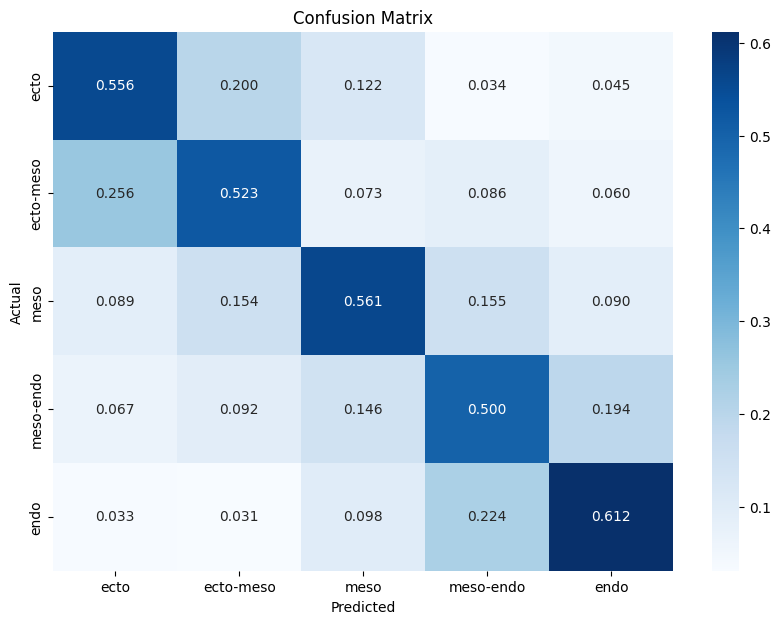

In [16]:
# Trace matrice de confusion
plot_confusion_matrix(predictions1, targets1)

#### 002

In [17]:
# Variables
model_name = 'resnet50'
run_number = 2
log_name = model_name + '_' + "{:03d}".format(run_number)
model_path = os.path.join(run_dir, log_name, 'model_epoch_15.pth')
split = "full_balanced"
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
MyDataset = FrontViewDataset
transform = create_transform((3,320,224))
drop_rate = 0


# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# Evaluate model
accuracy, predictions2, targets2 = evaluate_model(model, dataloader)



Accuracy: 0.554
Mean precision: 0.554
Mean recall: 0.555
---
ecto - precision: 0.583, recall: 0.590
ecto-meso - precision: 0.485, recall: 0.468
meso - precision: 0.489, recall: 0.494
meso-endo - precision: 0.534, recall: 0.522
endo - precision: 0.676, recall: 0.703


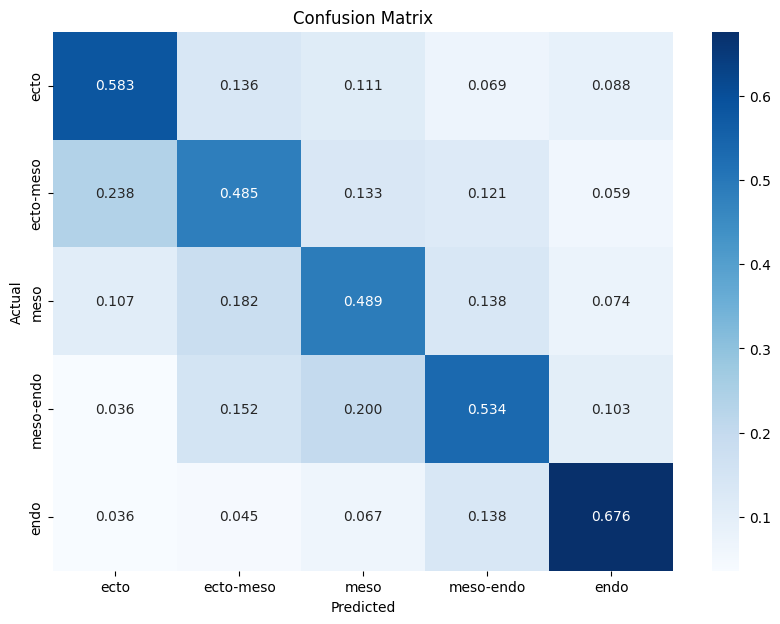

In [18]:
# Trace matrice de confusion
plot_confusion_matrix(predictions2, targets2)

Les tests 001 et 002 semblent atteindre la même conclusion. Avec un simple fine tuning, le modèle semble en difficulté pour correctement classifier les images. Au vu de la matrice de confusion, la classe 'meso' est très mal classifiée. C'est également la classe la moins représentées dans la base de données. On se propose donc dans le test 003 d'utiliser une base de données parfaitement équilibrée. On regardera, lors d'expérimentations futur, le dégèle de l'intégralité du réseau et le traitement des 3 images ou lieu de la première exclusivement. 

#### 003

In [83]:
# Variables
model_name = 'resnet50'
split = "strict_full_balanced"
run_number = 3
log_name = model_name + '_' + "{:03d}".format(run_number)
weigths = 'model_epoch_19.pth'
model_path = os.path.join(run_dir, log_name, weigths)
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
MyDataset = FrontViewDataset
transform = create_transform((3,320,224))
drop_rate = 0

# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# Evaluate model
accuracy, predictions3, targets3 = evaluate_model(model, dataloader)

Accuracy: 0.551
Mean precision: 0.551
Mean recall: 0.555
---
ecto - precision: 0.587, recall: 0.614
ecto-meso - precision: 0.511, recall: 0.476
meso - precision: 0.518, recall: 0.511
meso-endo - precision: 0.542, recall: 0.513
endo - precision: 0.597, recall: 0.663


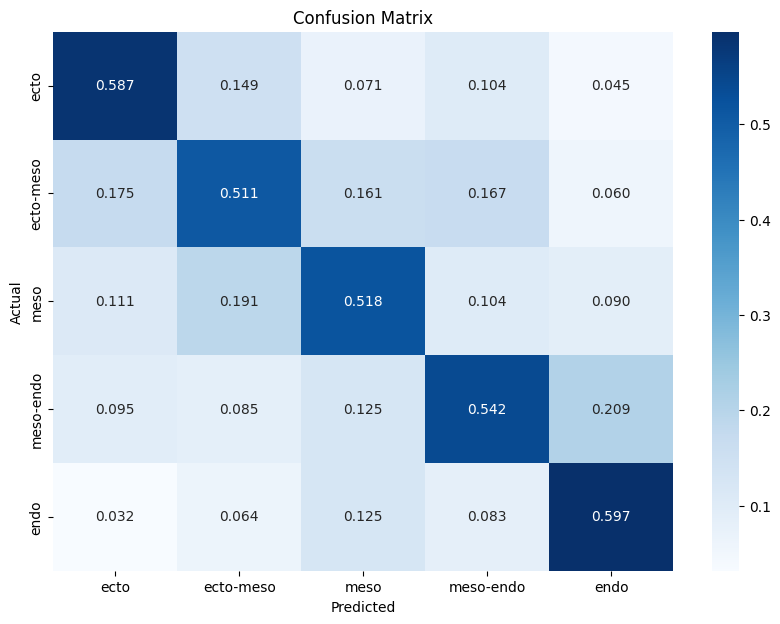

In [84]:
# Trace matrice de confusion
plot_confusion_matrix(predictions3, targets3)

#### 004

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 4, 5, 6, 7], val_folds=[8], test_folds=[9], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_004')
Accuracy: 0.406
Mean precision: 0.406
Mean recall: 0.407
---
ecto - precision: 0.465, recall: 0.479
ecto-meso - precision: 0.344, recall: 0.333
meso - precision: 0.333, recall: 0.346
meso-endo - precision: 0.352, recall: 0.338
endo - precision: 0.535, recall: 0.538


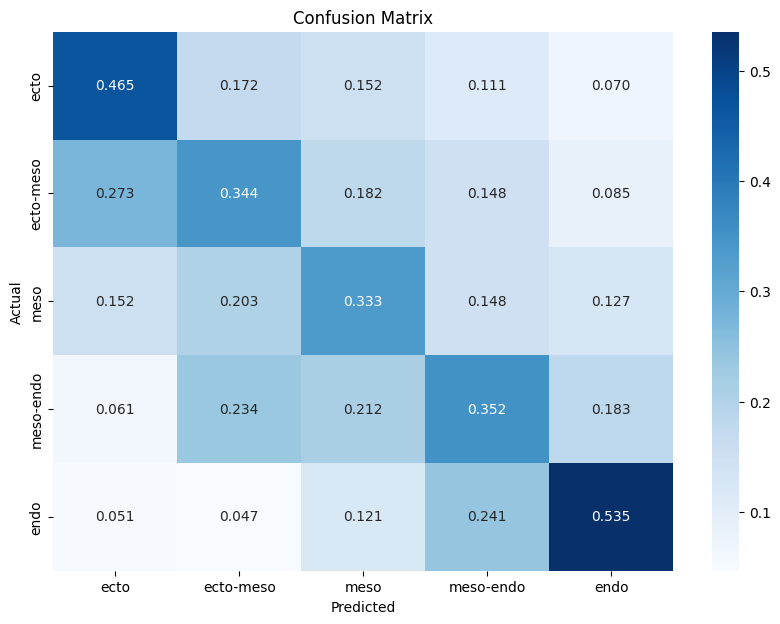

In [85]:
# Variables
model_name = 'resnet50'
split = "full_balanced"
weigths = 'model_epoch_15.pth'
run_number = 4
log_name = model_name + '_' + "{:03d}".format(run_number)
model_path = os.path.join(run_dir, log_name, weigths)

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 005

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_005')
Accuracy: 0.416
Mean precision: 0.416
Mean recall: 0.420
---
ecto - precision: 0.495, recall: 0.567
ecto-meso - precision: 0.293, recall: 0.272
meso - precision: 0.314, recall: 0.343
meso-endo - precision: 0.383, recall: 0.356
endo - precision: 0.594, recall: 0.562


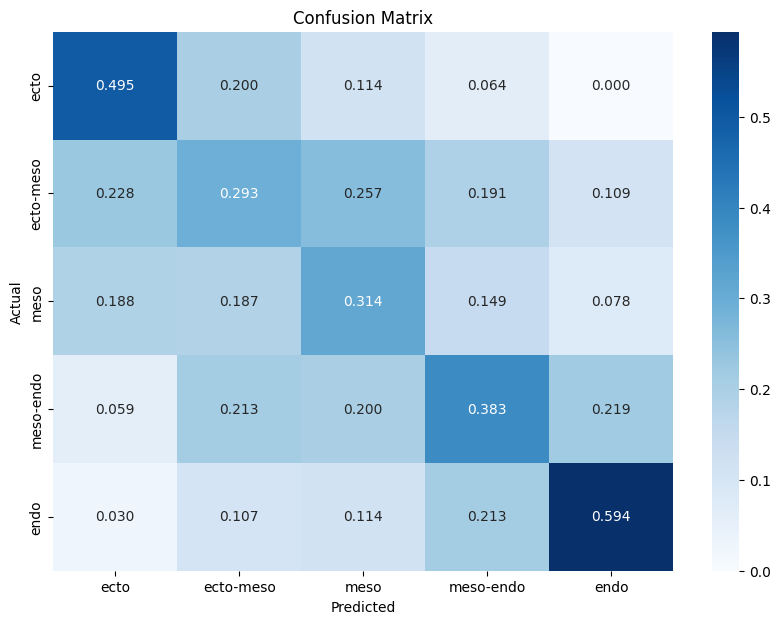

In [86]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '005'
weigths = 'model_epoch_10.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 006

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_006')
Accuracy: 0.395
Mean precision: 0.395
Mean recall: 0.402
---
ecto - precision: 0.437, recall: 0.429
ecto-meso - precision: 0.359, recall: 0.332
meso - precision: 0.321, recall: 0.340
meso-endo - precision: 0.294, recall: 0.278
endo - precision: 0.564, recall: 0.630


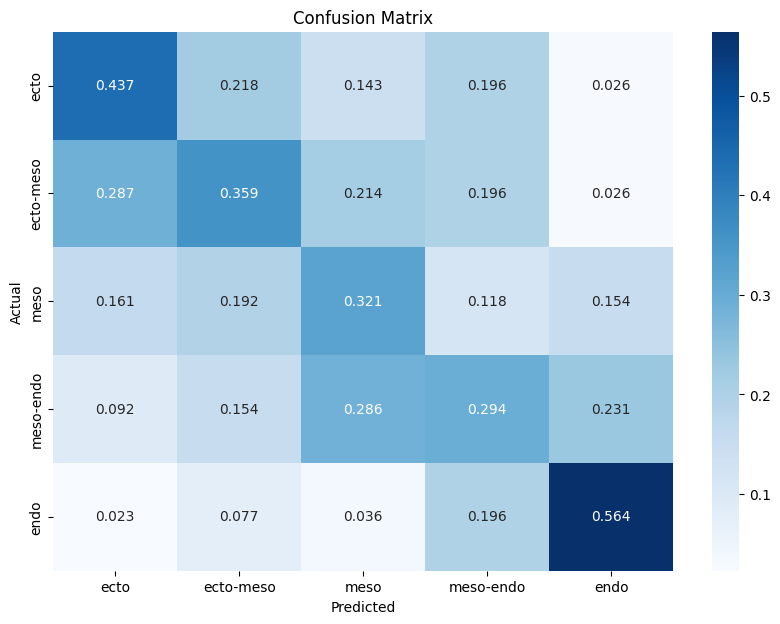

In [87]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '006'
weigths = 'model_epoch_11.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 007

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 4, 6, 7, 8], val_folds=[5], test_folds=[9], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_007')
Accuracy: 0.412
Mean precision: 0.412
Mean recall: 0.412
---
ecto - precision: 0.463, recall: 0.467
ecto-meso - precision: 0.333, recall: 0.323
meso - precision: 0.343, recall: 0.354
meso-endo - precision: 0.339, recall: 0.336
endo - precision: 0.580, recall: 0.582


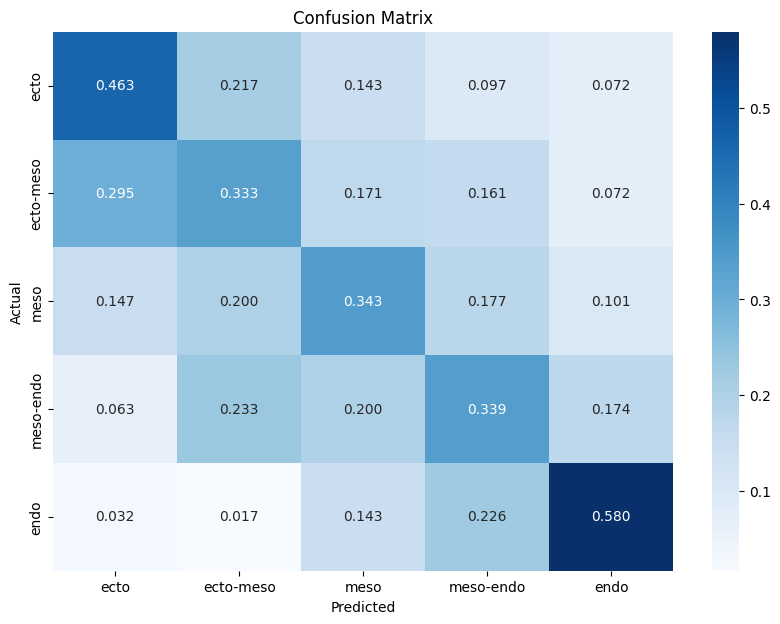

In [88]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '007'
weigths = 'model_epoch_12.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 008

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_008')
Accuracy: 0.378
Mean precision: 0.378
Mean recall: 0.381
---
ecto - precision: 0.479, recall: 0.529
ecto-meso - precision: 0.260, recall: 0.237
meso - precision: 0.250, recall: 0.274
meso-endo - precision: 0.373, recall: 0.357
endo - precision: 0.529, recall: 0.509


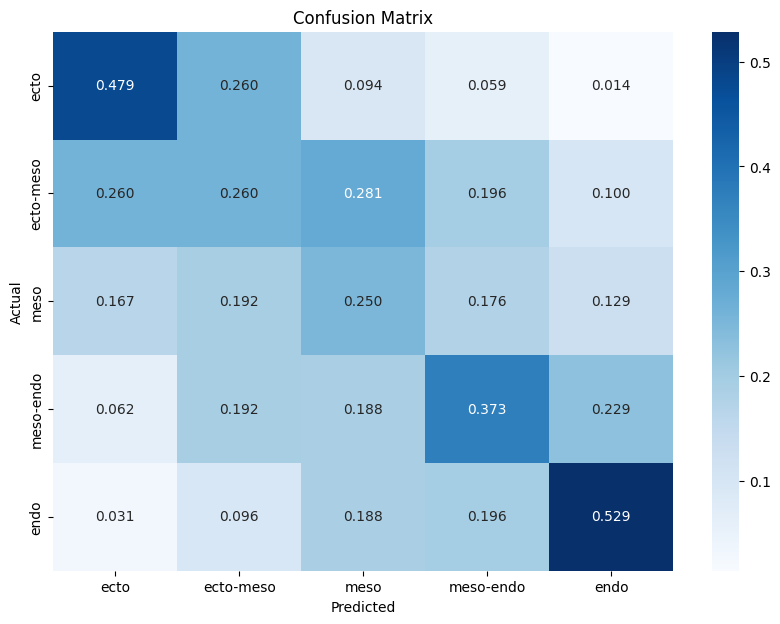

In [89]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '008'
weigths = 'model_epoch_11.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 009

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_009')
Accuracy: 0.401
Mean precision: 0.401
Mean recall: 0.412
---
ecto - precision: 0.500, recall: 0.452
ecto-meso - precision: 0.357, recall: 0.291
meso - precision: 0.291, recall: 0.357
meso-endo - precision: 0.385, recall: 0.367
endo - precision: 0.475, recall: 0.592


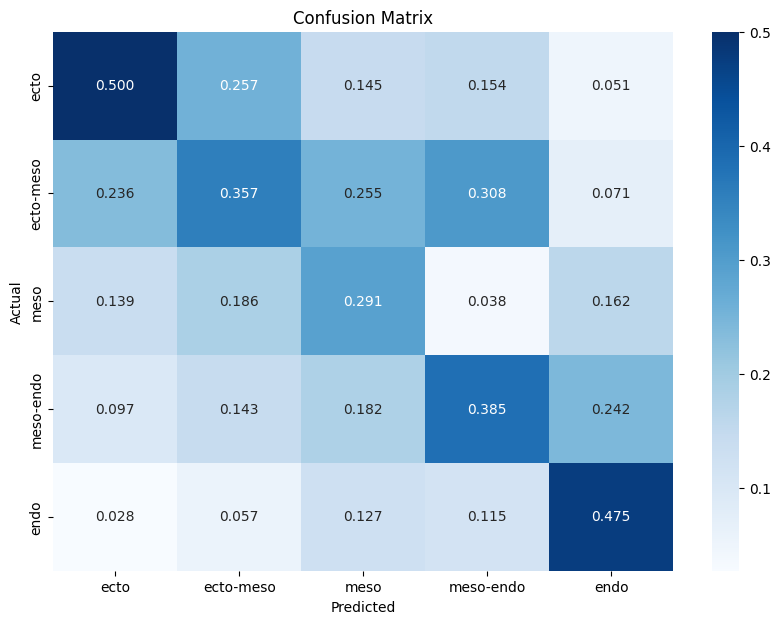

In [90]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '009'
weigths = 'model_epoch_6.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

Au vu des résultats, dégeler tous les paramètres du réseau semble être une bonne solution pour améliorer les performances, avec une amélioration de 10 points. Il est donc à envisager de continuer dans ce sens. D'autre part, il faut explorer l'injection des trois images à l'entrée du réseau, soit via 3*3 cannaux ou bien par la construction d'une grande image incluant les 3 vues sur 3 canneaux. D'autre part, il semble intéressant de moduler le 'early stop' pour permettre au réseau de d'apprendre d'avantage et passer des maximum locaux.

#### 010

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 4, 5, 6, 7], val_folds=[8], test_folds=[9], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_010')
Accuracy: 0.406
Mean precision: 0.406
Mean recall: 0.407
---
ecto - precision: 0.465, recall: 0.479
ecto-meso - precision: 0.344, recall: 0.333
meso - precision: 0.333, recall: 0.346
meso-endo - precision: 0.352, recall: 0.338
endo - precision: 0.535, recall: 0.538


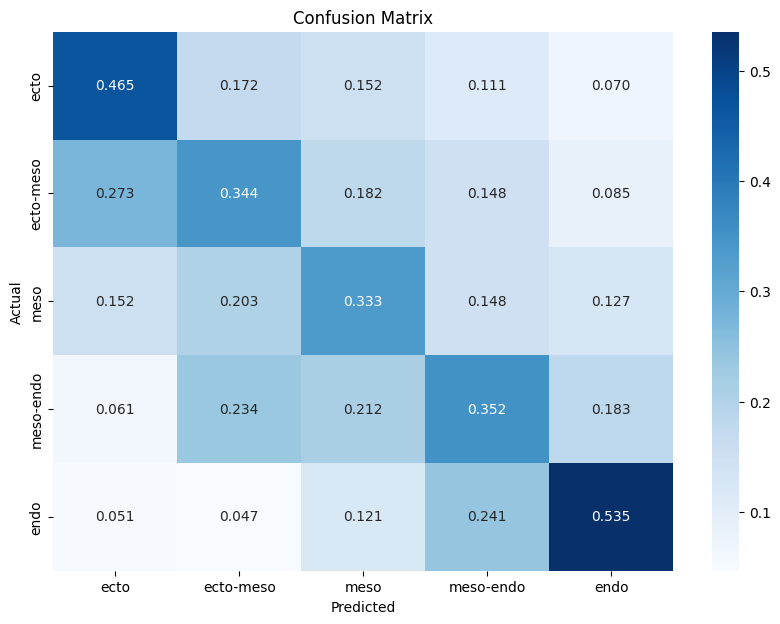

In [91]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '010'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 011

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_011')
Accuracy: 0.378
Mean precision: 0.378
Mean recall: 0.381
---
ecto - precision: 0.479, recall: 0.529
ecto-meso - precision: 0.260, recall: 0.237
meso - precision: 0.250, recall: 0.274
meso-endo - precision: 0.373, recall: 0.357
endo - precision: 0.529, recall: 0.509


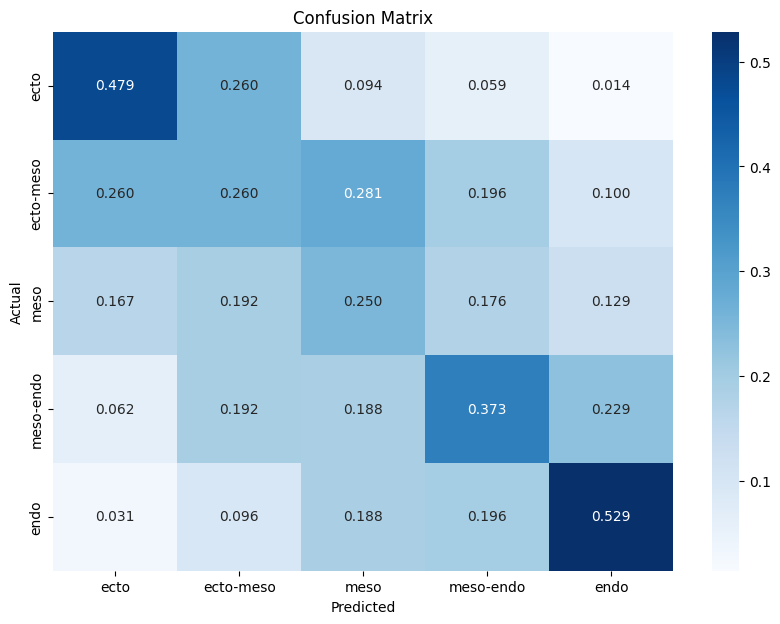

In [92]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '011'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 012

Namespace(model_name='resnet50', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 4, 5, 6, 8, 9], val_folds=[3], test_folds=[7], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50_012')
Accuracy: 0.439
Mean precision: 0.439
Mean recall: 0.445
---
ecto - precision: 0.528, recall: 0.557
ecto-meso - precision: 0.295, recall: 0.272
meso - precision: 0.500, recall: 0.468
meso-endo - precision: 0.339, recall: 0.341
endo - precision: 0.531, recall: 0.589


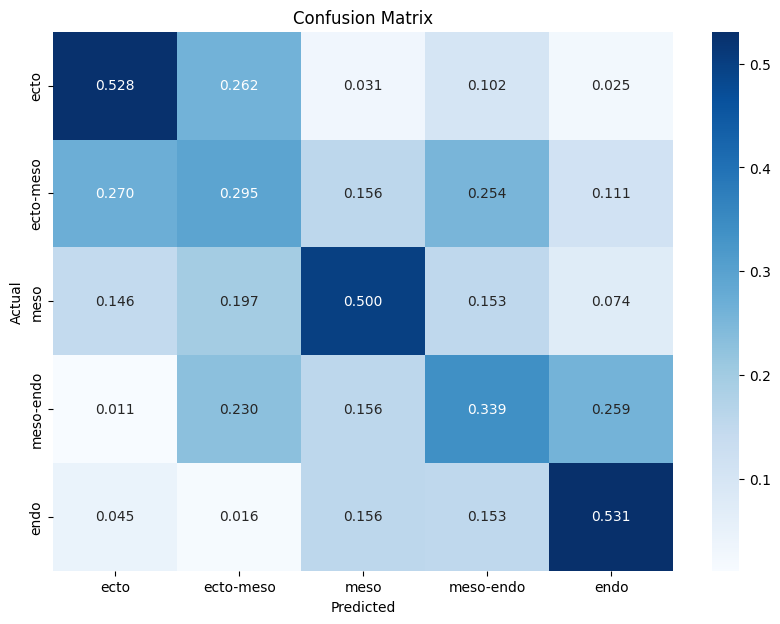

In [93]:
# Variables
model_name = 'resnet50'
log_name = model_name + '_' + '012'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

Pas d'améliorations probantes en augmentant le earlystopping. Ce qu'on va faire, c'est une comparaison avec d'autres modèles, dans le cas le plus favorable de l'entrainement résultant au modèle resnet50_006

### Mobilenetv2_120d

#### 001

In [95]:
# Variables
model_name = 'mobilenetv2_120d'
split = "strict_full_balanced"
log_name = model_name + '_' + '001'
weigths = 'model_epoch_10.pth'
train_folds = [0,1,2,3,4,5,6,7]
val_folds = [8]
test_folds = [9] 
num_classes = 5
in_channels = 3
MyDataset = FrontViewDataset
transform = create_transform((3,320,224))
drop_rate = 0
model_path = os.path.join(run_dir, log_name, weigths)

# Load Dataset
dataloader = load_dataset(split_dir, split, test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, num_classes, model_path)

# Evaluate model
accuracy, predictions4, targets4 = evaluate_model(model, dataloader)

Accuracy: 0.450
Mean precision: 0.450
Mean recall: 0.454
---
ecto - precision: 0.552, recall: 0.613
ecto-meso - precision: 0.321, recall: 0.319
meso - precision: 0.397, recall: 0.402
meso-endo - precision: 0.419, recall: 0.385
endo - precision: 0.564, recall: 0.552


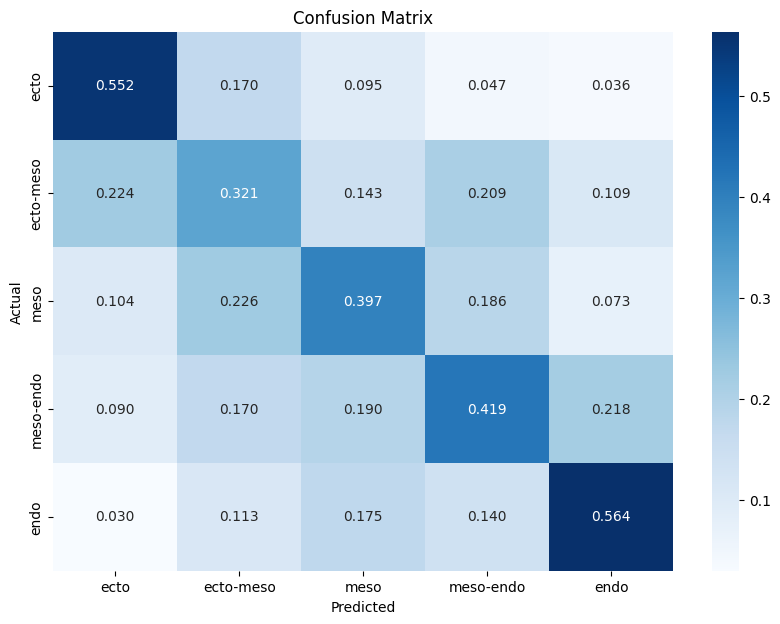

In [96]:
# Trace matrice de confusion
plot_confusion_matrix(predictions4, targets4)

#### 002

Namespace(model_name='mobilenetv2_120d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='mobilenetv2_120d_002')
Accuracy: 0.371
Mean precision: 0.371
Mean recall: 0.372
---
ecto - precision: 0.438, recall: 0.419
ecto-meso - precision: 0.310, recall: 0.285
meso - precision: 0.246, recall: 0.273
meso-endo - precision: 0.306, recall: 0.307
endo - precision: 0.557, recall: 0.574


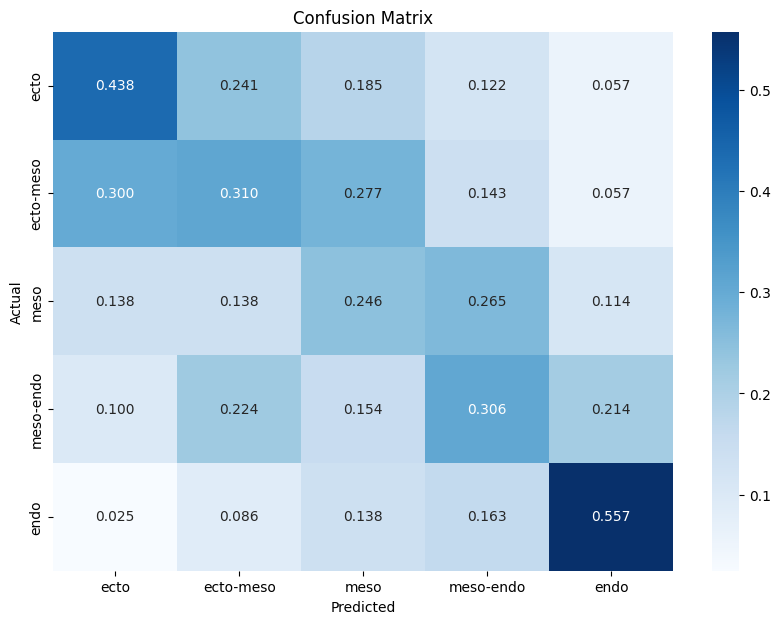

In [97]:
# Variables
model_name = 'mobilenetv2_120d'
log_name = model_name + '_' + '002'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

### ConvNeXt_tiny

#### 001

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_001')
Accuracy: 0.536
Mean precision: 0.536
Mean recall: 0.531
---
ecto - precision: 0.580, recall: 0.635
ecto-meso - precision: 0.500, recall: 0.473
meso - precision: 0.356, recall: 0.448
meso-endo - precision: 0.490, recall: 0.475
endo - precision: 0.755, recall: 0.627


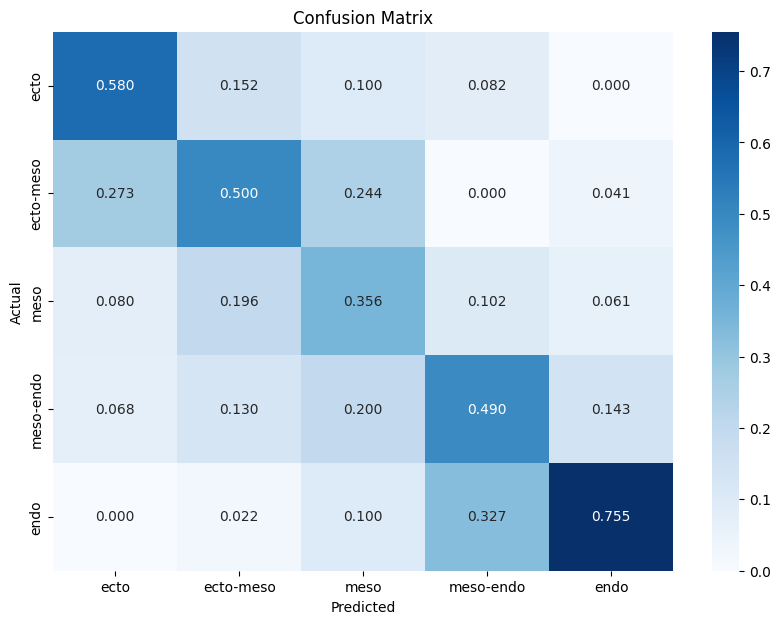

In [98]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '001'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join('runs', log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 002

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_002')
Accuracy: 0.634
Mean precision: 0.634
Mean recall: 0.645
---
ecto - precision: 0.656, recall: 0.835
ecto-meso - precision: 0.481, recall: 0.480
meso - precision: 0.647, recall: 0.525
meso-endo - precision: 0.550, recall: 0.590
endo - precision: 0.836, recall: 0.797


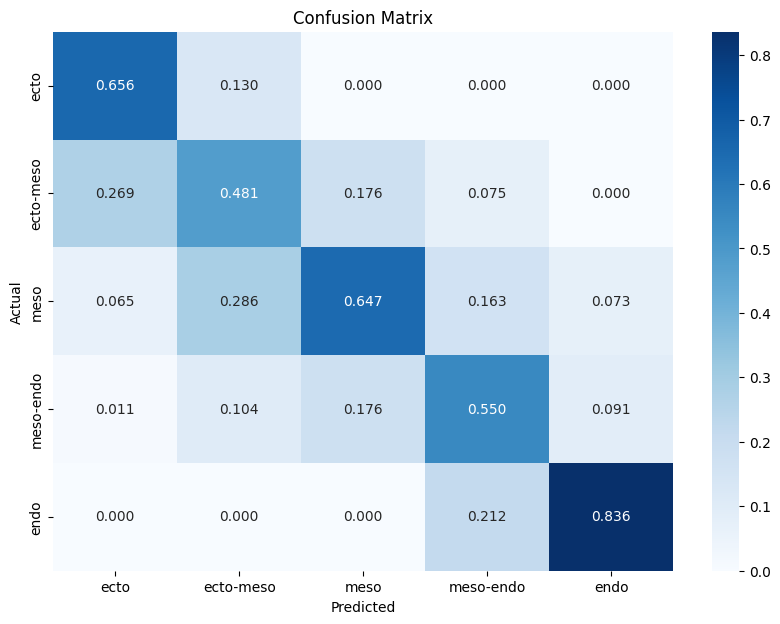

In [99]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '002'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 003

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_003')
Accuracy: 0.653
Mean precision: 0.653
Mean recall: 0.654
---
ecto - precision: 0.817, recall: 0.713
ecto-meso - precision: 0.507, recall: 0.481
meso - precision: 0.585, recall: 0.683
meso-endo - precision: 0.586, recall: 0.613
endo - precision: 0.773, recall: 0.781


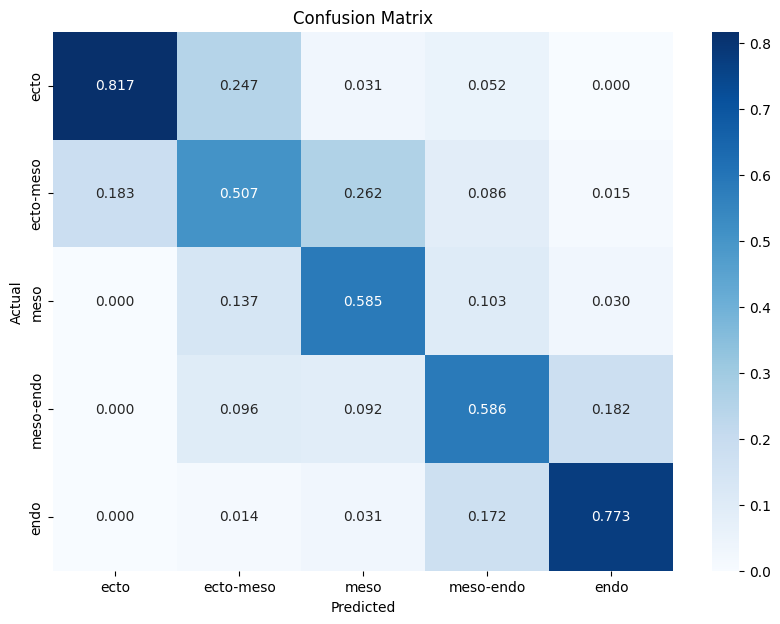

In [100]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '003'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 004

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_004')
Accuracy: 0.605
Mean precision: 0.605
Mean recall: 0.597
---
ecto - precision: 0.889, recall: 0.836
ecto-meso - precision: 0.424, recall: 0.434
meso - precision: 0.521, recall: 0.569
meso-endo - precision: 0.415, recall: 0.437
endo - precision: 0.778, recall: 0.712


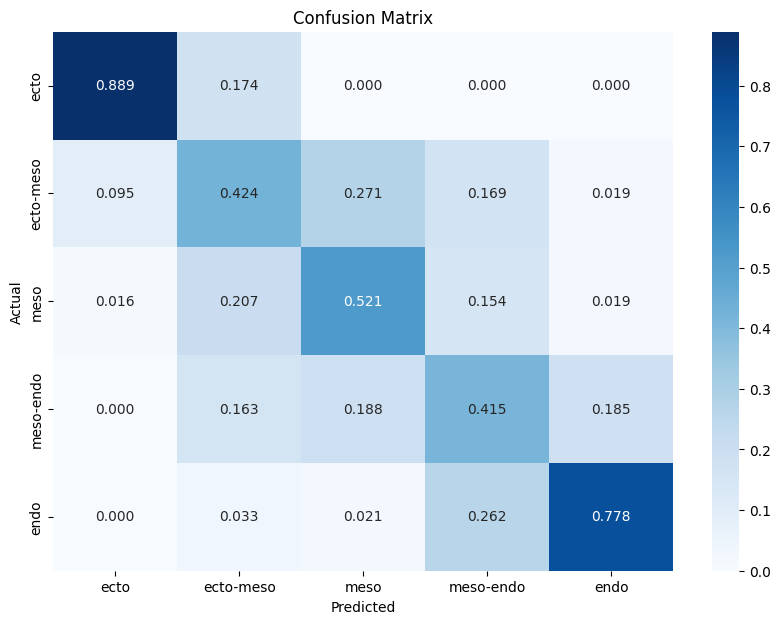

In [101]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '004'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 005

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=5, progressive_unfreeze=True, progressive_unfreeze_step=5, earlyStopping_min_delta=0.01, earlyStopping_patience=10, device='xpu', data_path='/data', split_path='./splits', log_path='./runs', log_name='convnext_tiny_005')


/usr/local/lib/python3.10/dist-packages/torch/overrides.py:110: UserWarning: 'has_cuda' is deprecated, please use 'torch.backends.cuda.is_built()'
  torch.has_cuda,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:111: UserWarning: 'has_cudnn' is deprecated, please use 'torch.backends.cudnn.is_available()'
  torch.has_cudnn,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:117: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  torch.has_mps,
/usr/local/lib/python3.10/dist-packages/torch/overrides.py:118: UserWarning: 'has_mkldnn' is deprecated, please use 'torch.backends.mkldnn.is_available()'
  torch.has_mkldnn,


Accuracy: 0.461
Mean precision: 0.461
Mean recall: 0.468
---
ecto - precision: 0.514, recall: 0.580
ecto-meso - precision: 0.385, recall: 0.403
meso - precision: 0.273, recall: 0.289
meso-endo - precision: 0.463, recall: 0.369
endo - precision: 0.671, recall: 0.698


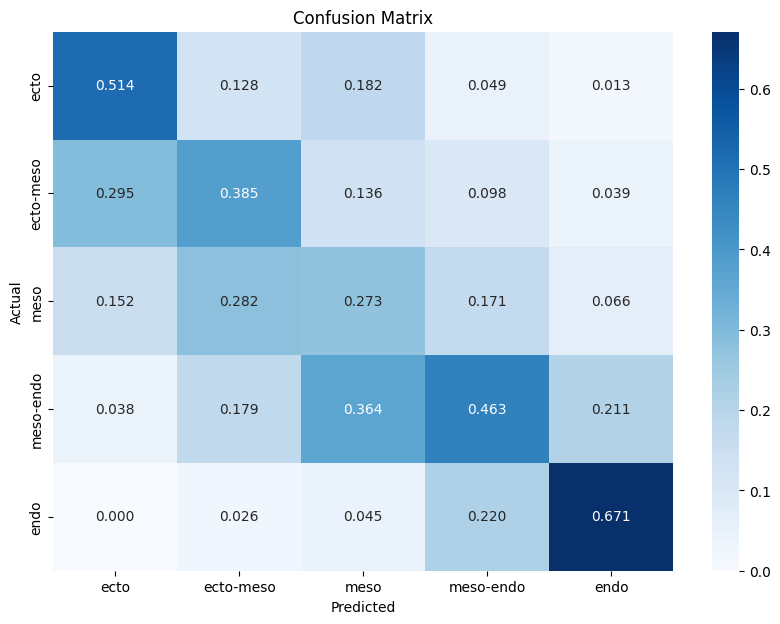

In [9]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '005'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 006

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=5, progressive_unfreeze=True, progressive_unfreeze_step=5, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_006')
Accuracy: 0.471
Mean precision: 0.471
Mean recall: 0.473
---
ecto - precision: 0.475, recall: 0.562
ecto-meso - precision: 0.333, recall: 0.315
meso - precision: 0.400, recall: 0.426
meso-endo - precision: 0.415, recall: 0.388
endo - precision: 0.733, recall: 0.674


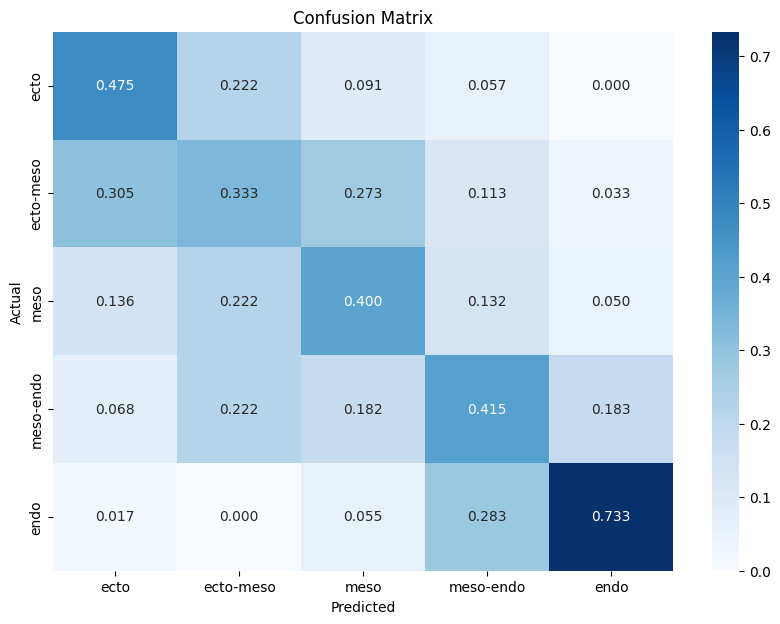

In [10]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '006'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 007

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=5, progressive_unfreeze=True, progressive_unfreeze_step=5, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_007')
Accuracy: 0.482
Mean precision: 0.482
Mean recall: 0.490
---
ecto - precision: 0.646, recall: 0.674
ecto-meso - precision: 0.318, recall: 0.289
meso - precision: 0.324, recall: 0.368
meso-endo - precision: 0.500, recall: 0.431
endo - precision: 0.620, recall: 0.689


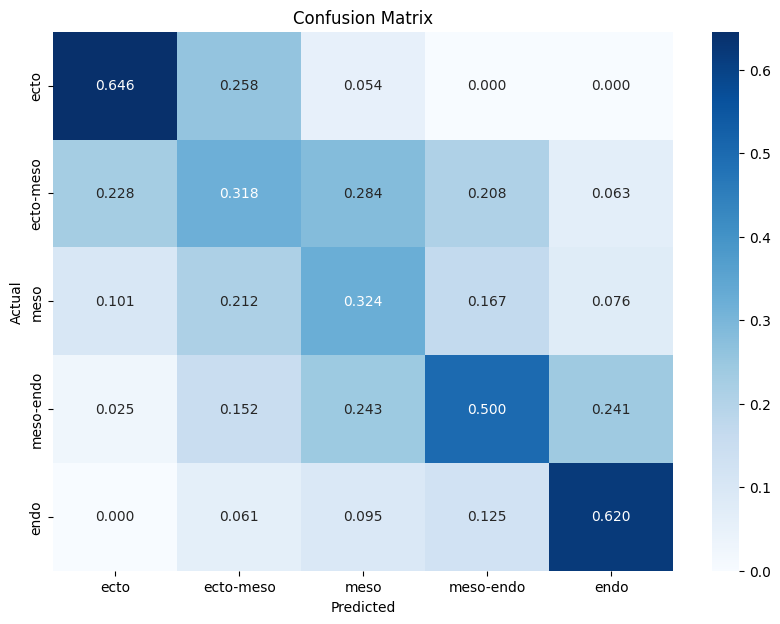

In [11]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '007'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 008

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 5, 6, 7, 8], val_folds=[9], test_folds=[4], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=5, progressive_unfreeze=True, progressive_unfreeze_step=5, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_008')
Accuracy: 0.540
Mean precision: 0.540
Mean recall: 0.543
---
ecto - precision: 0.620, recall: 0.737
ecto-meso - precision: 0.342, recall: 0.346
meso - precision: 0.500, recall: 0.462
meso-endo - precision: 0.411, recall: 0.412
endo - precision: 0.827, recall: 0.759


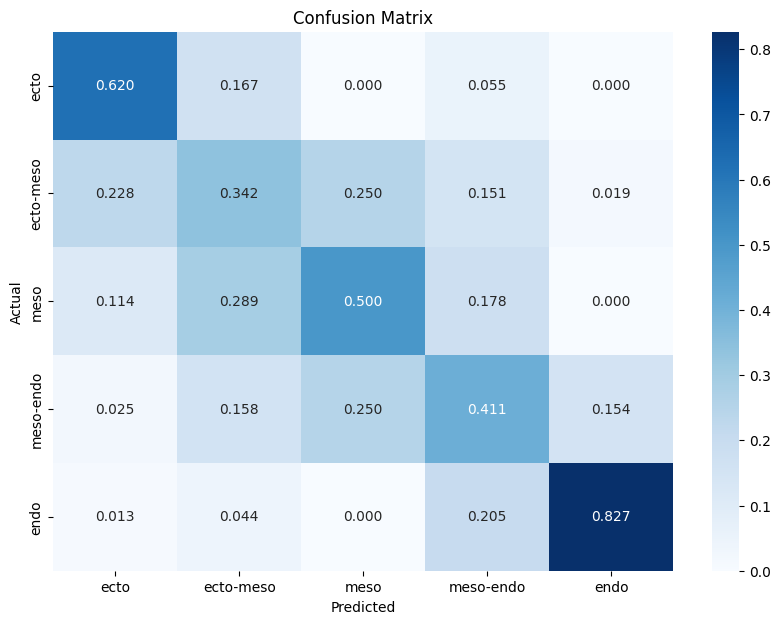

In [12]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '008'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 009

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 3, 4, 5, 6, 7, 9], val_folds=[2], test_folds=[8], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=5, progressive_unfreeze=True, progressive_unfreeze_step=5, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_009')
Accuracy: 0.482
Mean precision: 0.482
Mean recall: 0.488
---
ecto - precision: 0.547, recall: 0.580
ecto-meso - precision: 0.296, recall: 0.276
meso - precision: 0.421, recall: 0.423
meso-endo - precision: 0.413, recall: 0.406
endo - precision: 0.734, recall: 0.755


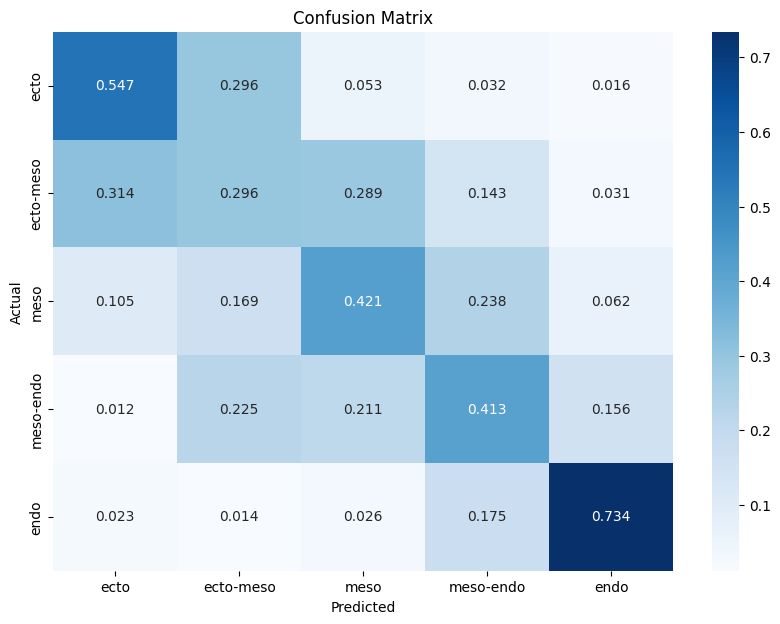

In [13]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '009'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 010

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=True, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_010')
Accuracy: 0.602
Mean precision: 0.602
Mean recall: 0.597
---
ecto - precision: 0.783, recall: 0.767
ecto-meso - precision: 0.553, recall: 0.534
meso - precision: 0.385, recall: 0.426
meso-endo - precision: 0.484, recall: 0.477
endo - precision: 0.803, recall: 0.783


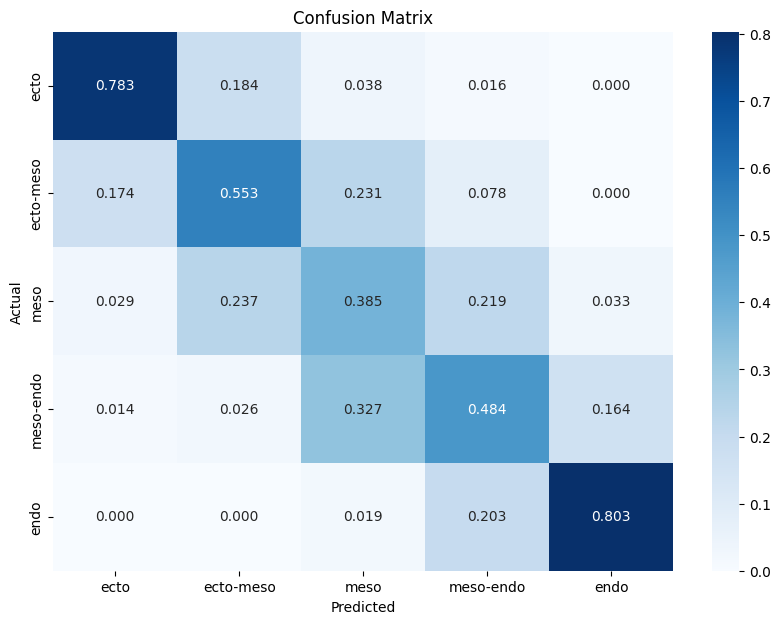

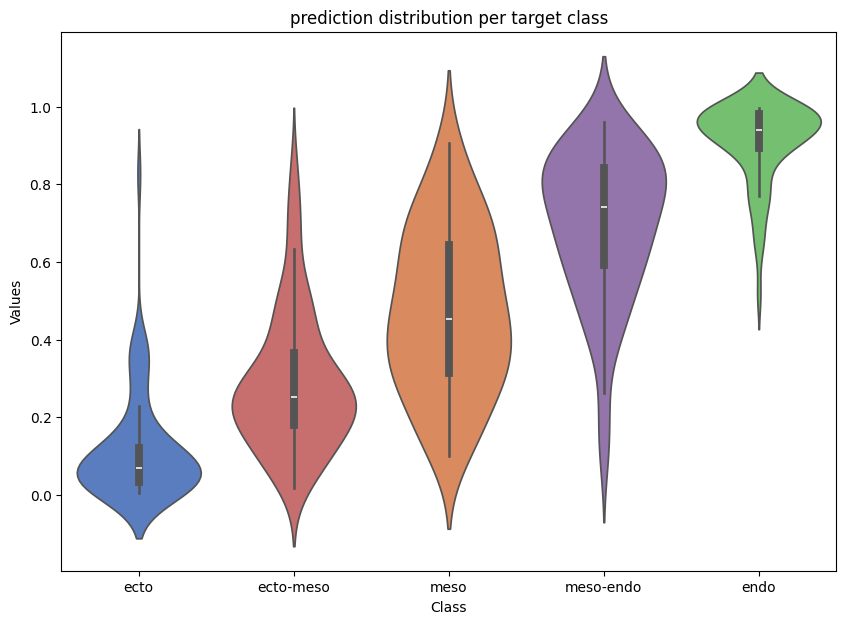

In [55]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '010'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, 1, model_path)

# Evaluate model
accuracy, predictions, targets, outputs = evaluate_model_linear(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, outputs=outputs)

#### 011

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=True, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_011')
Accuracy: 0.620
Mean precision: 0.620
Mean recall: 0.607
---
ecto - precision: 0.810, recall: 0.740
ecto-meso - precision: 0.478, recall: 0.525
meso - precision: 0.379, recall: 0.459
meso-endo - precision: 0.560, recall: 0.545
endo - precision: 0.875, recall: 0.766


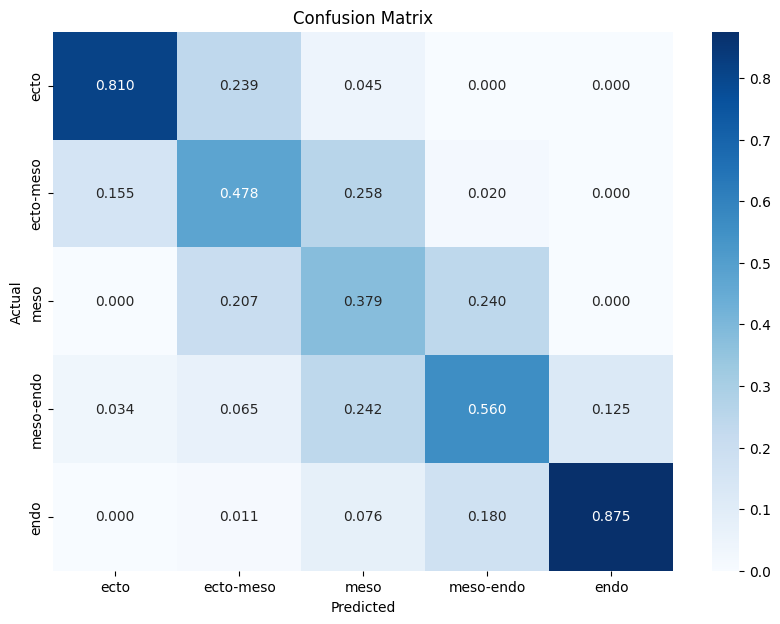

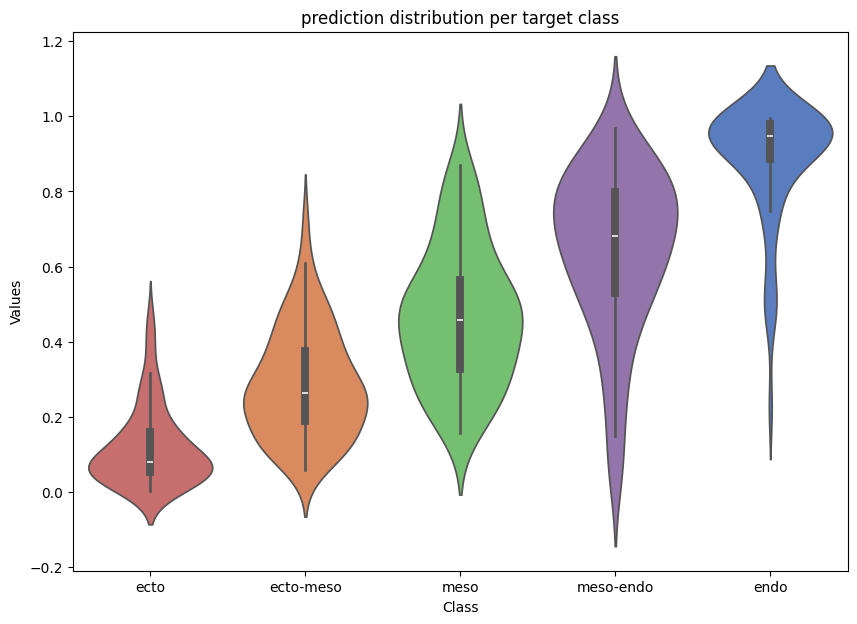

In [56]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '011'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, 1, model_path)

# Evaluate model
accuracy, predictions, targets, outputs = evaluate_model_linear(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, outputs=outputs)

#### 012

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=True, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_012')
Accuracy: 0.605
Mean precision: 0.605
Mean recall: 0.602
---
ecto - precision: 0.823, recall: 0.771
ecto-meso - precision: 0.477, recall: 0.487
meso - precision: 0.421, recall: 0.471
meso-endo - precision: 0.571, recall: 0.529
endo - precision: 0.735, recall: 0.750


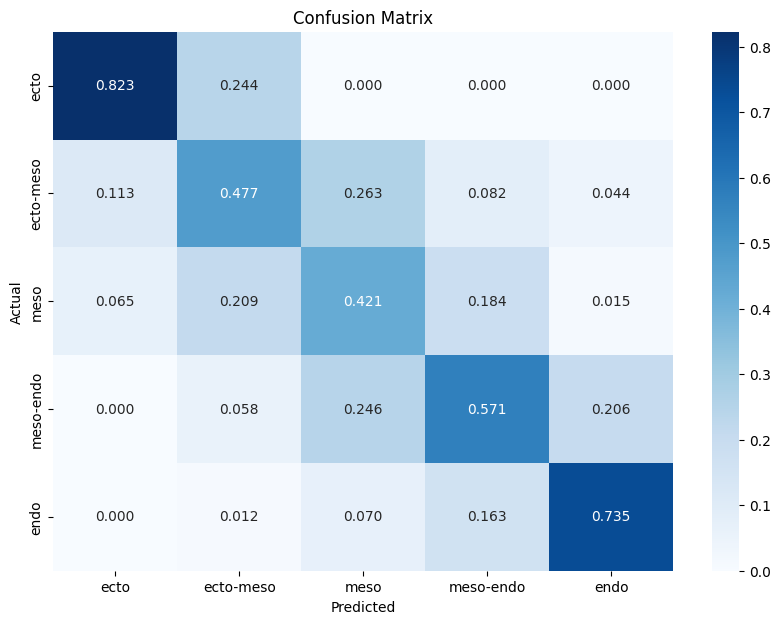

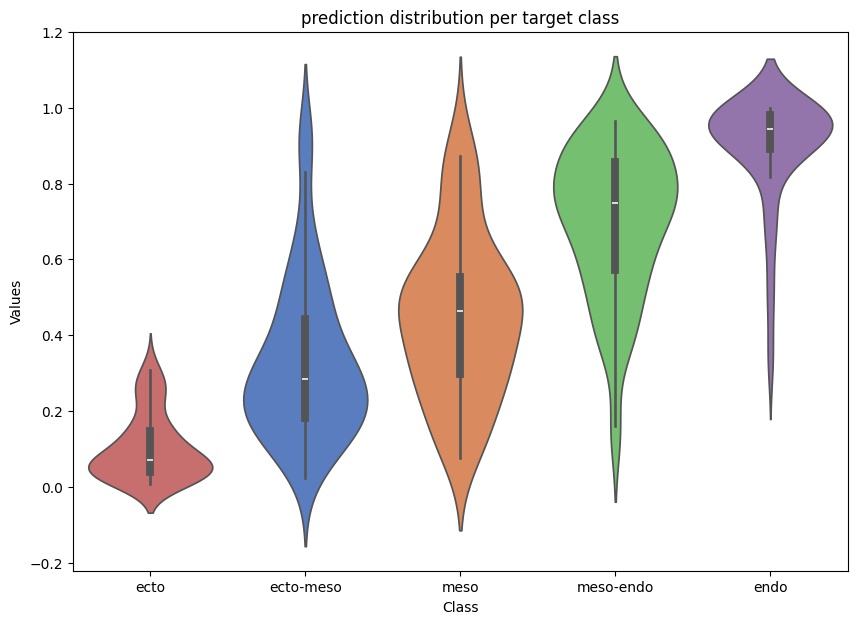

In [57]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '012'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, 1, model_path)

# Evaluate model
accuracy, predictions, targets, outputs = evaluate_model_linear(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, outputs=outputs)

#### 013

Namespace(model_name='convnext_tiny', batch_size=64, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=True, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_013')
Accuracy: 0.607
Mean precision: 0.607
Mean recall: 0.604
---
ecto - precision: 0.768, recall: 0.754
ecto-meso - precision: 0.553, recall: 0.537
meso - precision: 0.393, recall: 0.434
meso-endo - precision: 0.526, recall: 0.507
endo - precision: 0.797, recall: 0.791


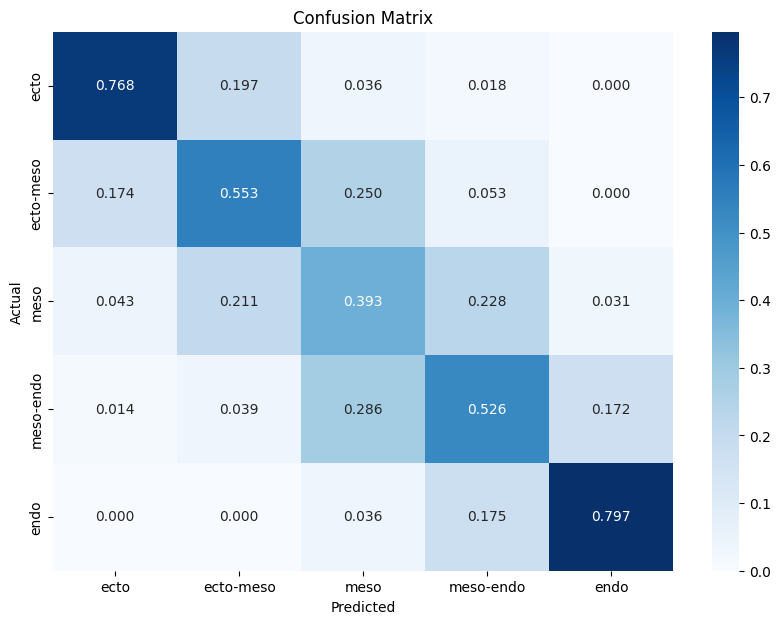

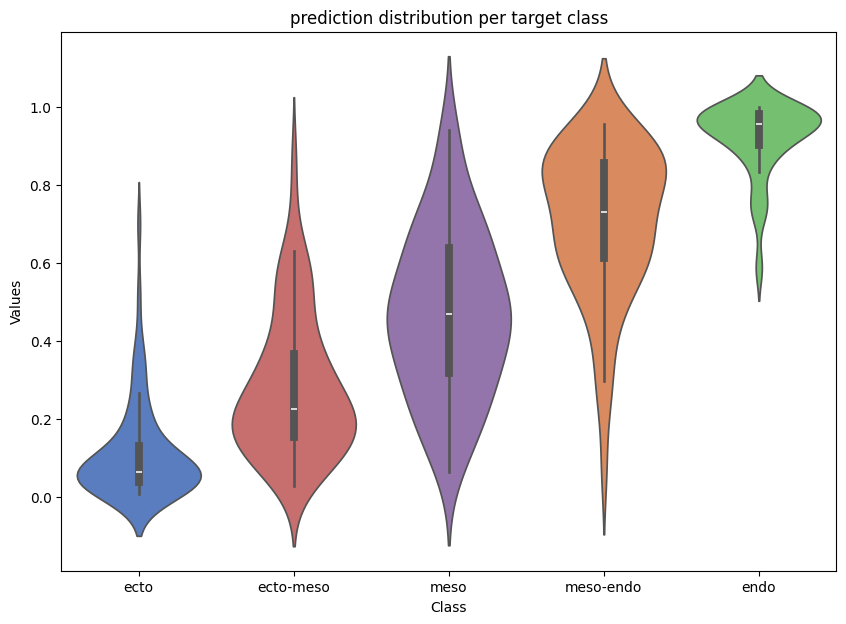

In [58]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '013'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, 1, model_path)

# Evaluate model
accuracy, predictions, targets, outputs = evaluate_model_linear(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, outputs=outputs)

#### 014

Namespace(model_name='convnext_tiny', batch_size=64, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=True, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_014')
Accuracy: 0.577
Mean precision: 0.577
Mean recall: 0.570
---
ecto - precision: 0.797, recall: 0.696
ecto-meso - precision: 0.413, recall: 0.391
meso - precision: 0.359, recall: 0.424
meso-endo - precision: 0.517, recall: 0.549
endo - precision: 0.797, recall: 0.790


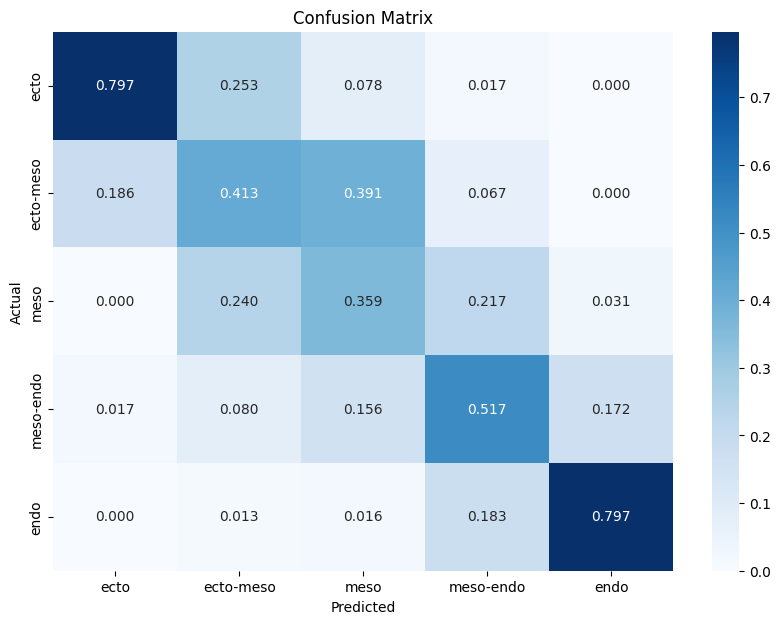

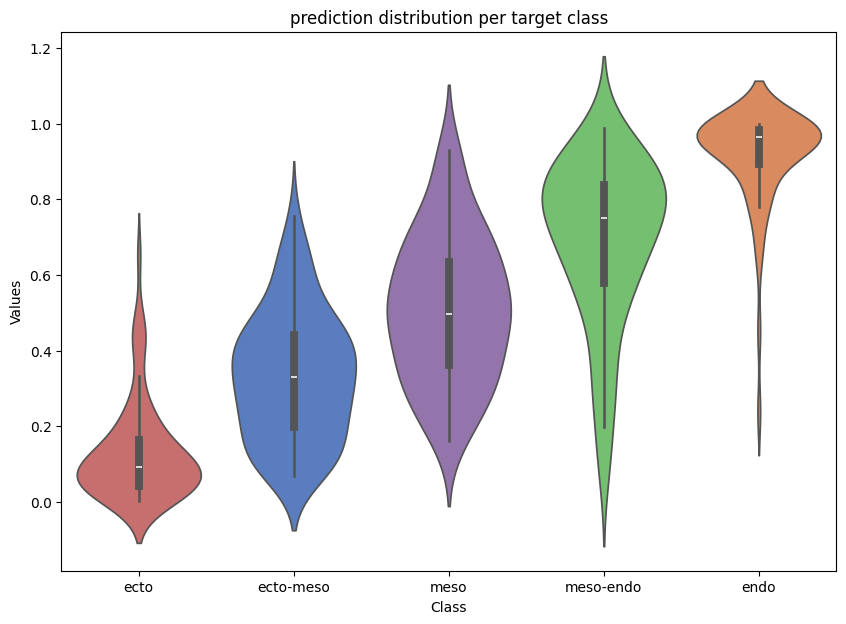

In [59]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '014'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, 1, model_path)

# Evaluate model
accuracy, predictions, targets, outputs = evaluate_model_linear(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, outputs=outputs)

#### 015

Namespace(model_name='convnext_tiny', batch_size=64, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=True, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_015')
Accuracy: 0.551
Mean precision: 0.551
Mean recall: 0.542
---
ecto - precision: 0.721, recall: 0.677
ecto-meso - precision: 0.407, recall: 0.406
meso - precision: 0.339, recall: 0.412
meso-endo - precision: 0.518, recall: 0.508
endo - precision: 0.772, recall: 0.708


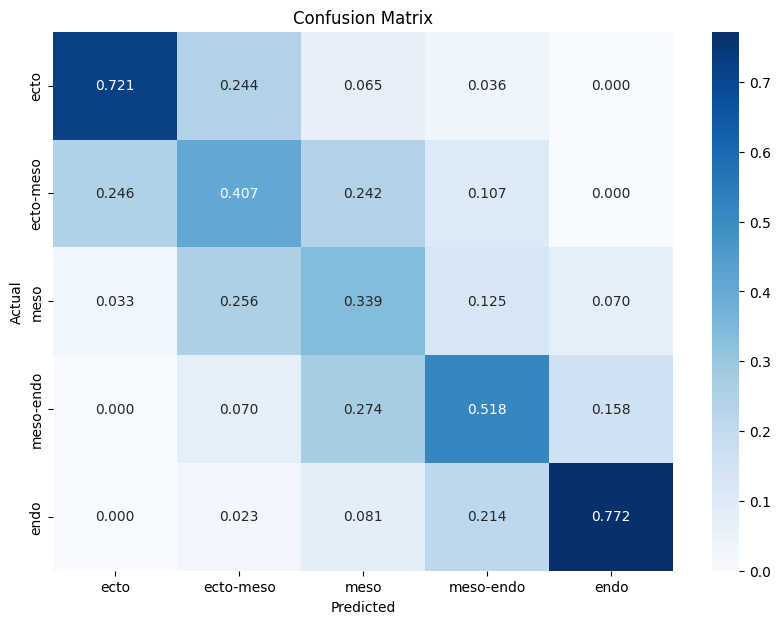

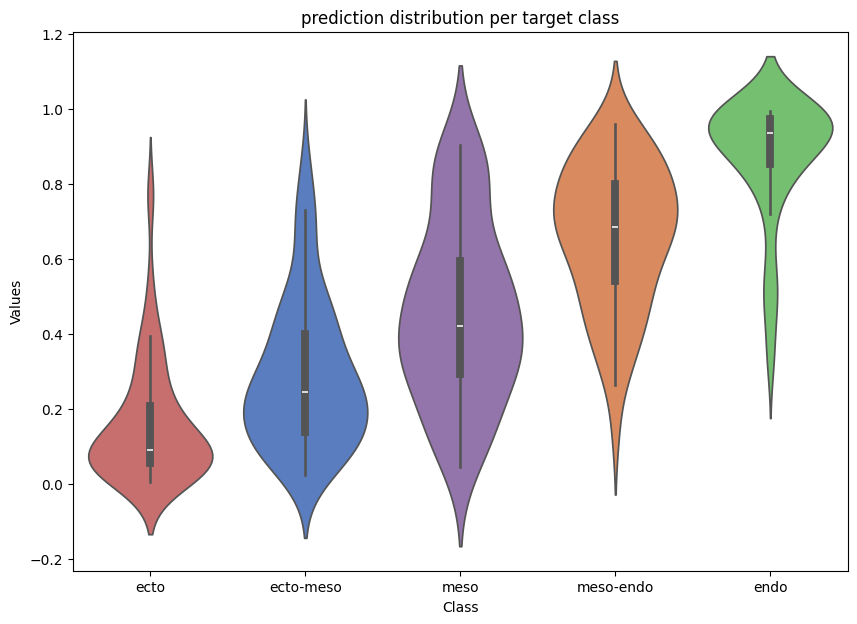

In [13]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '015'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, 1, model_path)

# Evaluate model
accuracy, predictions, targets, outputs = evaluate_model_linear(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, outputs=outputs)

#### 016

Namespace(model_name='convnext_tiny', batch_size=64, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=True, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_016')
Accuracy: 0.510
Mean precision: 0.510
Mean recall: 0.504
---
ecto - precision: 0.787, recall: 0.633
ecto-meso - precision: 0.358, recall: 0.334
meso - precision: 0.311, recall: 0.366
meso-endo - precision: 0.381, recall: 0.424
endo - precision: 0.714, recall: 0.761


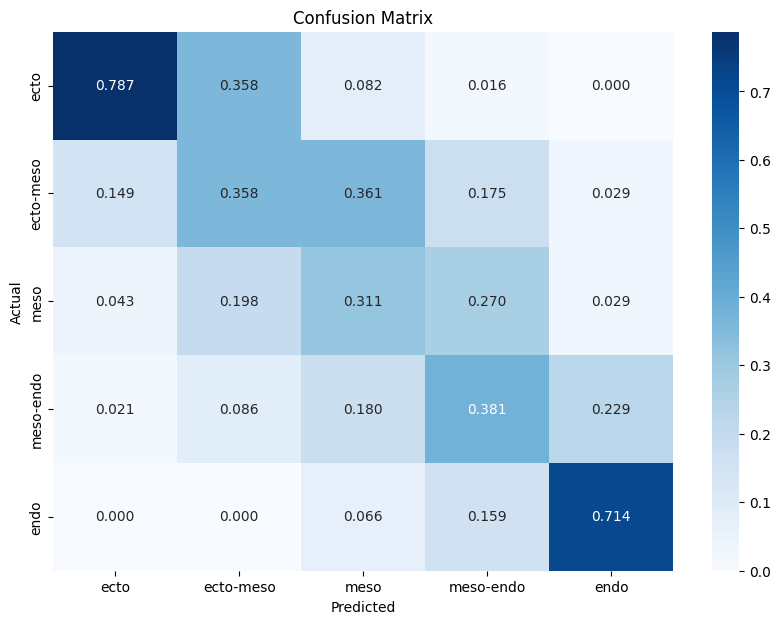

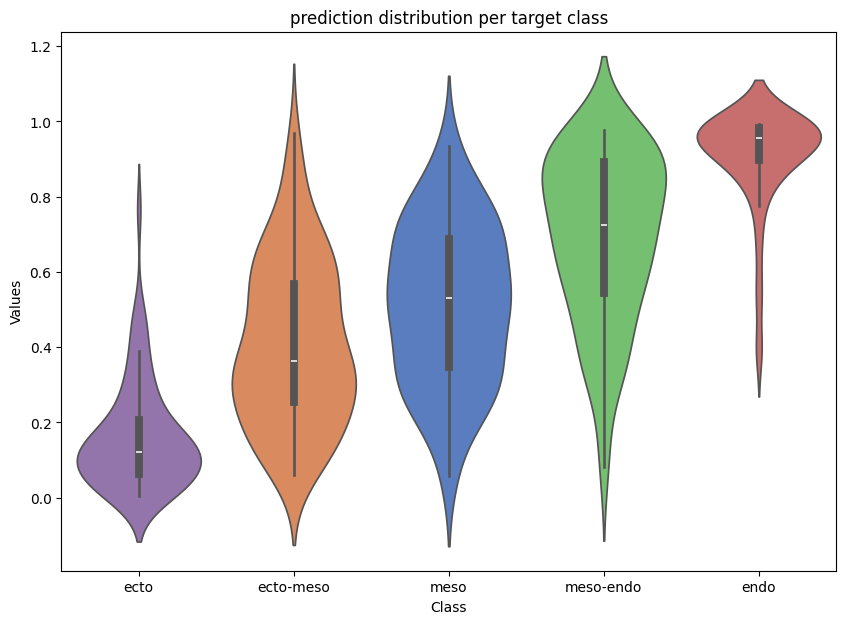

In [12]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '016'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, 1, model_path)

# Evaluate model
accuracy, predictions, targets, outputs = evaluate_model_linear(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, outputs=outputs)

#### 017

Namespace(model_name='convnext_tiny', batch_size=64, learning_rate=0.0001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=True, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_017')
Accuracy: 0.533
Mean precision: 0.533
Mean recall: 0.532
---
ecto - precision: 0.688, recall: 0.792
ecto-meso - precision: 0.415, recall: 0.450
meso - precision: 0.333, recall: 0.414
meso-endo - precision: 0.434, recall: 0.394
endo - precision: 0.795, recall: 0.610


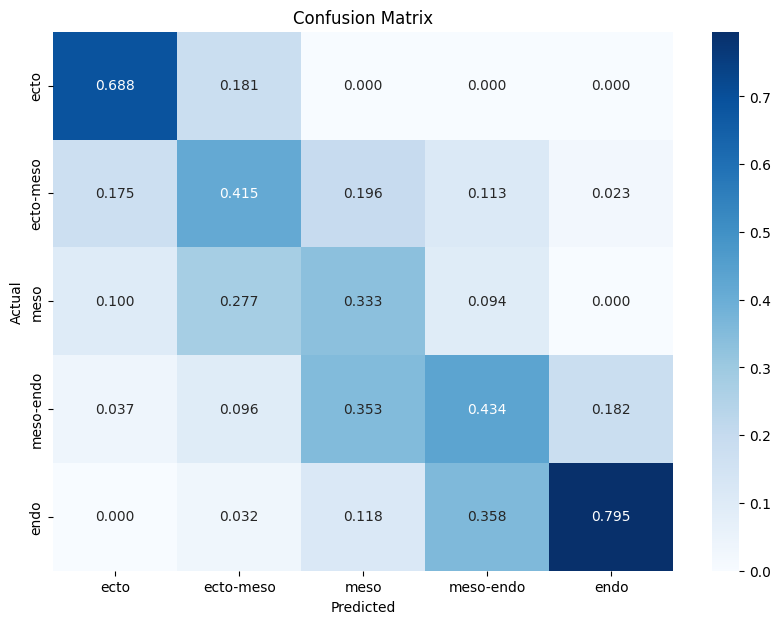

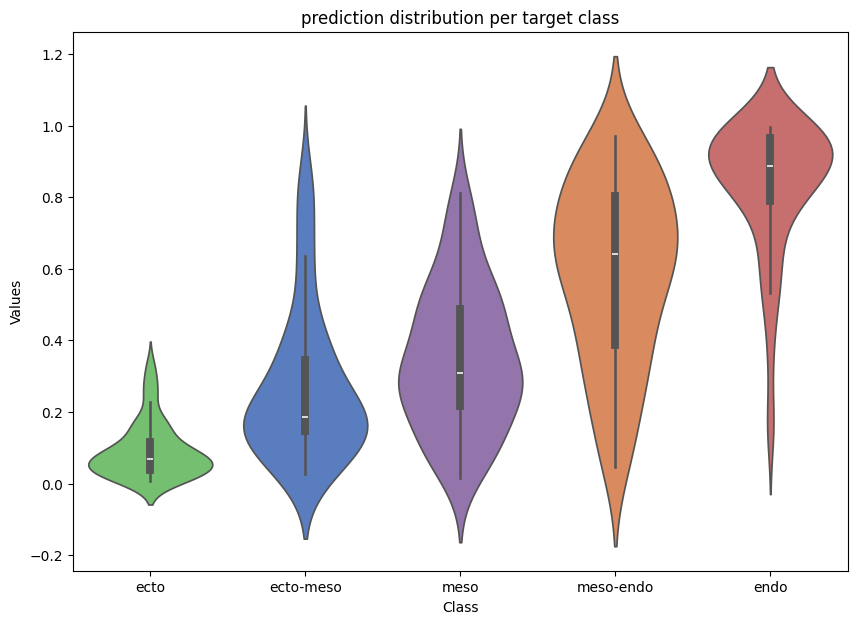

In [14]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '017'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, 1, model_path)

# Evaluate model
accuracy, predictions, targets, outputs = evaluate_model_linear(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, outputs=outputs)

#### 018

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced_3_classes', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_018')
Accuracy: 0.911
Mean precision: 0.911
Mean recall: 0.912
---
ecto - precision: 0.947, recall: 0.877
meso - precision: 0.851, recall: 0.889
endo - precision: 0.934, recall: 0.969


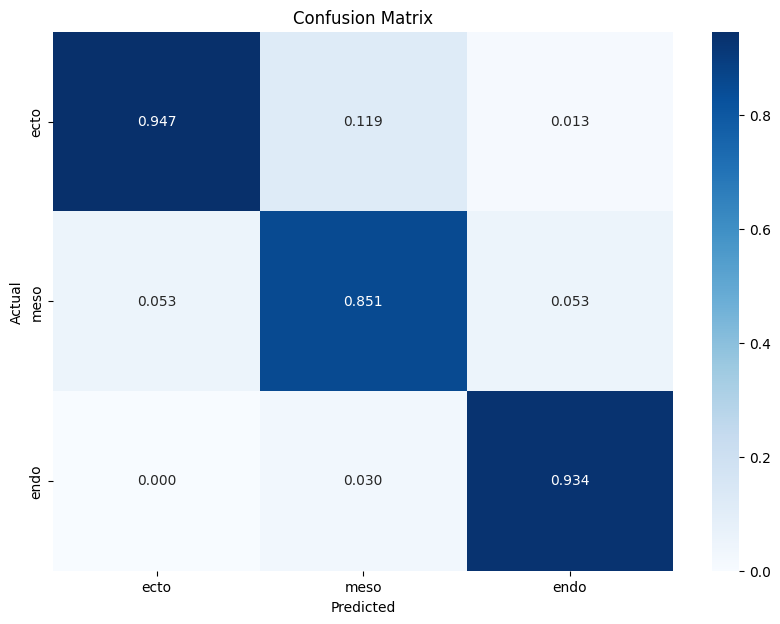

In [46]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '018'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=opt.num_classes)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, index_to_label=index_to_label_3_classes, label_to_index=label_to_index_3_classes)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_018')
Accuracy: 0.559
Mean precision: 0.559
Mean recall: 0.583
---
ecto - precision: 0.638, recall: 0.696
ecto-meso - precision: 0.552, recall: 0.424
meso - precision: 0.441, recall: 0.565
meso-endo - precision: 0.476, recall: 0.411
endo - precision: 0.690, recall: 0.820


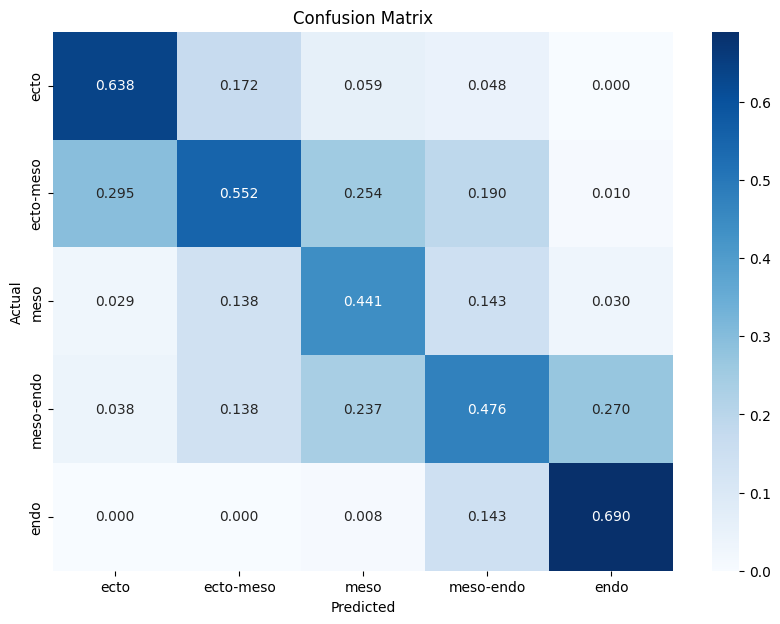

In [35]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '018'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_018')
Accuracy: 0.576
Mean precision: 0.576
Mean recall: 0.596
---
ecto - precision: 0.663, recall: 0.672
ecto-meso - precision: 0.538, recall: 0.445
meso - precision: 0.505, recall: 0.585
meso-endo - precision: 0.485, recall: 0.430
endo - precision: 0.690, recall: 0.851


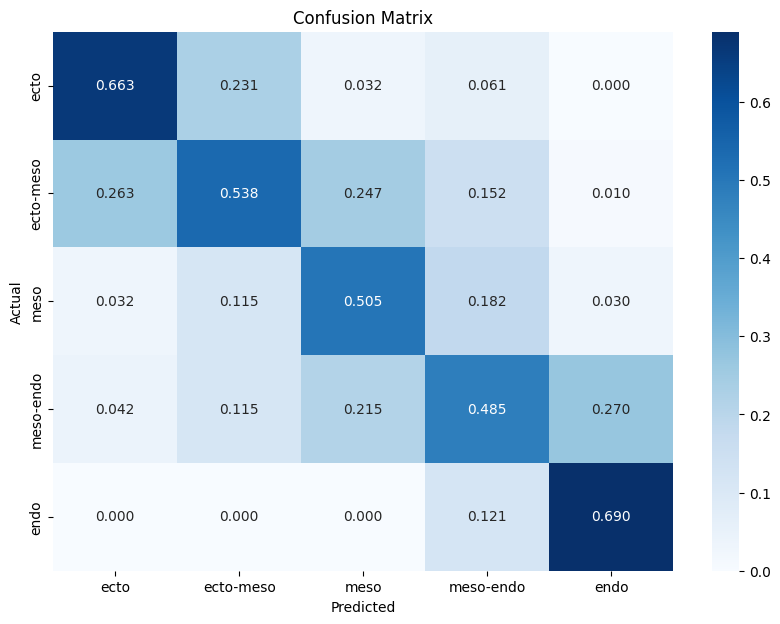

In [42]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '018'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader, threshold=0.9)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

#### 019

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced_3_classes', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_019')
Accuracy: 0.888
Mean precision: 0.888
Mean recall: 0.892
---
ecto - precision: 0.831, recall: 0.915
meso - precision: 0.922, recall: 0.815
endo - precision: 0.910, recall: 0.947


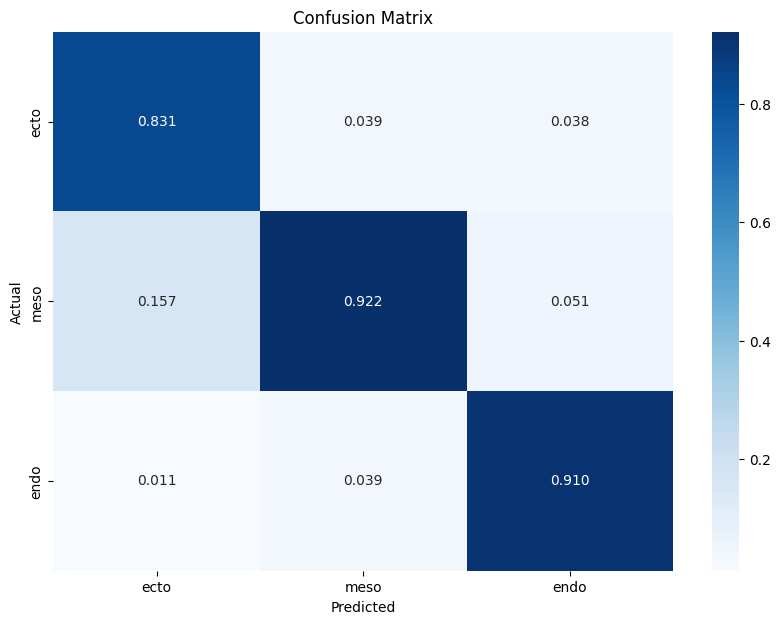

In [30]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '019'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=opt.num_classes)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, index_to_label=index_to_label_3_classes, label_to_index=label_to_index_3_classes)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_019')
Accuracy: 0.612
Mean precision: 0.612
Mean recall: 0.640
---
ecto - precision: 0.602, recall: 0.738
ecto-meso - precision: 0.707, recall: 0.531
meso - precision: 0.513, recall: 0.572
meso-endo - precision: 0.625, recall: 0.505
endo - precision: 0.614, recall: 0.854


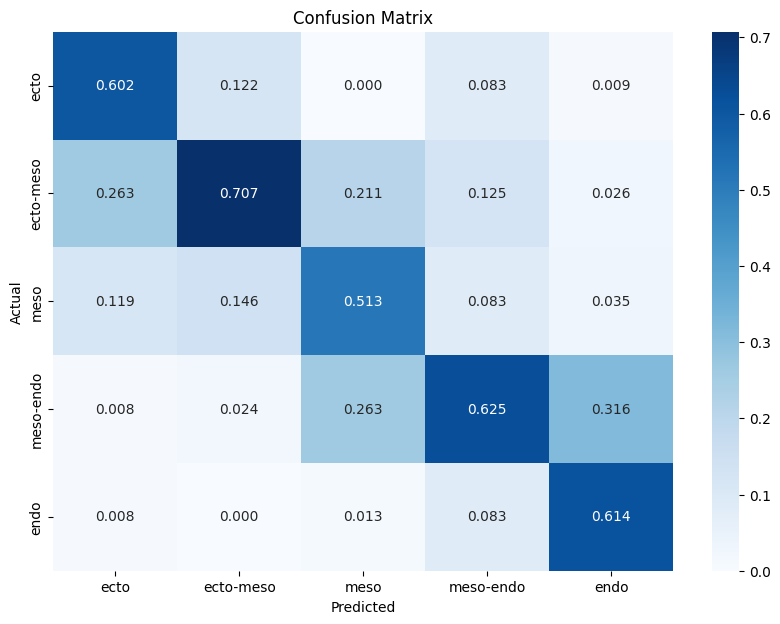

In [36]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '019'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_019')
Accuracy: 0.597
Mean precision: 0.597
Mean recall: 0.635
---
ecto - precision: 0.582, recall: 0.687
ecto-meso - precision: 0.667, recall: 0.507
meso - precision: 0.481, recall: 0.526
meso-endo - precision: 0.647, recall: 0.504
endo - precision: 0.607, recall: 0.949


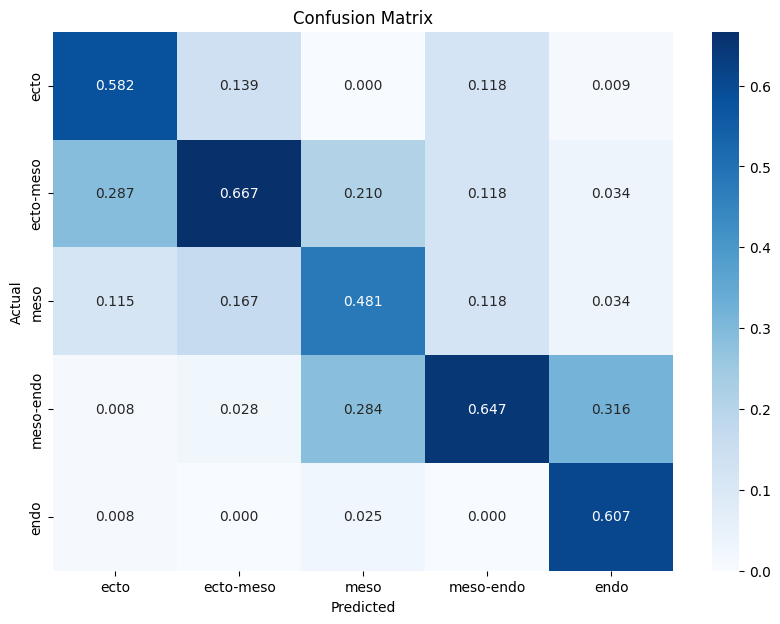

In [38]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '019'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader, threshold=0.6)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_019')
Accuracy: 0.630
Mean precision: 0.630
Mean recall: 0.658
---
ecto - precision: 0.651, recall: 0.794
ecto-meso - precision: 0.673, recall: 0.542
meso - precision: 0.552, recall: 0.567
meso-endo - precision: 0.655, recall: 0.527
endo - precision: 0.619, recall: 0.859


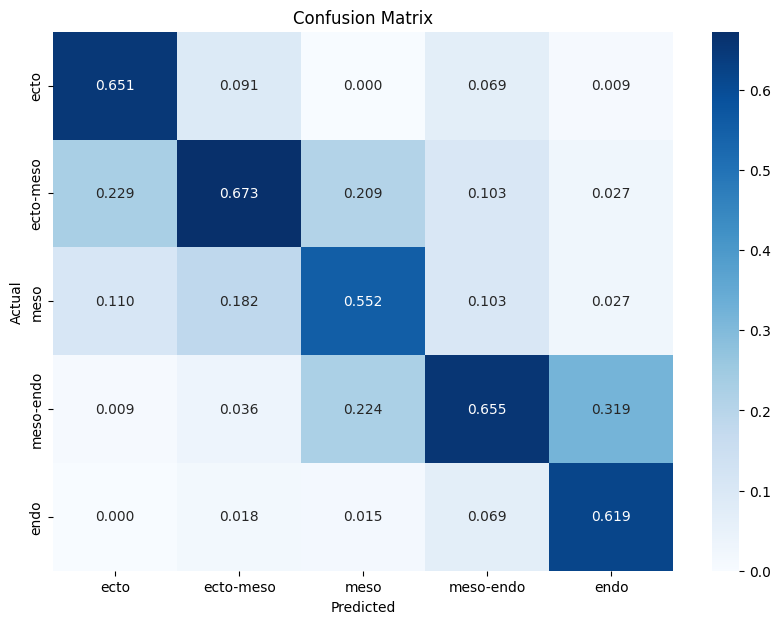

In [39]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '019'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader, threshold=0.8)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_019')
Accuracy: 0.655
Mean precision: 0.655
Mean recall: 0.679
---
ecto - precision: 0.700, recall: 0.832
ecto-meso - precision: 0.648, recall: 0.561
meso - precision: 0.611, recall: 0.576
meso-endo - precision: 0.667, recall: 0.559
endo - precision: 0.651, recall: 0.867


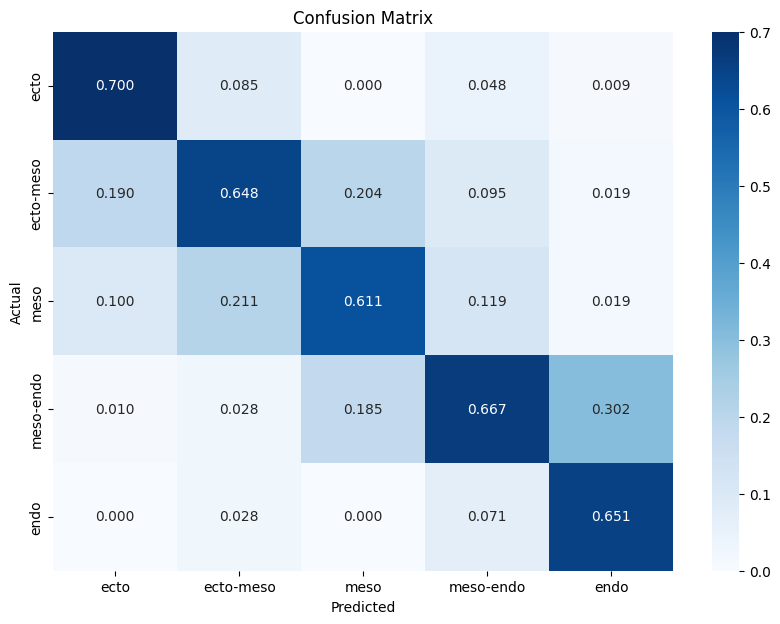

In [40]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '019'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader, threshold=0.9)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_019')
Accuracy: 0.649
Mean precision: 0.649
Mean recall: 0.669
---
ecto - precision: 0.723, recall: 0.833
ecto-meso - precision: 0.610, recall: 0.565
meso - precision: 0.651, recall: 0.573
meso-endo - precision: 0.593, recall: 0.525
endo - precision: 0.670, recall: 0.851


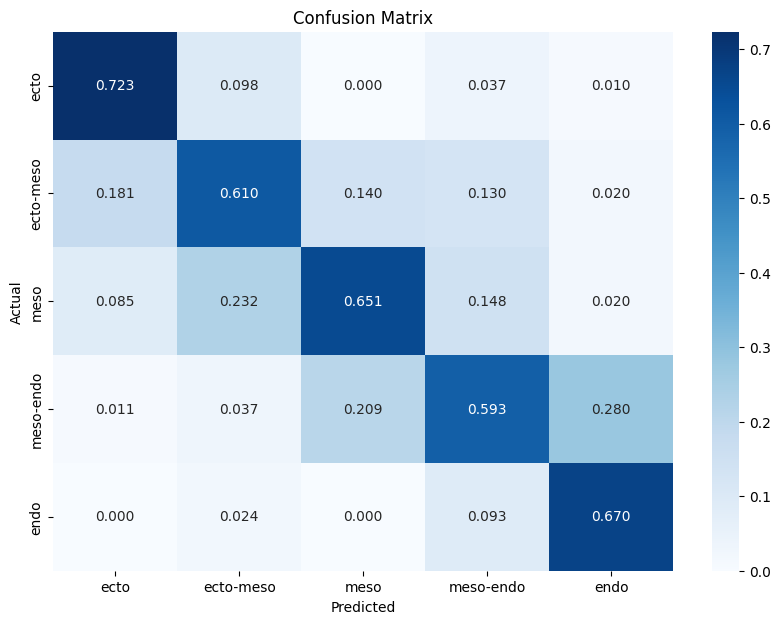

In [41]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '019'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader, threshold=0.95)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

#### 020

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced_3_classes', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_020')
Accuracy: 0.888
Mean precision: 0.888
Mean recall: 0.889
---
ecto - precision: 0.882, recall: 0.914
meso - precision: 0.850, recall: 0.830
endo - precision: 0.932, recall: 0.922


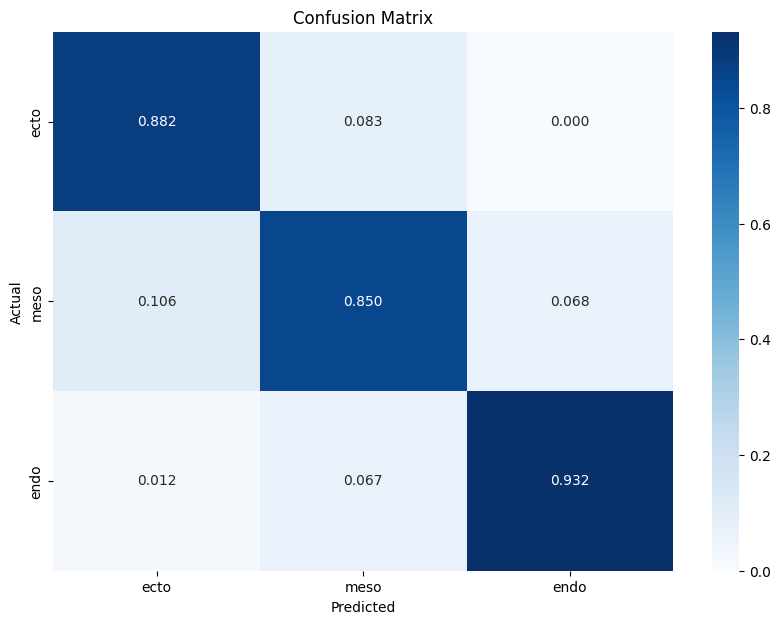

In [31]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '020'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=opt.num_classes)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, index_to_label=index_to_label_3_classes, label_to_index=label_to_index_3_classes)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_020')
Accuracy: 0.570
Mean precision: 0.570
Mean recall: 0.587
---
ecto - precision: 0.626, recall: 0.796
ecto-meso - precision: 0.531, recall: 0.482
meso - precision: 0.395, recall: 0.449
meso-endo - precision: 0.643, recall: 0.488
endo - precision: 0.657, recall: 0.718


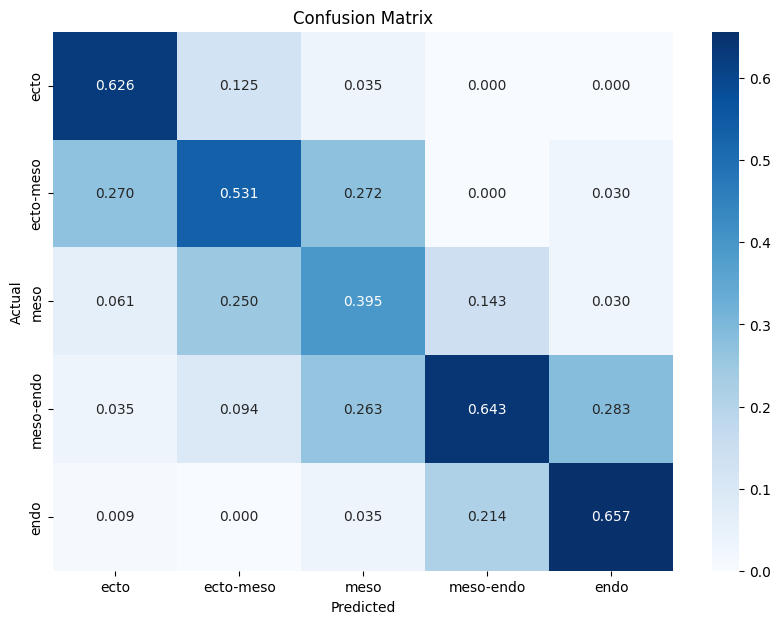

In [37]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '020'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=3, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.01, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_020')
Accuracy: 0.606
Mean precision: 0.606
Mean recall: 0.619
---
ecto - precision: 0.683, recall: 0.800
ecto-meso - precision: 0.550, recall: 0.525
meso - precision: 0.448, recall: 0.542
meso-endo - precision: 0.684, recall: 0.507
endo - precision: 0.663, recall: 0.720


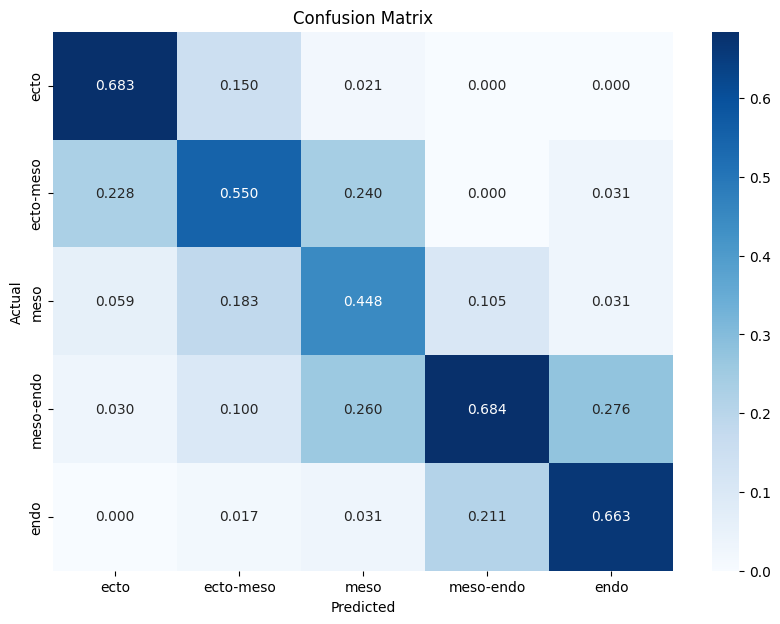

In [43]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '020'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader, threshold=0.9)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

#### 021

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDatasetV2', image_size=[3, 640, 240], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_021')
Accuracy: 0.633
Mean precision: 0.633
Mean recall: 0.635
---
ecto - precision: 0.732, recall: 0.751
ecto-meso - precision: 0.456, recall: 0.435
meso - precision: 0.600, recall: 0.599
meso-endo - precision: 0.576, recall: 0.600
endo - precision: 0.803, recall: 0.791


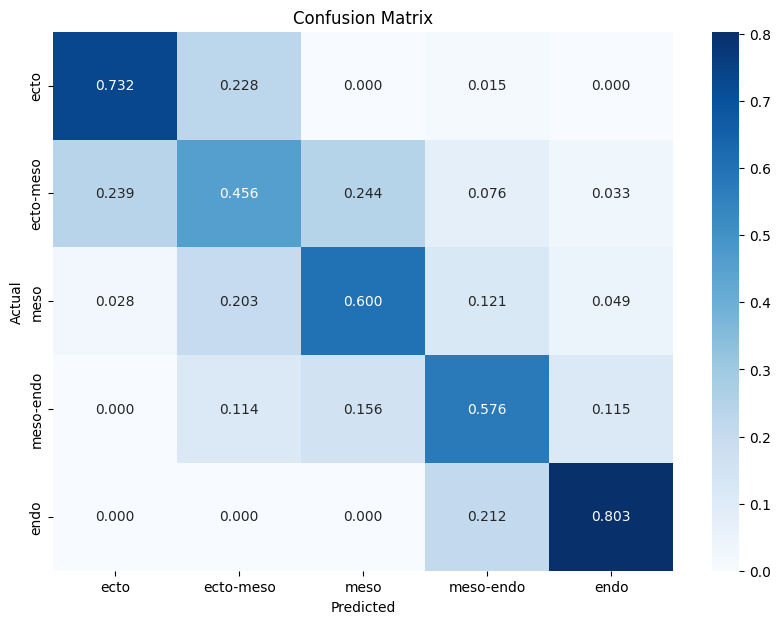

In [51]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '021'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                         
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 022

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDatasetV2', image_size=[3, 640, 240], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_022')
Accuracy: 0.651
Mean precision: 0.651
Mean recall: 0.644
---
ecto - precision: 0.852, recall: 0.747
ecto-meso - precision: 0.484, recall: 0.497
meso - precision: 0.620, recall: 0.669
meso-endo - precision: 0.500, recall: 0.575
endo - precision: 0.800, recall: 0.734


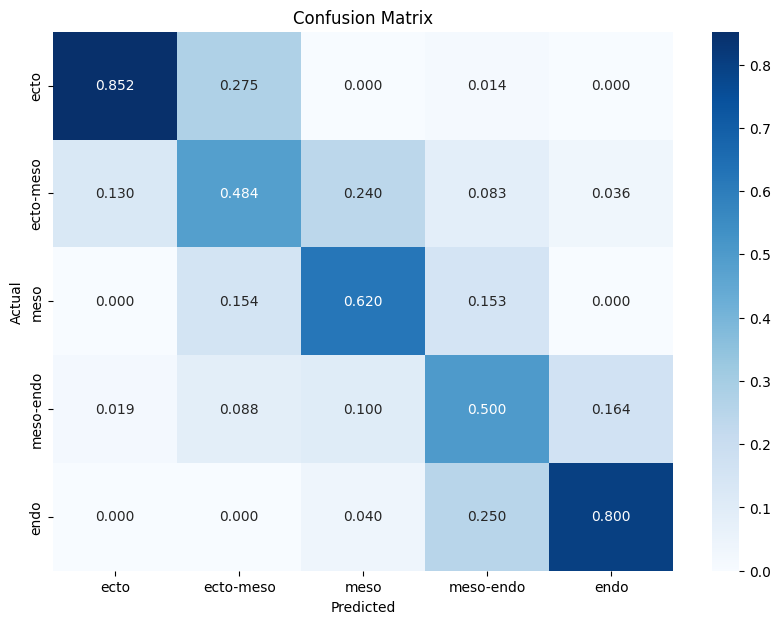

In [52]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '022'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 023

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='FrontViewDatasetV2', image_size=[3, 640, 240], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_023')
Accuracy: 0.642
Mean precision: 0.642
Mean recall: 0.635
---
ecto - precision: 0.863, recall: 0.751
ecto-meso - precision: 0.418, recall: 0.445
meso - precision: 0.653, recall: 0.705
meso-endo - precision: 0.514, recall: 0.563
endo - precision: 0.759, recall: 0.709


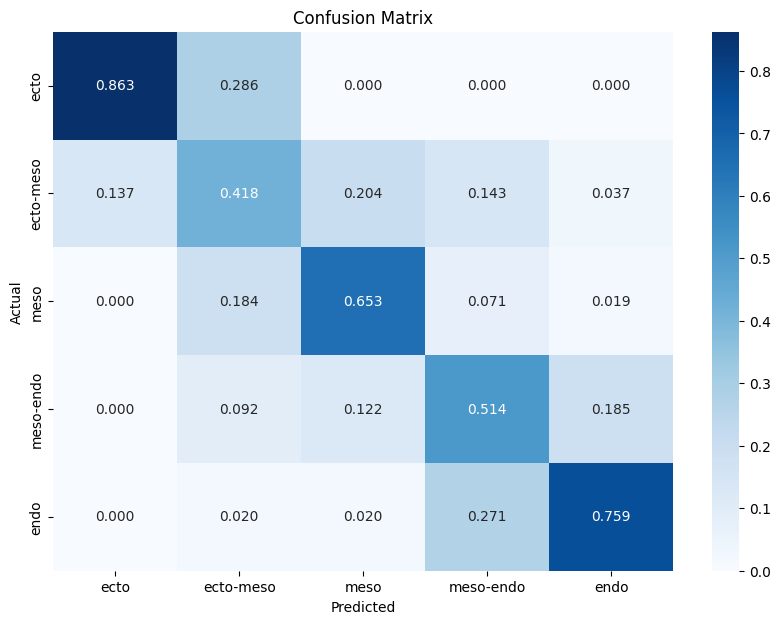

In [53]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '023'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 024

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_024')
Accuracy: 0.587
Mean precision: 0.587
Mean recall: 0.628
---
ecto - precision: 0.674, recall: 0.876
ecto-meso - precision: 0.453, recall: 0.367
meso - precision: 0.500, recall: 0.417
meso-endo - precision: 0.569, recall: 0.588
endo - precision: 0.740, recall: 0.891


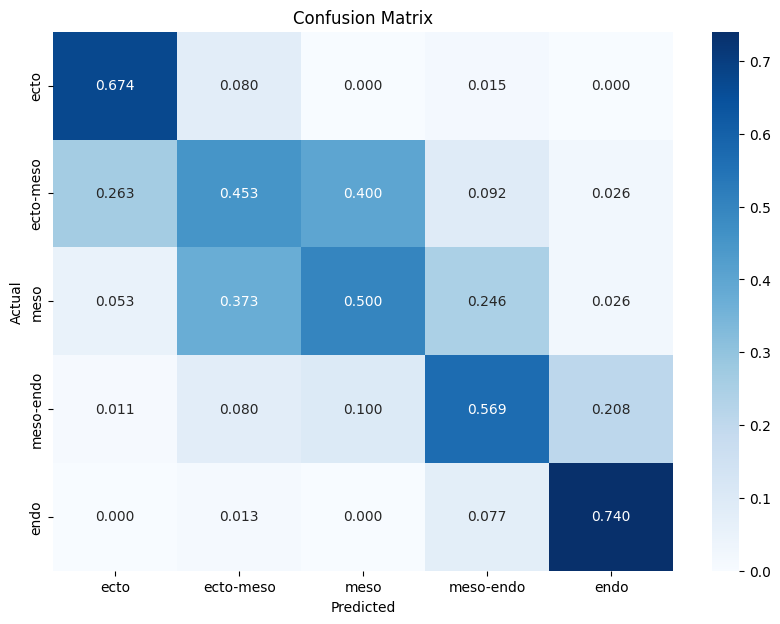

In [54]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '024'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 025

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_025')
Accuracy: 0.598
Mean precision: 0.598
Mean recall: 0.596
---
ecto - precision: 0.860, recall: 0.687
ecto-meso - precision: 0.431, recall: 0.392
meso - precision: 0.435, recall: 0.568
meso-endo - precision: 0.500, recall: 0.549
endo - precision: 0.761, recall: 0.785


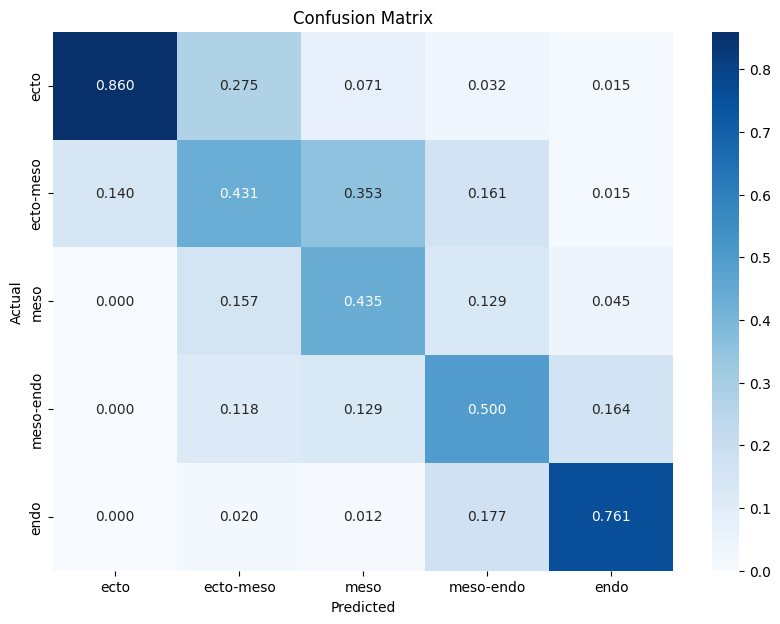

In [55]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '025'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 026

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_026')
Accuracy: 0.652
Mean precision: 0.652
Mean recall: 0.657
---
ecto - precision: 0.810, recall: 0.866
ecto-meso - precision: 0.578, recall: 0.544
meso - precision: 0.591, recall: 0.696
meso-endo - precision: 0.492, recall: 0.488
endo - precision: 0.788, recall: 0.689


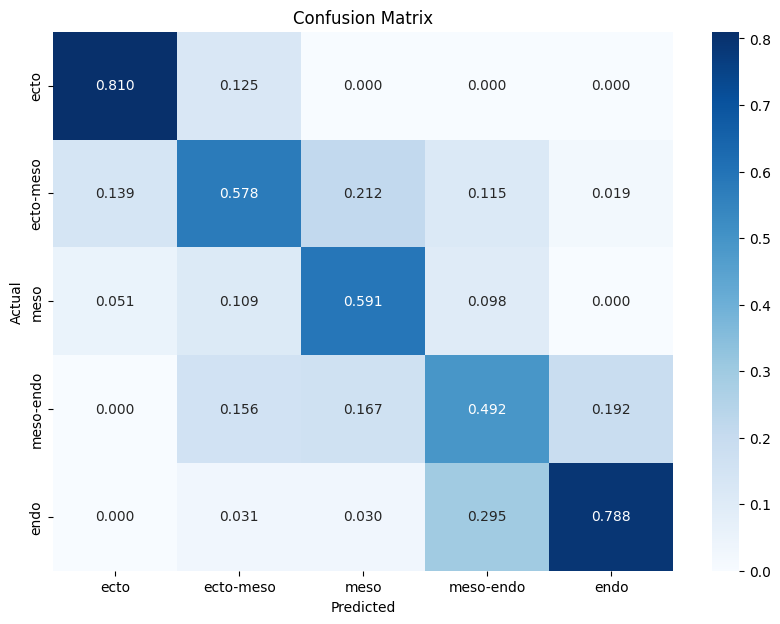

In [56]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '026'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 027

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=5, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_027')
Accuracy: 0.671
Mean precision: 0.671
Mean recall: 0.670
---
ecto - precision: 0.768, recall: 0.752
ecto-meso - precision: 0.566, recall: 0.556
meso - precision: 0.582, recall: 0.624
meso-endo - precision: 0.617, recall: 0.611
endo - precision: 0.823, recall: 0.806


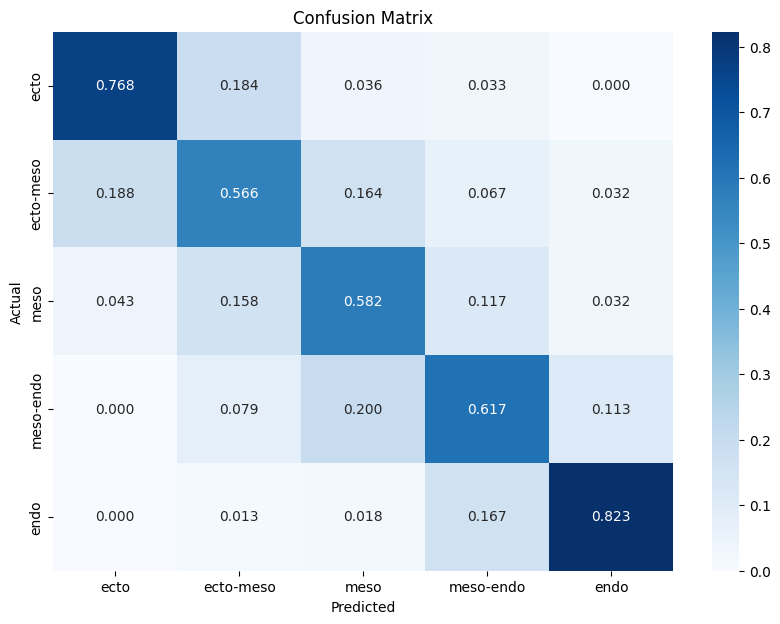

In [57]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '027'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 028

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=5, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_028')
Accuracy: 0.614
Mean precision: 0.614
Mean recall: 0.615
---
ecto - precision: 0.757, recall: 0.714
ecto-meso - precision: 0.492, recall: 0.443
meso - precision: 0.500, recall: 0.562
meso-endo - precision: 0.540, recall: 0.577
endo - precision: 0.781, recall: 0.778


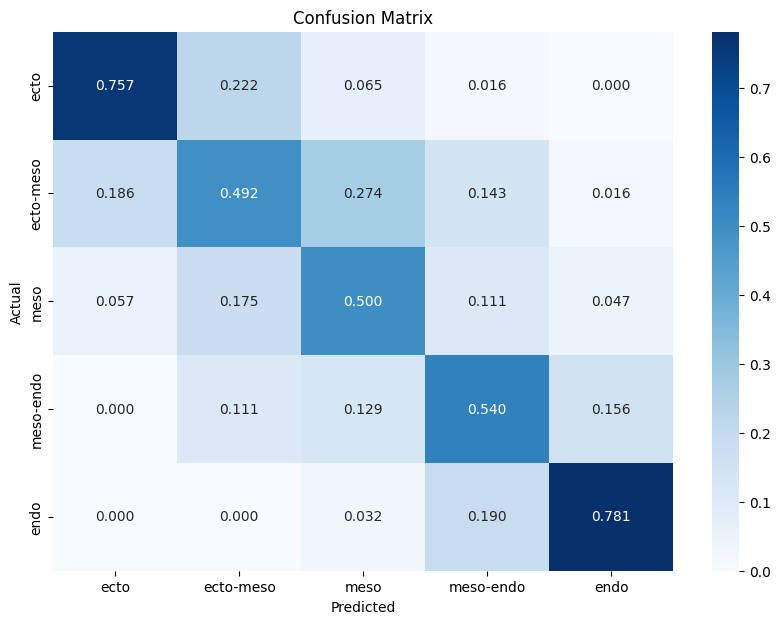

In [58]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '028'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 029

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=5, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_029')
Accuracy: 0.577
Mean precision: 0.577
Mean recall: 0.572
---
ecto - precision: 0.785, recall: 0.762
ecto-meso - precision: 0.418, recall: 0.430
meso - precision: 0.491, recall: 0.556
meso-endo - precision: 0.429, recall: 0.435
endo - precision: 0.764, recall: 0.676


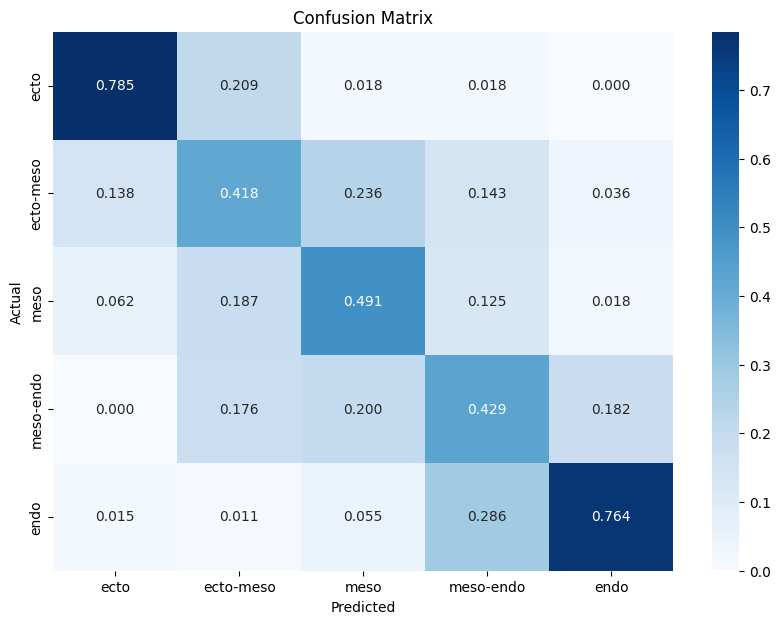

In [59]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '029'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 030



Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced_3_classes', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=3, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_030')
Accuracy: 0.888
Mean precision: 0.888
Mean recall: 0.888
---
ecto - precision: 0.923, recall: 0.886
meso - precision: 0.857, recall: 0.858
endo - precision: 0.883, recall: 0.920


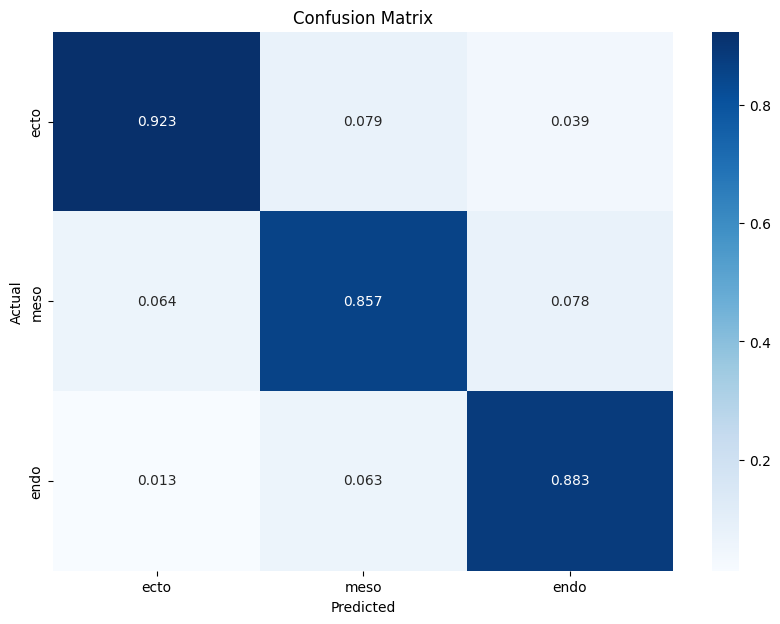

In [66]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '030'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
# dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=opt.num_classes)
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h), num_classes=opt.num_classes)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, index_to_label=index_to_label_3_classes, label_to_index=label_to_index_3_classes)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=3, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_030')
Accuracy: 0.601
Mean precision: 0.601
Mean recall: 0.611
---
ecto - precision: 0.728, recall: 0.706
ecto-meso - precision: 0.456, recall: 0.396
meso - precision: 0.581, recall: 0.593
meso-endo - precision: 0.519, recall: 0.547
endo - precision: 0.723, recall: 0.815


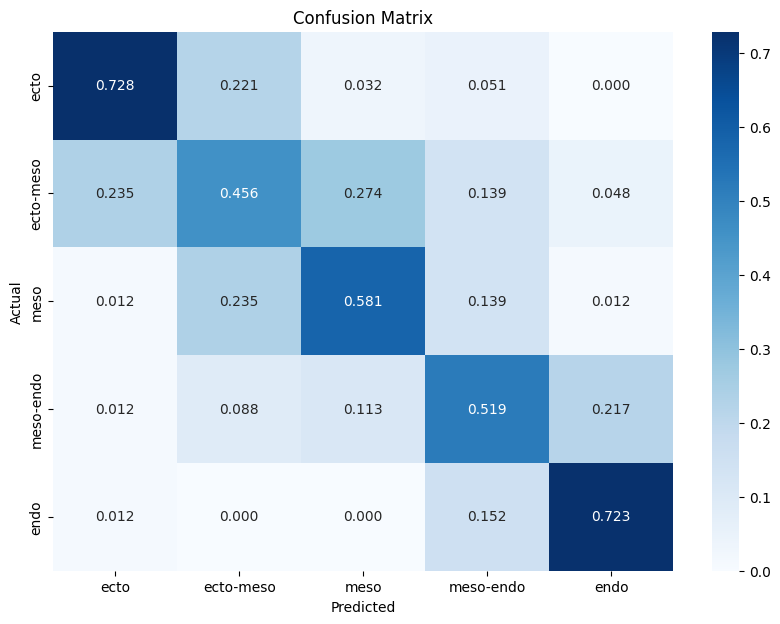

In [65]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '030'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h), num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader, threshold=0.9)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

#### 031

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced_3_classes', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=3, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_031')
Accuracy: 0.842
Mean precision: 0.842
Mean recall: 0.845
---
ecto - precision: 0.818, recall: 0.872
meso - precision: 0.811, recall: 0.757
endo - precision: 0.896, recall: 0.905


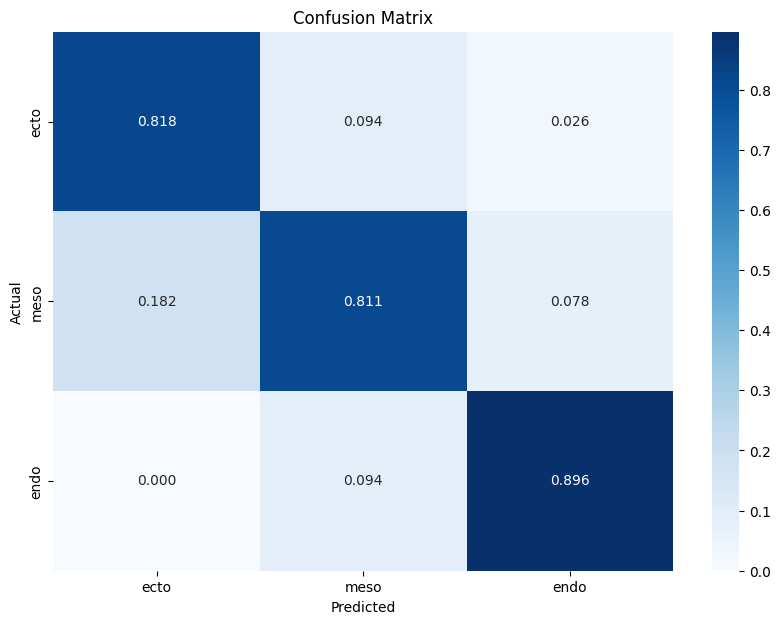

In [63]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '031'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
# dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=opt.num_classes)
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h), num_classes=opt.num_classes)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, index_to_label=index_to_label_3_classes, label_to_index=label_to_index_3_classes)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=3, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_031')
Accuracy: 0.598
Mean precision: 0.598
Mean recall: 0.599
---
ecto - precision: 0.770, recall: 0.741
ecto-meso - precision: 0.494, recall: 0.464
meso - precision: 0.449, recall: 0.502
meso-endo - precision: 0.547, recall: 0.523
endo - precision: 0.728, recall: 0.762


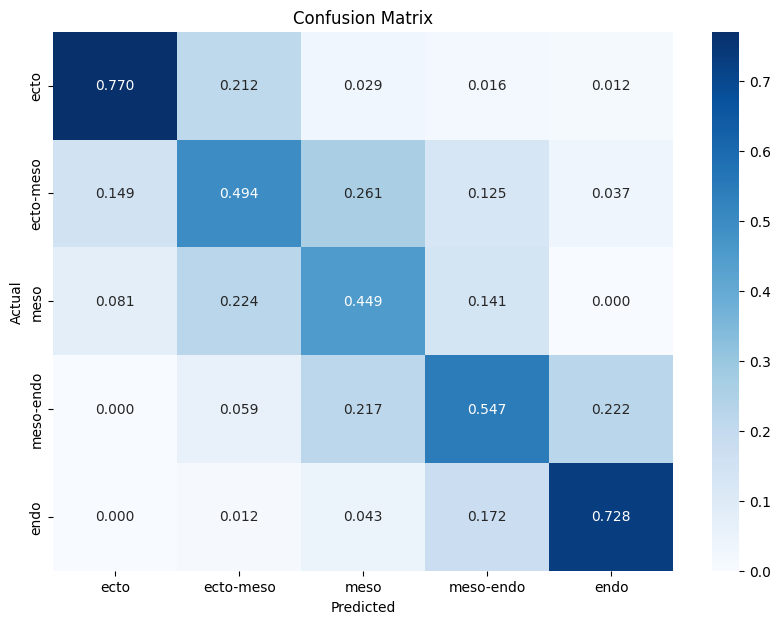

In [64]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '031'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h), num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader, threshold=0.9)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=3, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_031')
Accuracy: 0.570
Mean precision: 0.570
Mean recall: 0.561
---
ecto - precision: 0.820, recall: 0.693
ecto-meso - precision: 0.403, recall: 0.403
meso - precision: 0.465, recall: 0.559
meso-endo - precision: 0.412, recall: 0.525
endo - precision: 0.750, recall: 0.624


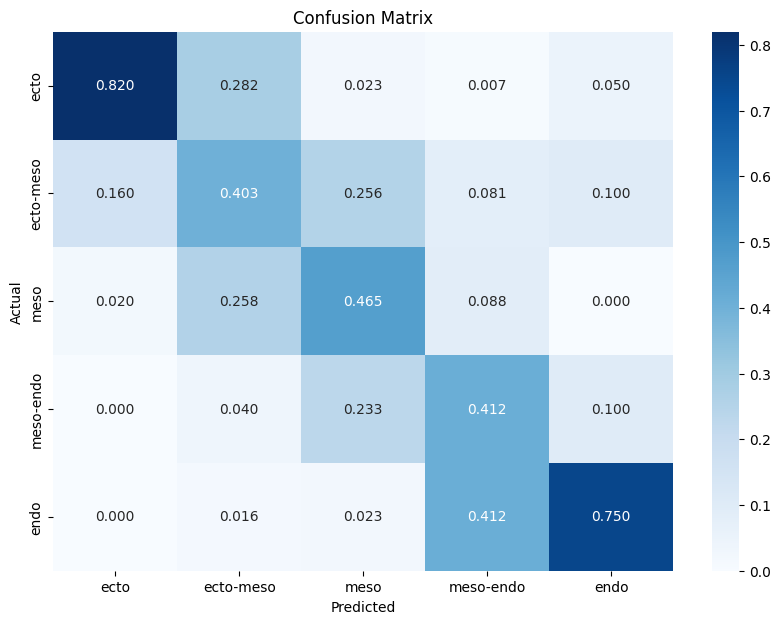

In [35]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '031'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h), num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_classes_to_linear_3_to_5(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, index_to_label=index_to_label, label_to_index=label_to_index)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced_3_classes', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=3, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_031')
Accuracy: 0.811
Mean precision: 0.811
Mean recall: 0.823
---
ecto - precision: 0.725, recall: 0.870
meso - precision: 0.833, recall: 0.696
endo - precision: 0.875, recall: 0.904


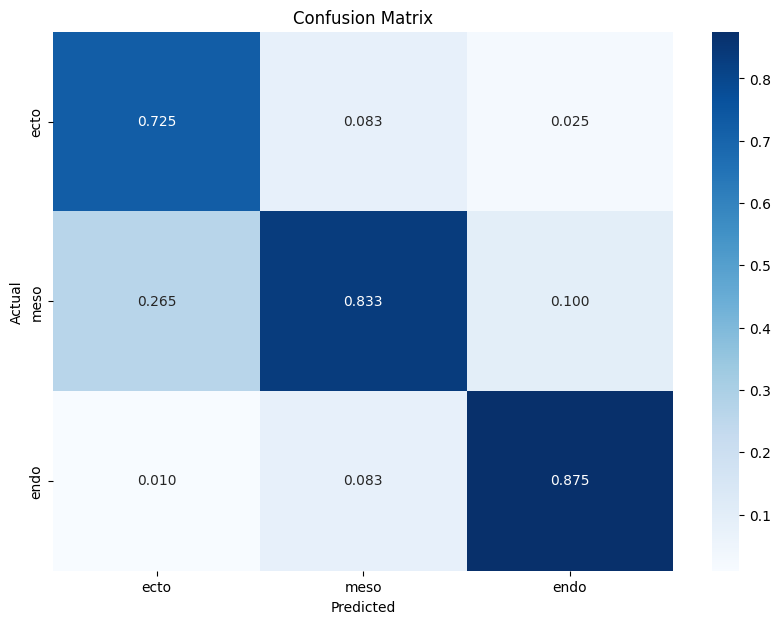

In [37]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '031'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
# dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=opt.num_classes)
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h), num_classes=opt.num_classes)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_classes_to_linear(model, dataloader, num_classes=3)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, index_to_label=index_to_label_3_classes, label_to_index=label_to_index_3_classes)

#### 032

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced_3_classes', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=3, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_032')
Accuracy: 0.869
Mean precision: 0.869
Mean recall: 0.871
---
ecto - precision: 0.871, recall: 0.895
meso - precision: 0.839, recall: 0.792
endo - precision: 0.896, recall: 0.926


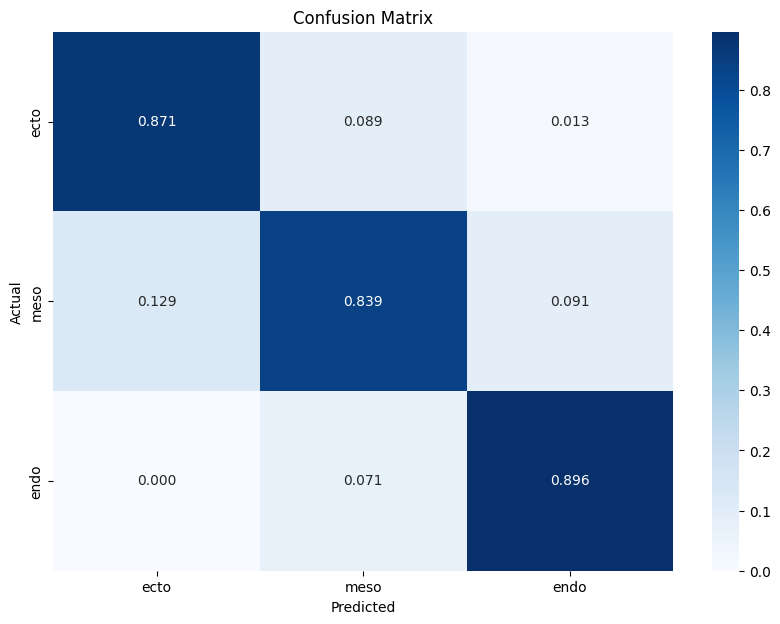

In [68]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '032'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
# dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, num_classes=opt.num_classes)
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h), num_classes=opt.num_classes)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, index_to_label=index_to_label_3_classes, label_to_index=label_to_index_3_classes)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced_3_classes_eval_5', dataset='ThreeViewsDatasetV2', image_size=[3, 224, 224], num_classes=3, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_032')
Accuracy: 0.631
Mean precision: 0.631
Mean recall: 0.641
---
ecto - precision: 0.750, recall: 0.770
ecto-meso - precision: 0.526, recall: 0.473
meso - precision: 0.538, recall: 0.563
meso-endo - precision: 0.627, recall: 0.572
endo - precision: 0.711, recall: 0.826


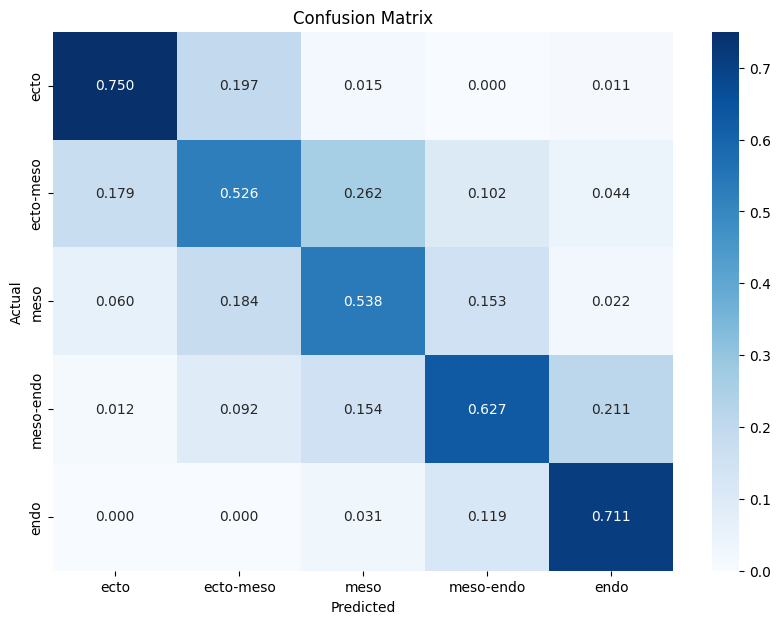

In [69]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '032'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
opt.split = 'full_balanced_3_classes_eval_5'
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h), num_classes=5)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_3_to_5_classes(model, dataloader, threshold=0.9)

# Trace matrice de confusion
plot_confusion_matrix([label_to_index_full[pred] for pred in predictions], [label_to_index[target] for target in targets], index_to_label=index_to_label, label_to_index=label_to_index)

#### 033

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDatasetV2', image_size=[3, 384, 384], num_classes=5, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_033')
Accuracy: 0.662
Mean precision: 0.662
Mean recall: 0.665
---
ecto - precision: 0.735, recall: 0.821
ecto-meso - precision: 0.594, recall: 0.549
meso - precision: 0.564, recall: 0.592
meso-endo - precision: 0.600, recall: 0.588
endo - precision: 0.817, recall: 0.777


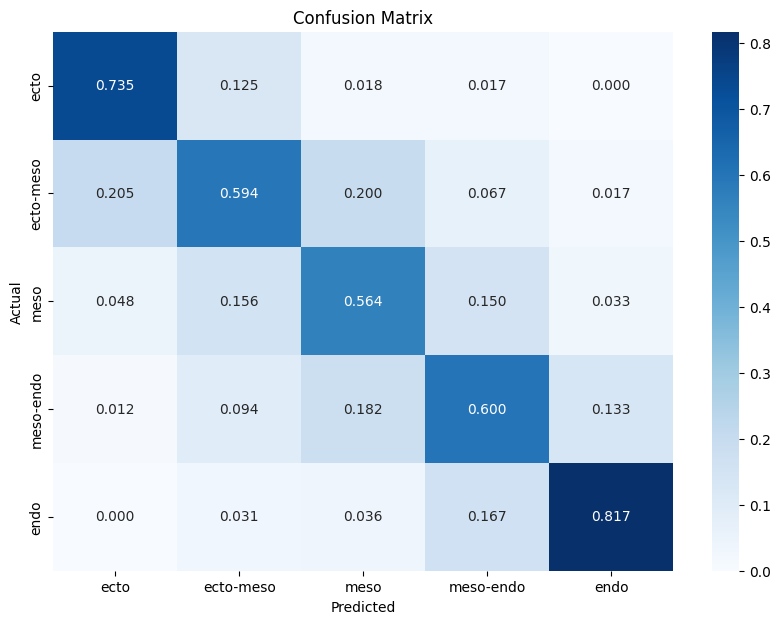

In [70]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '033'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 034

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDatasetV2', image_size=[3, 384, 384], num_classes=5, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_034')
Accuracy: 0.650
Mean precision: 0.650
Mean recall: 0.649
---
ecto - precision: 0.773, recall: 0.742
ecto-meso - precision: 0.427, recall: 0.412
meso - precision: 0.574, recall: 0.629
meso-endo - precision: 0.621, recall: 0.637
endo - precision: 0.855, recall: 0.826


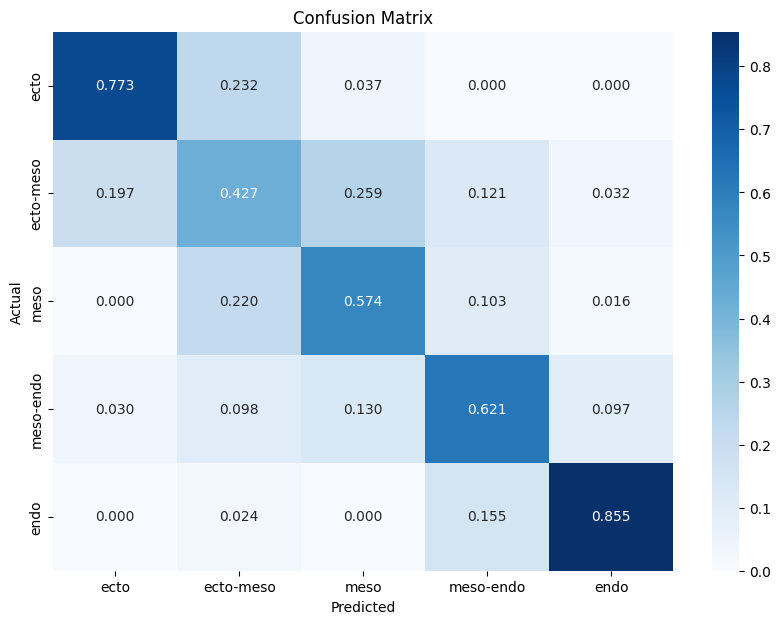

In [71]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '034'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 035

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='ThreeViewsDatasetV2', image_size=[3, 384, 384], num_classes=5, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_035')
Accuracy: 0.596
Mean precision: 0.596
Mean recall: 0.595
---
ecto - precision: 0.818, recall: 0.774
ecto-meso - precision: 0.427, recall: 0.411
meso - precision: 0.528, recall: 0.572
meso-endo - precision: 0.474, recall: 0.484
endo - precision: 0.734, recall: 0.734


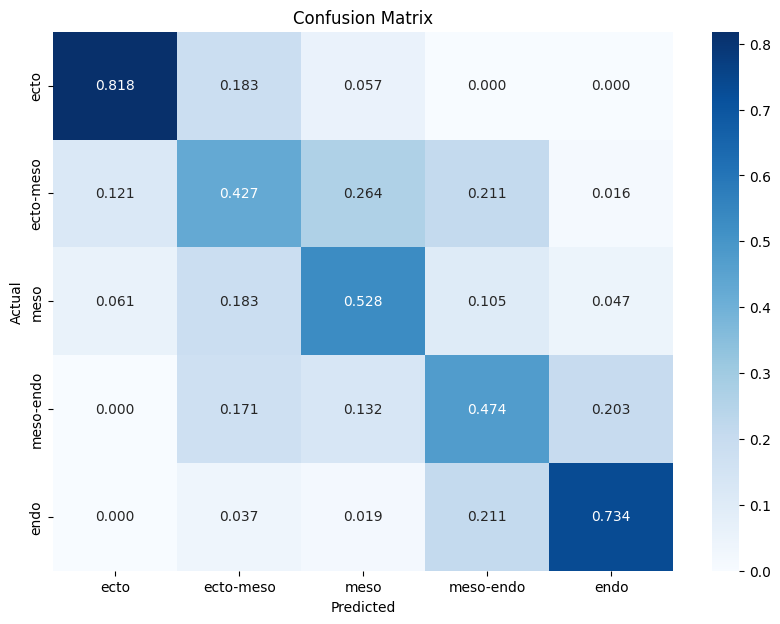

In [30]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '035'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

In [31]:
def evaluate_model_classes_to_linear(model, dataloader, num_classes=5):
    correct = 0
    total = 0
    list_predictions = []
    list_targets = []
    class_indices = torch.arange(num_classes)
    # class_weights = torch.tensor([1.5,1,2,1,1.5]) 
    # class_weights = class_weights / torch.sum(class_weights) * 5
    sigmoid = torch.nn.Sigmoid()
    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(DEVICE_MODE), targets.to(DEVICE_MODE)
            outputs = model(inputs)
            weighted_sum = torch.sum(class_indices * sigmoid(outputs) * sigmoid(outputs) / torch.sum(sigmoid(outputs), 1), 1)
            # predicted = (weighted_sum / (len(class_indices) - 1)).int()
            predicted = (weighted_sum / (len(class_indices) - 1) * len(class_indices)).int()
            # predicted = weighted_sum.int()
            # _, predicted = torch.max(outputs, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
            
            list_predictions.append(predicted[0].item())
            list_targets.append(targets[0].item())

            # print(weighted_sum)
            # print(predicted)
            # print(torch.sum(sigmoid(outputs) / torch.sum(sigmoid(outputs), 1),1))
            # break
    
    
    accuracy = correct / total
    
    return accuracy, list_predictions, list_targets

# accuracy, predictions, targets = evaluate_model_classes_to_linear(model, dataloader)

Namespace(model_name='convnext_tiny', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='ThreeViewsDatasetV2', image_size=[3, 384, 384], num_classes=5, drop_rate=0.0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, progressive_unfreeze=False, progressive_unfreeze_step=1, earlyStopping_min_delta=0.0, earlyStopping_patience=10, linear_target=False, device='cuda', data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='convnext_tiny_035')
Accuracy: 0.579
Mean precision: 0.579
Mean recall: 0.563
---
ecto - precision: 0.812, recall: 0.690
ecto-meso - precision: 0.367, recall: 0.498
meso - precision: 0.375, recall: 0.585
meso-endo - precision: 0.341, recall: 0.442
endo - precision: 1.000, recall: 0.598


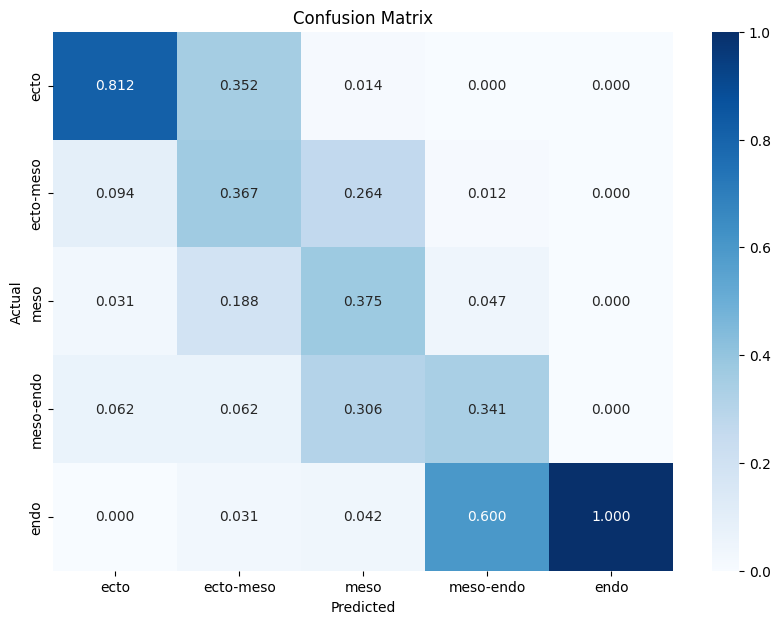

In [32]:
# Variables
model_name = 'convnext_tiny'
log_name = model_name + '_' + '035'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
        ])

# Load Dataset
dataloader = load_dataset_V2(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform, (w,h))

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model_classes_to_linear(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

# evaluate_model_classes_to_linear(model, dataloader, num_classes=5)

### ResNet50d

#### 001

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_001')
Accuracy: 0.475
Mean precision: 0.475
Mean recall: 0.477
---
ecto - precision: 0.468, recall: 0.530
ecto-meso - precision: 0.380, recall: 0.381
meso - precision: 0.432, recall: 0.435
meso-endo - precision: 0.460, recall: 0.414
endo - precision: 0.635, recall: 0.626


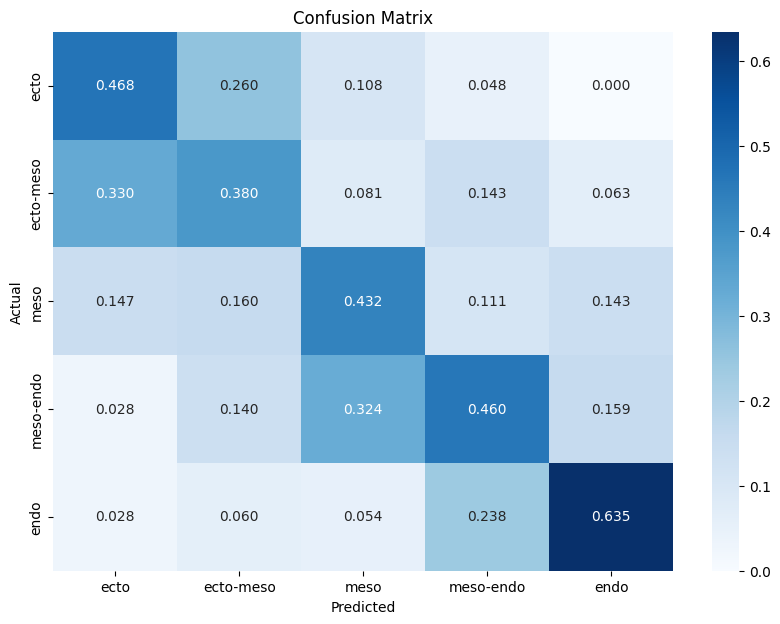

In [102]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '001'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 002

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_002')
Accuracy: 0.478
Mean precision: 0.478
Mean recall: 0.481
---
ecto - precision: 0.486, recall: 0.531
ecto-meso - precision: 0.577, recall: 0.449
meso - precision: 0.365, recall: 0.419
meso-endo - precision: 0.371, recall: 0.368
endo - precision: 0.589, recall: 0.638


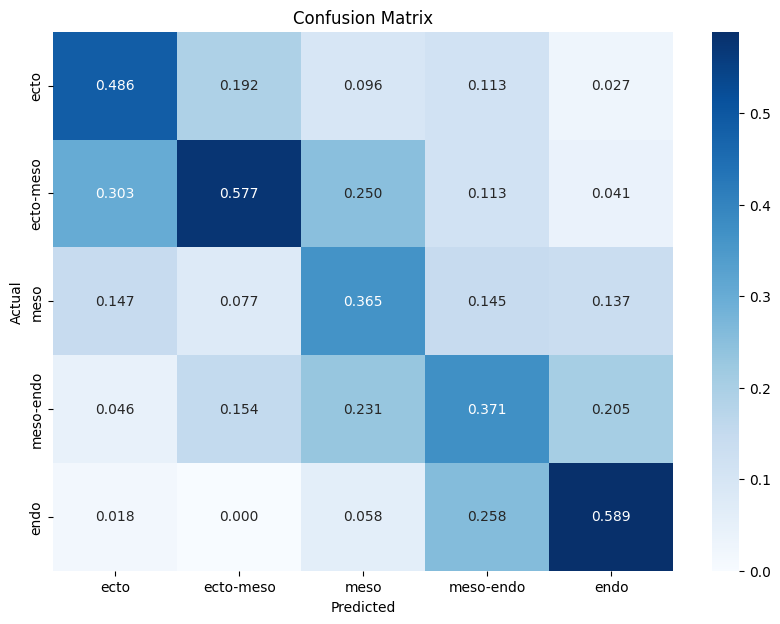

In [103]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '002'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 003

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_003')
Accuracy: 0.491
Mean precision: 0.491
Mean recall: 0.496
---
ecto - precision: 0.571, recall: 0.640
ecto-meso - precision: 0.341, recall: 0.340
meso - precision: 0.447, recall: 0.461
meso-endo - precision: 0.455, recall: 0.409
endo - precision: 0.642, recall: 0.628


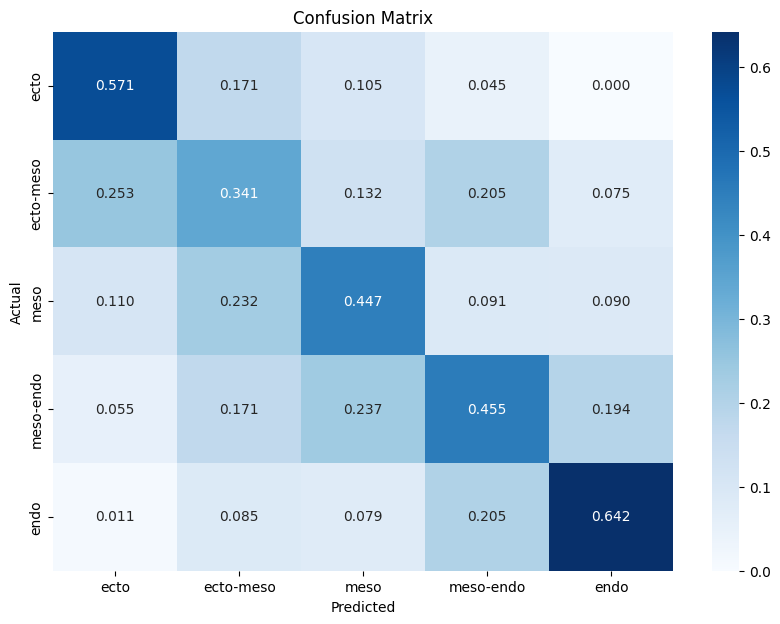

In [104]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '003'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 004

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 5, 6, 7, 8], val_folds=[9], test_folds=[4], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_004')
Accuracy: 0.510
Mean precision: 0.510
Mean recall: 0.535
---
ecto - precision: 0.580, recall: 0.548
ecto-meso - precision: 0.373, recall: 0.322
meso - precision: 0.500, recall: 0.427
meso-endo - precision: 0.478, recall: 0.550
endo - precision: 0.620, recall: 0.829


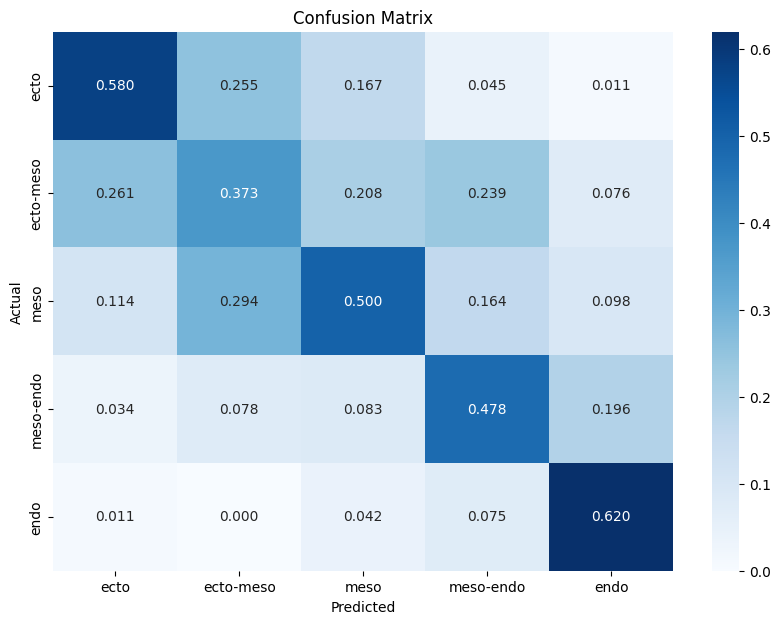

In [105]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '004'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 005

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 3, 4, 5, 6, 7, 9], val_folds=[2], test_folds=[8], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_005')
Accuracy: 0.455
Mean precision: 0.455
Mean recall: 0.466
---
ecto - precision: 0.517, recall: 0.658
ecto-meso - precision: 0.360, recall: 0.311
meso - precision: 0.254, recall: 0.272
meso-endo - precision: 0.532, recall: 0.468
endo - precision: 0.612, recall: 0.620


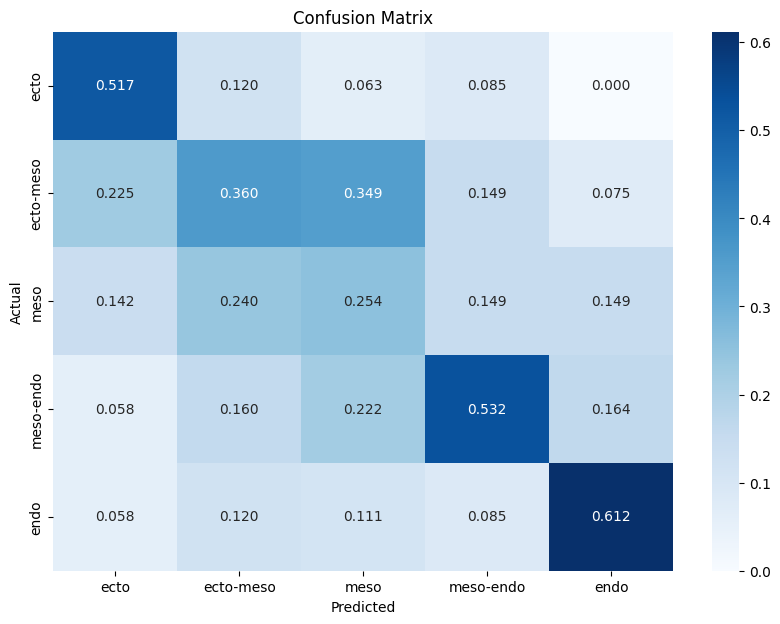

In [106]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '005'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 006

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 5, 7, 8, 9], val_folds=[0], test_folds=[6], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_006')
Accuracy: 0.447
Mean precision: 0.447
Mean recall: 0.458
---
ecto - precision: 0.455, recall: 0.629
ecto-meso - precision: 0.387, recall: 0.344
meso - precision: 0.378, recall: 0.370
meso-endo - precision: 0.345, recall: 0.333
endo - precision: 0.672, recall: 0.614


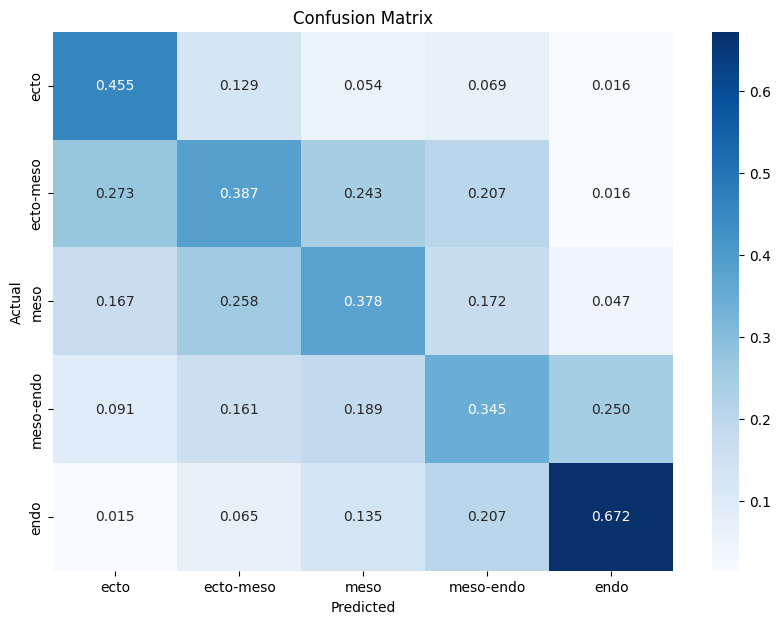

In [107]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '006'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 007

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_007')
Accuracy: 0.598
Mean precision: 0.598
Mean recall: 0.594
---
ecto - precision: 0.708, recall: 0.762
ecto-meso - precision: 0.426, recall: 0.447
meso - precision: 0.438, recall: 0.491
meso-endo - precision: 0.627, recall: 0.567
endo - precision: 0.789, recall: 0.705


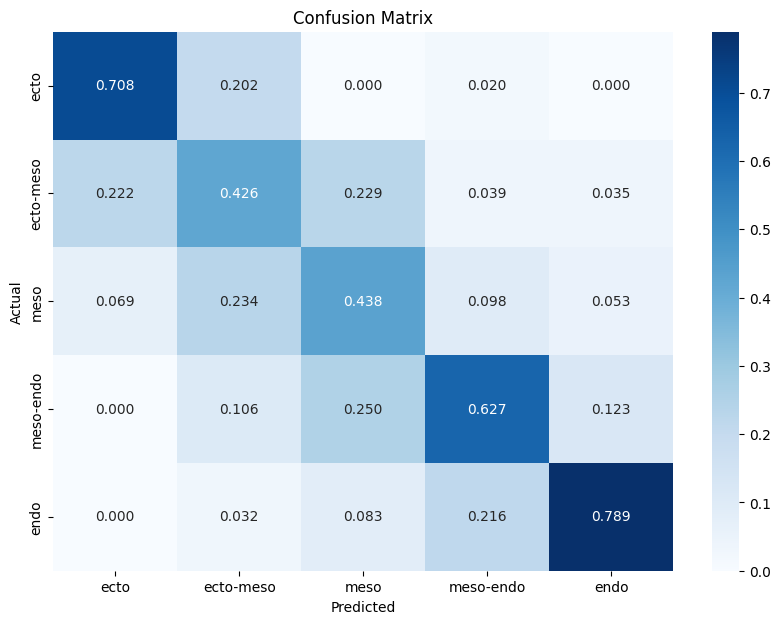

In [108]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '007'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 007 bis

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_007_bis')
Accuracy: 0.598
Mean precision: 0.598
Mean recall: 0.594
---
ecto - precision: 0.708, recall: 0.762
ecto-meso - precision: 0.426, recall: 0.447
meso - precision: 0.438, recall: 0.491
meso-endo - precision: 0.627, recall: 0.567
endo - precision: 0.789, recall: 0.705


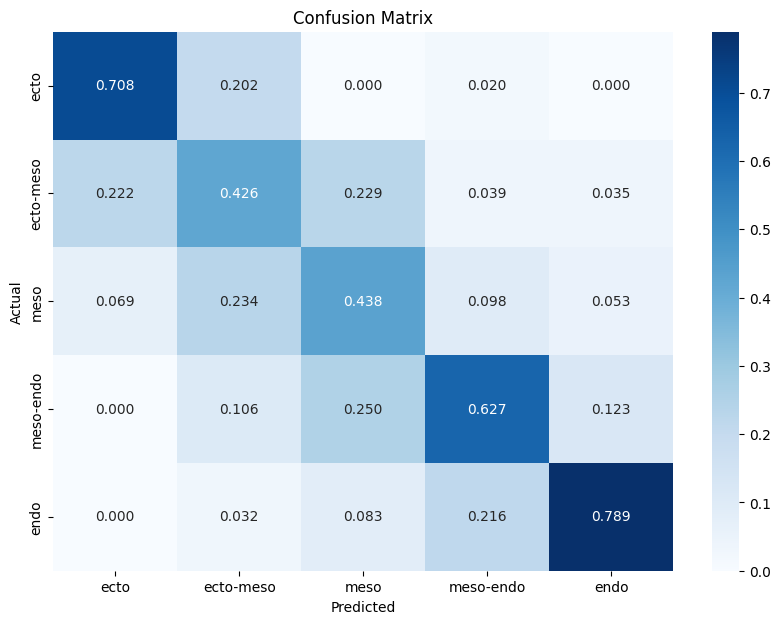

In [109]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '007_bis'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_007_bis')
Accuracy: 0.605
Mean precision: 0.605
Mean recall: 0.609
---
ecto - precision: 0.704, recall: 0.685
ecto-meso - precision: 0.456, recall: 0.438
meso - precision: 0.490, recall: 0.517
meso-endo - precision: 0.667, recall: 0.604
endo - precision: 0.707, recall: 0.804


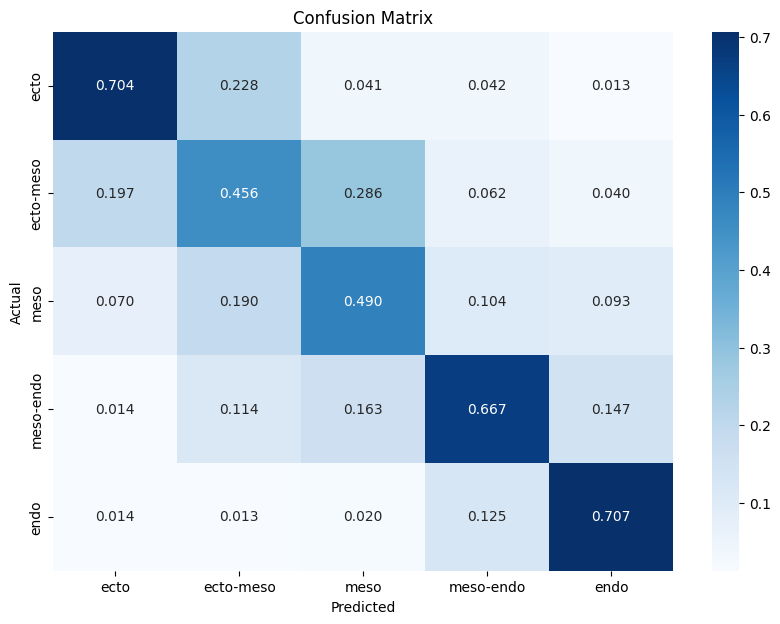

In [114]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '007_bis'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.val_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 008

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_008')
Accuracy: 0.536
Mean precision: 0.536
Mean recall: 0.541
---
ecto - precision: 0.647, recall: 0.721
ecto-meso - precision: 0.417, recall: 0.395
meso - precision: 0.512, recall: 0.496
meso-endo - precision: 0.386, recall: 0.383
endo - precision: 0.716, recall: 0.711


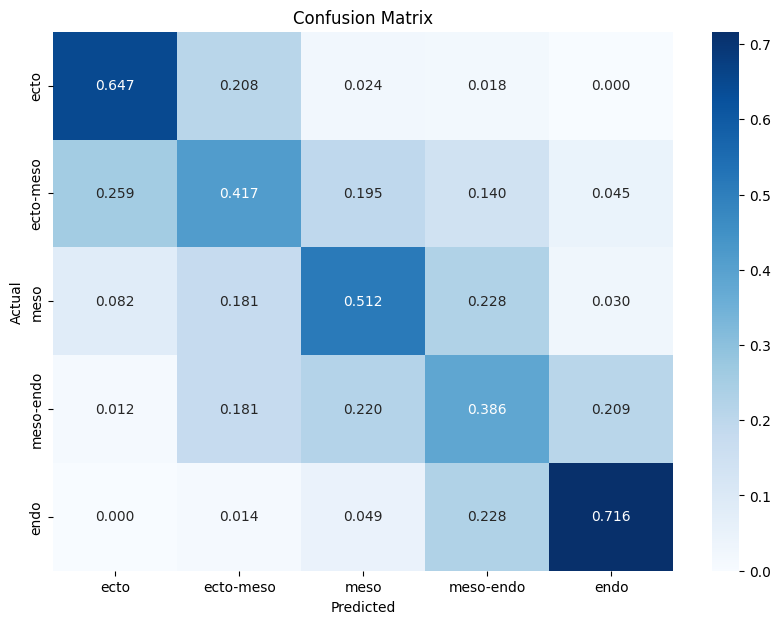

In [115]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '008'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 009

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_009')
Accuracy: 0.563
Mean precision: 0.563
Mean recall: 0.563
---
ecto - precision: 0.783, recall: 0.773
ecto-meso - precision: 0.400, recall: 0.388
meso - precision: 0.489, recall: 0.514
meso-endo - precision: 0.453, recall: 0.457
endo - precision: 0.692, recall: 0.682


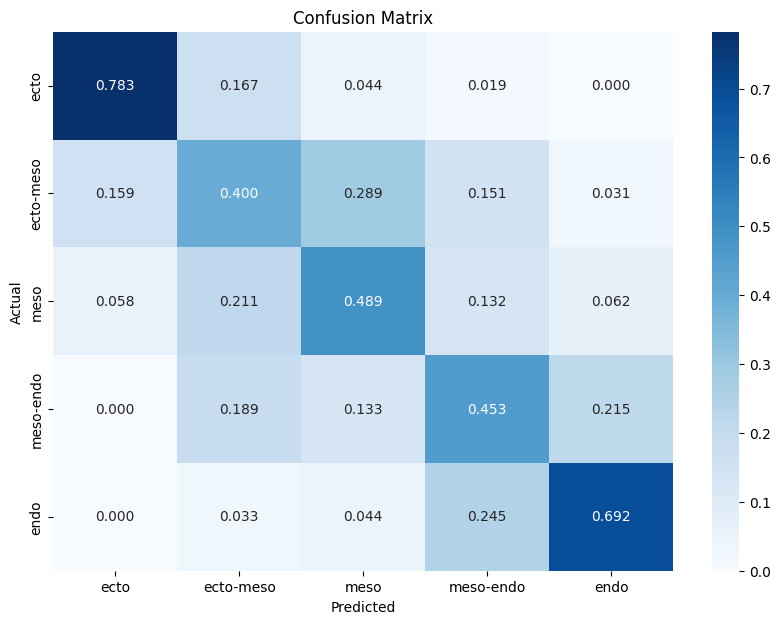

In [116]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '009'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 010

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 5, 6, 7, 8], val_folds=[9], test_folds=[4], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_010')
Accuracy: 0.592
Mean precision: 0.592
Mean recall: 0.597
---
ecto - precision: 0.625, recall: 0.724
ecto-meso - precision: 0.450, recall: 0.454
meso - precision: 0.553, recall: 0.562
meso-endo - precision: 0.618, recall: 0.526
endo - precision: 0.712, recall: 0.721


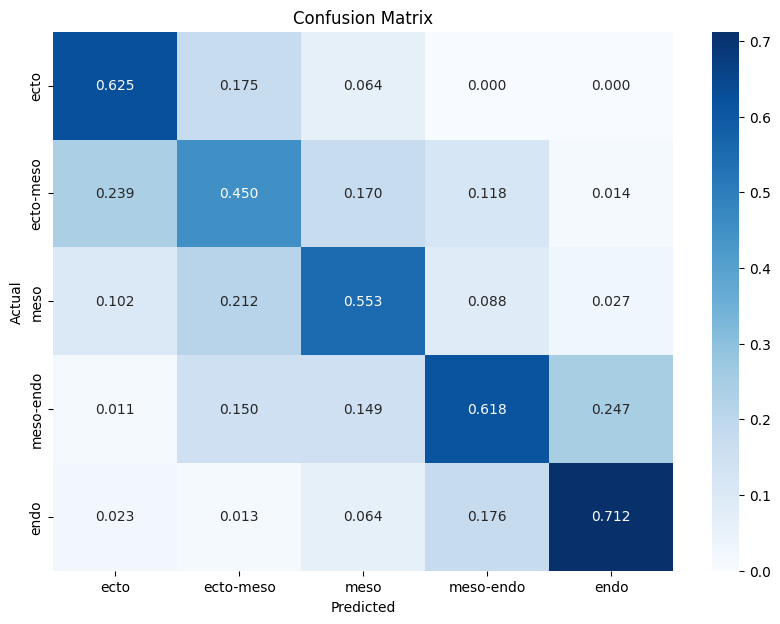

In [117]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '010'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 011

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 3, 4, 5, 6, 7, 9], val_folds=[2], test_folds=[8], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_011')
Accuracy: 0.522
Mean precision: 0.522
Mean recall: 0.533
---
ecto - precision: 0.647, recall: 0.670
ecto-meso - precision: 0.433, recall: 0.387
meso - precision: 0.429, recall: 0.431
meso-endo - precision: 0.469, recall: 0.445
endo - precision: 0.633, recall: 0.731


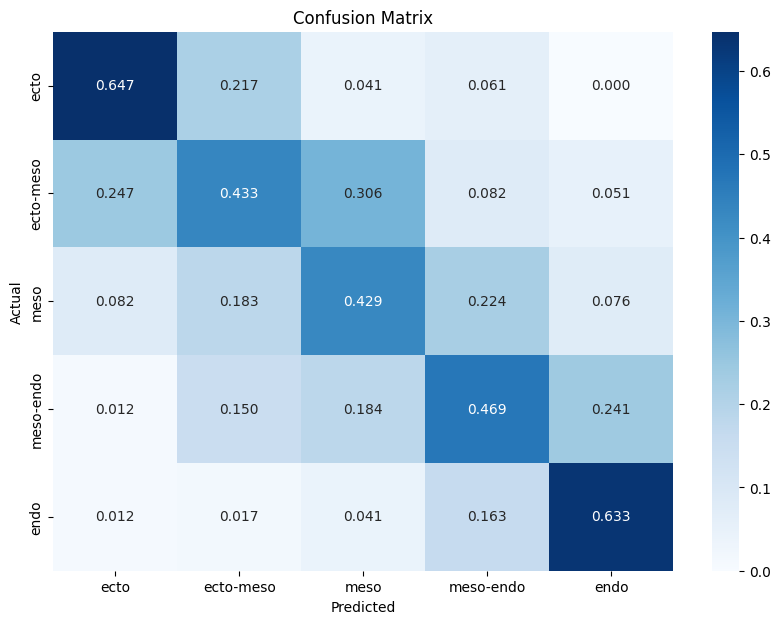

In [118]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '011'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 012

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 5, 7, 8, 9], val_folds=[0], test_folds=[6], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_012')
Accuracy: 0.579
Mean precision: 0.579
Mean recall: 0.584
---
ecto - precision: 0.806, recall: 0.682
ecto-meso - precision: 0.485, recall: 0.447
meso - precision: 0.571, recall: 0.529
meso-endo - precision: 0.413, recall: 0.485
endo - precision: 0.619, recall: 0.776


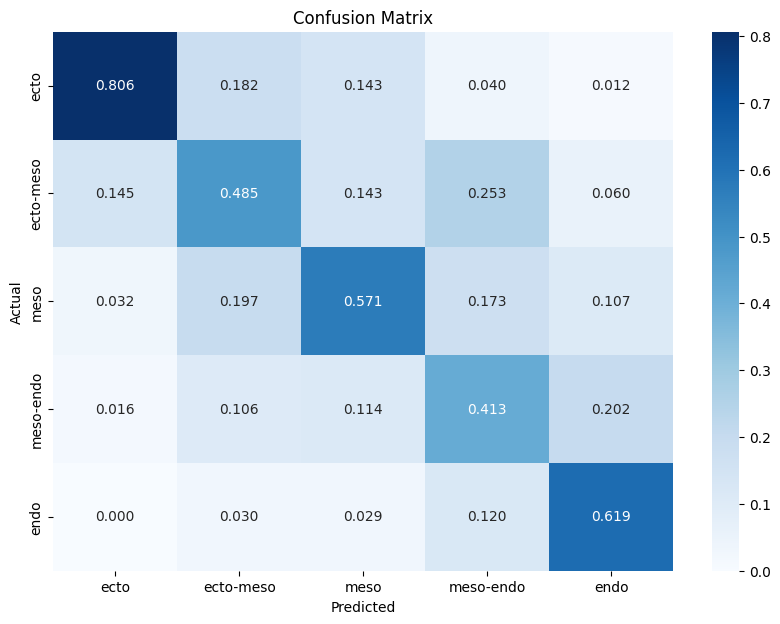

In [119]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '012'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 013

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_013')
Accuracy: 0.591
Mean precision: 0.591
Mean recall: 0.592
---
ecto - precision: 0.771, recall: 0.774
ecto-meso - precision: 0.417, recall: 0.400
meso - precision: 0.449, recall: 0.482
meso-endo - precision: 0.491, recall: 0.478
endo - precision: 0.828, recall: 0.825


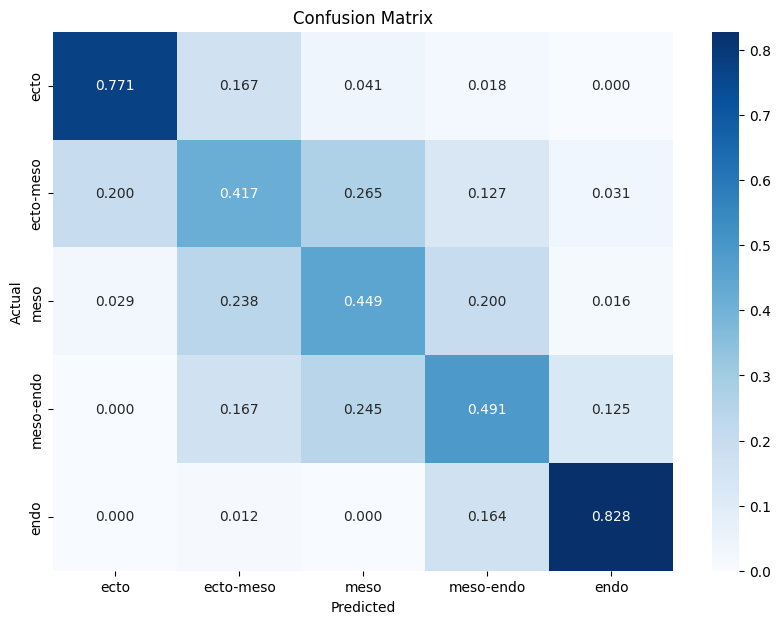

In [120]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '013'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 014

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_014')
Accuracy: 0.536
Mean precision: 0.536
Mean recall: 0.540
---
ecto - precision: 0.693, recall: 0.687
ecto-meso - precision: 0.328, recall: 0.295
meso - precision: 0.459, recall: 0.504
meso-endo - precision: 0.436, recall: 0.446
endo - precision: 0.761, recall: 0.768


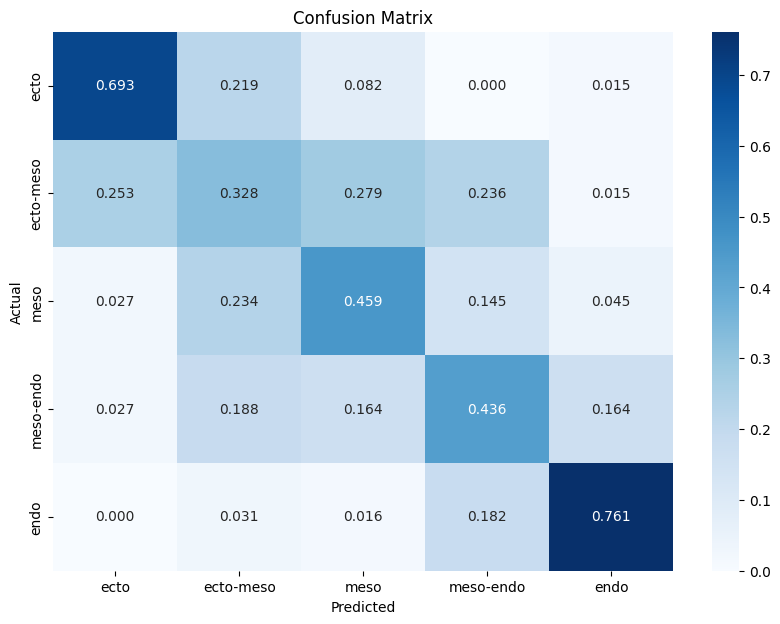

In [121]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '014'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 015

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_015')
Accuracy: 0.578
Mean precision: 0.578
Mean recall: 0.584
---
ecto - precision: 0.707, recall: 0.798
ecto-meso - precision: 0.422, recall: 0.418
meso - precision: 0.522, recall: 0.520
meso-endo - precision: 0.511, recall: 0.476
endo - precision: 0.727, recall: 0.707


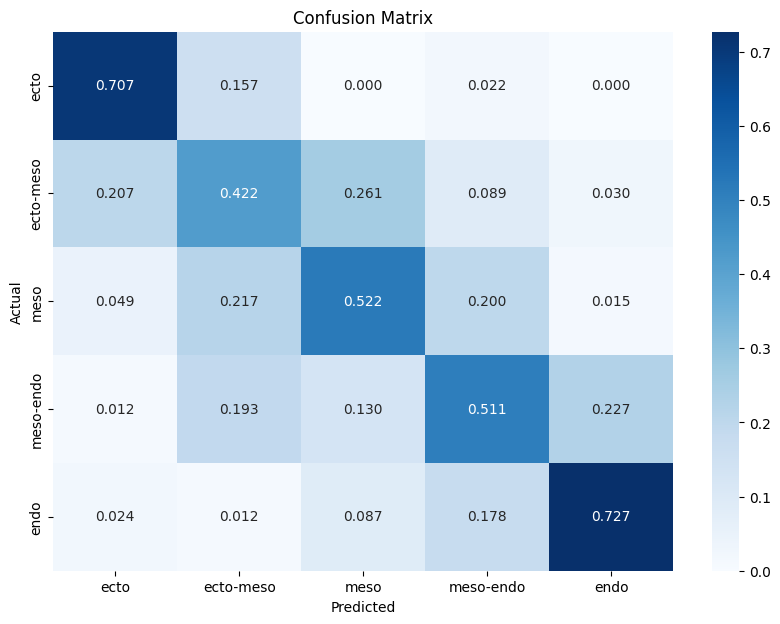

In [122]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '015'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 016

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 5, 6, 7, 8], val_folds=[9], test_folds=[4], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_016')
Accuracy: 0.617
Mean precision: 0.617
Mean recall: 0.619
---
ecto - precision: 0.730, recall: 0.748
ecto-meso - precision: 0.474, recall: 0.463
meso - precision: 0.617, recall: 0.596
meso-endo - precision: 0.547, recall: 0.544
endo - precision: 0.714, recall: 0.744


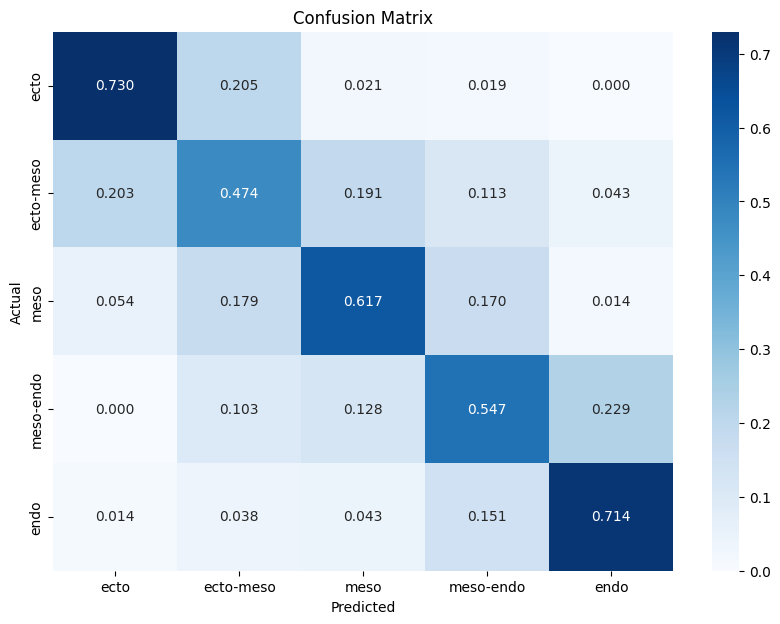

In [123]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '016'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 017

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 3, 4, 5, 6, 7, 9], val_folds=[2], test_folds=[8], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_017')
Accuracy: 0.554
Mean precision: 0.554
Mean recall: 0.562
---
ecto - precision: 0.628, recall: 0.617
ecto-meso - precision: 0.440, recall: 0.429
meso - precision: 0.500, recall: 0.484
meso-endo - precision: 0.550, recall: 0.510
endo - precision: 0.651, recall: 0.771


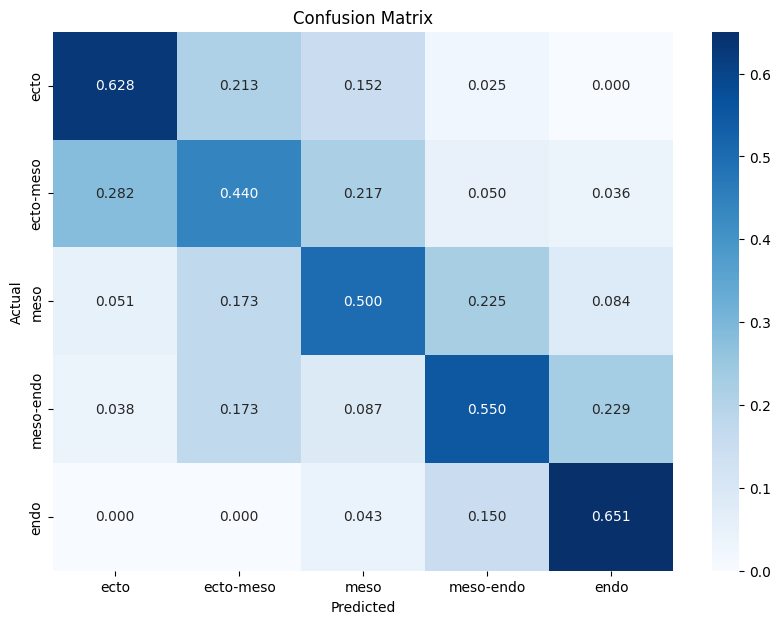

In [124]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '017'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 018

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 5, 7, 8, 9], val_folds=[0], test_folds=[6], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_018')
Accuracy: 0.586
Mean precision: 0.586
Mean recall: 0.586
---
ecto - precision: 0.707, recall: 0.771
ecto-meso - precision: 0.515, recall: 0.487
meso - precision: 0.491, recall: 0.522
meso-endo - precision: 0.429, recall: 0.439
endo - precision: 0.786, recall: 0.711


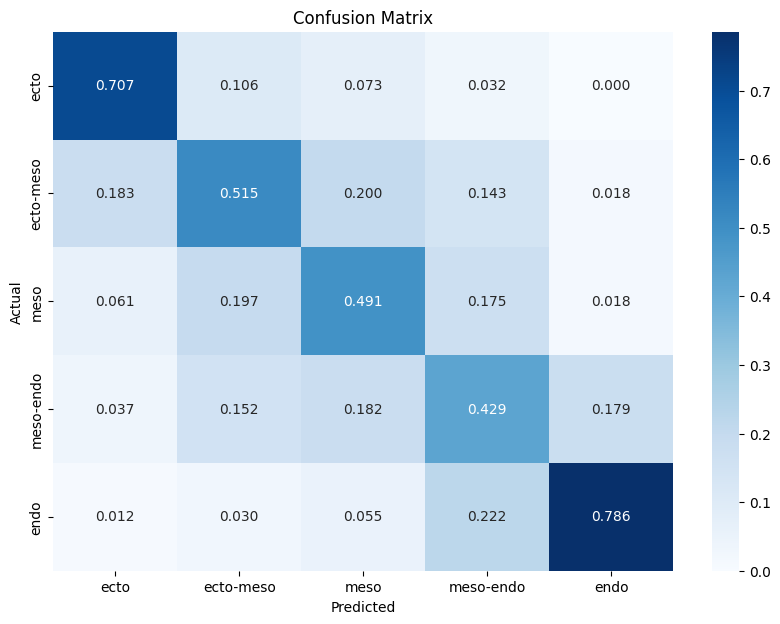

In [125]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '018'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 019

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_019')
Accuracy: 0.549
Mean precision: 0.549
Mean recall: 0.563
---
ecto - precision: 0.684, recall: 0.712
ecto-meso - precision: 0.368, recall: 0.329
meso - precision: 0.471, recall: 0.486
meso-endo - precision: 0.490, recall: 0.459
endo - precision: 0.733, recall: 0.828


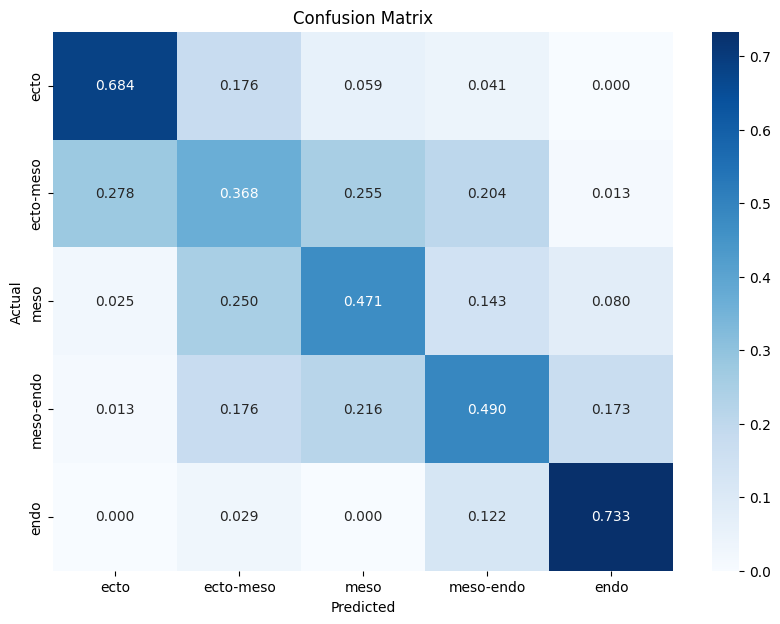

In [126]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '019'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 020

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_020')
Accuracy: 0.532
Mean precision: 0.532
Mean recall: 0.533
---
ecto - precision: 0.714, recall: 0.654
ecto-meso - precision: 0.328, recall: 0.290
meso - precision: 0.444, recall: 0.473
meso-endo - precision: 0.381, recall: 0.446
endo - precision: 0.790, recall: 0.803


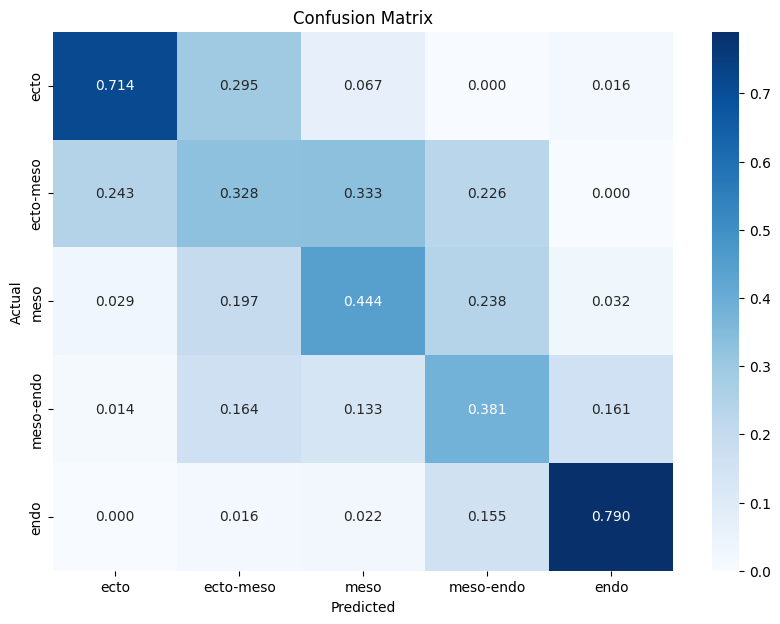

In [127]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '020'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 021

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_021')
Accuracy: 0.576
Mean precision: 0.576
Mean recall: 0.580
---
ecto - precision: 0.692, recall: 0.728
ecto-meso - precision: 0.408, recall: 0.379
meso - precision: 0.439, recall: 0.477
meso-endo - precision: 0.510, recall: 0.481
endo - precision: 0.831, recall: 0.836


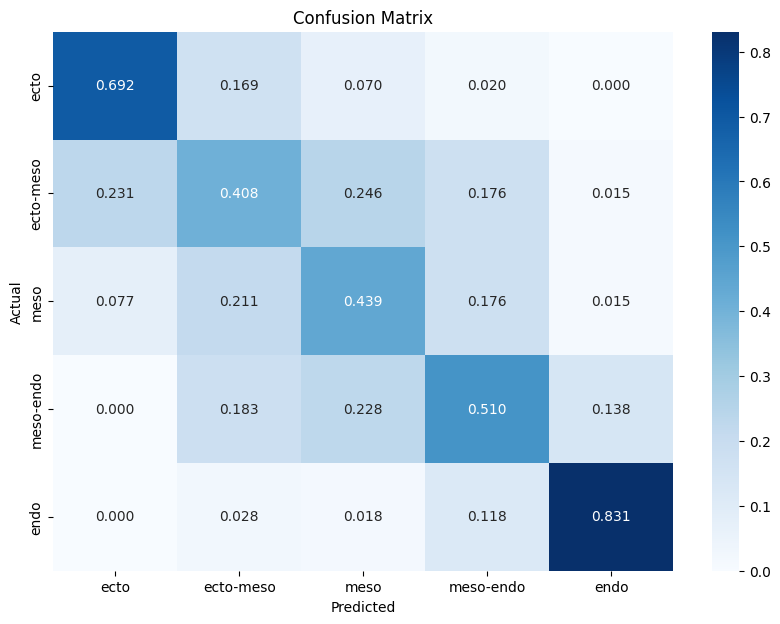

In [128]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '021'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 022

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_022')
Accuracy: 0.543
Mean precision: 0.543
Mean recall: 0.549
---
ecto - precision: 0.701, recall: 0.674
ecto-meso - precision: 0.357, recall: 0.315
meso - precision: 0.531, recall: 0.495
meso-endo - precision: 0.394, recall: 0.483
endo - precision: 0.730, recall: 0.780


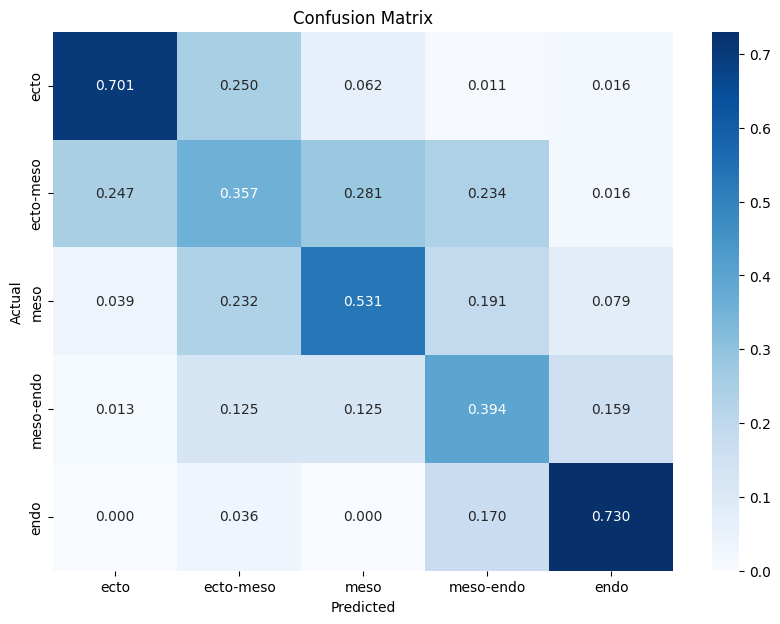

In [129]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '022'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 023

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_023')
Accuracy: 0.552
Mean precision: 0.552
Mean recall: 0.566
---
ecto - precision: 0.646, recall: 0.691
ecto-meso - precision: 0.368, recall: 0.332
meso - precision: 0.500, recall: 0.501
meso-endo - precision: 0.510, recall: 0.474
endo - precision: 0.733, recall: 0.828


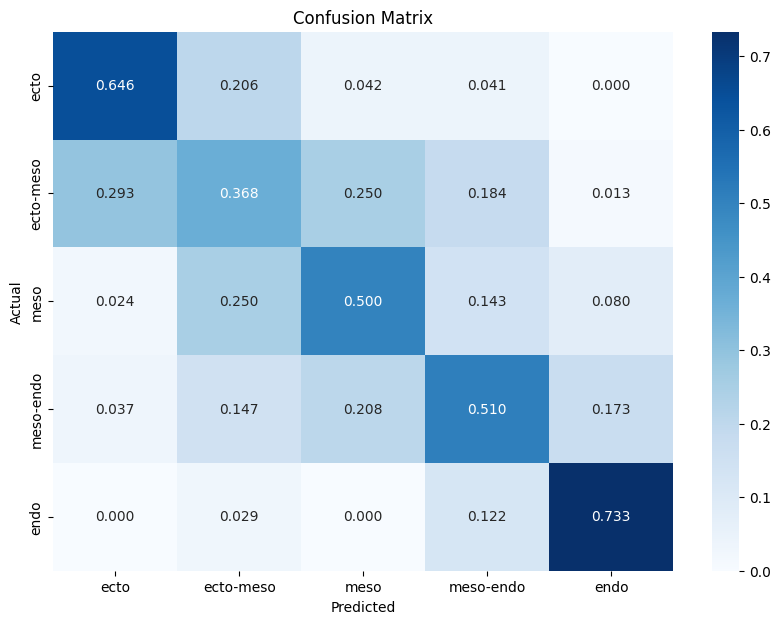

In [130]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '023'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 024

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_024')
Accuracy: 0.574
Mean precision: 0.574
Mean recall: 0.576
---
ecto - precision: 0.720, recall: 0.729
ecto-meso - precision: 0.415, recall: 0.380
meso - precision: 0.456, recall: 0.493
meso-endo - precision: 0.435, recall: 0.439
endo - precision: 0.841, recall: 0.839


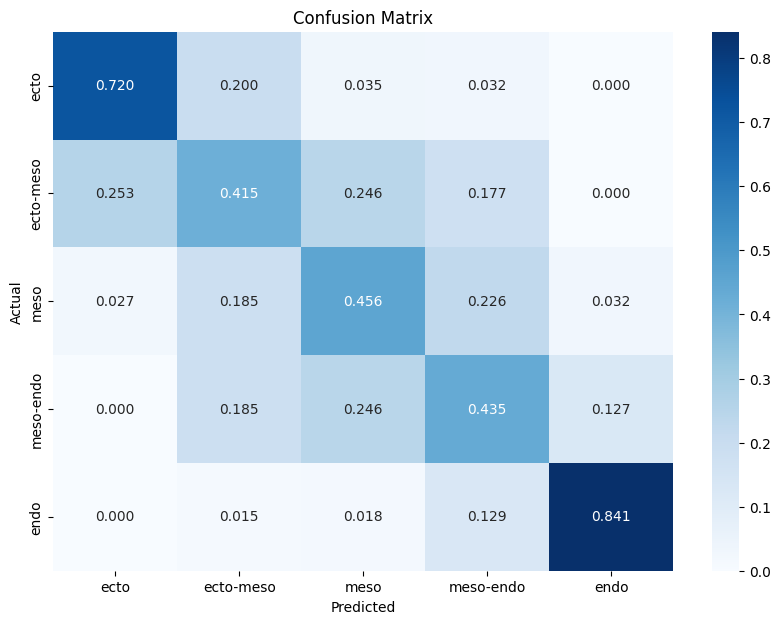

In [131]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '024'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.val_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 025

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_025')
Accuracy: 0.576
Mean precision: 0.576
Mean recall: 0.579
---
ecto - precision: 0.654, recall: 0.706
ecto-meso - precision: 0.462, recall: 0.468
meso - precision: 0.512, recall: 0.512
meso-endo - precision: 0.518, recall: 0.480
endo - precision: 0.734, recall: 0.727


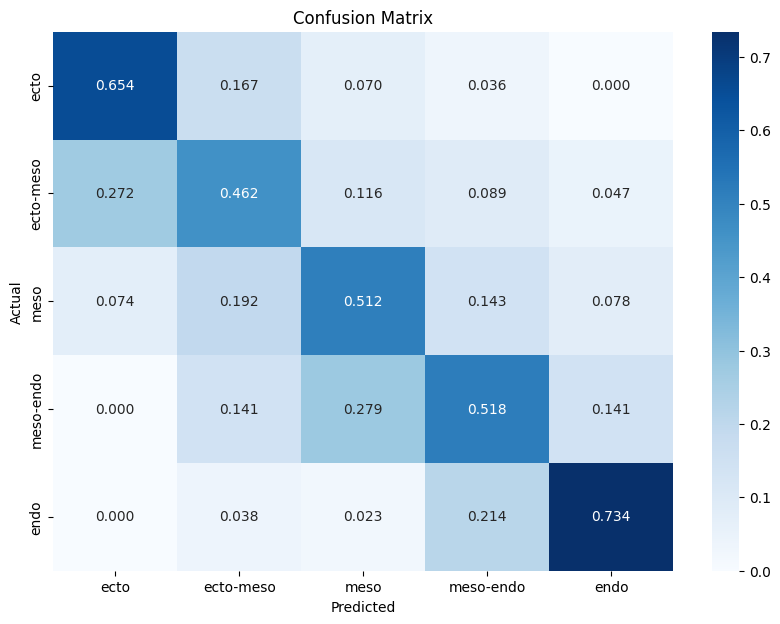

In [132]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '025'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 026

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_026')
Accuracy: 0.578
Mean precision: 0.578
Mean recall: 0.578
---
ecto - precision: 0.746, recall: 0.720
ecto-meso - precision: 0.459, recall: 0.445
meso - precision: 0.548, recall: 0.539
meso-endo - precision: 0.441, recall: 0.463
endo - precision: 0.696, recall: 0.722


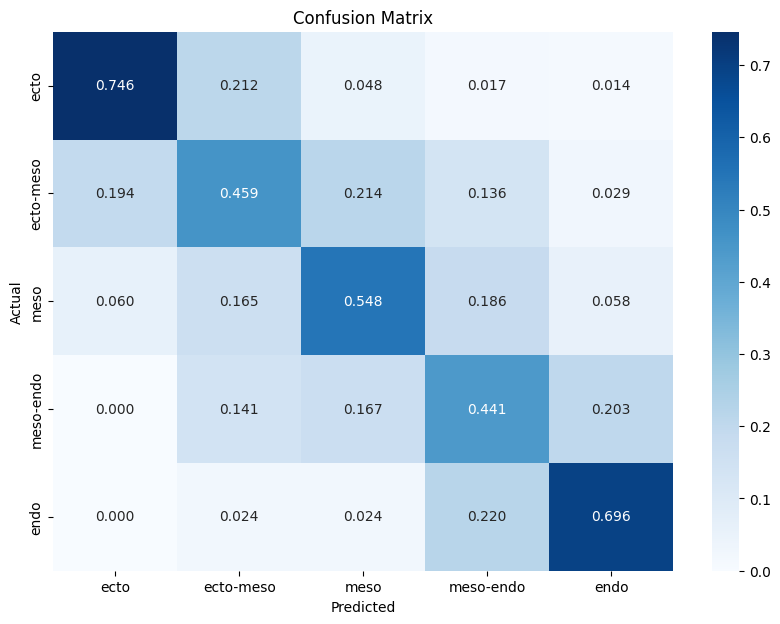

In [133]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '026'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 027

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_027')
Accuracy: 0.614
Mean precision: 0.614
Mean recall: 0.612
---
ecto - precision: 0.746, recall: 0.755
ecto-meso - precision: 0.460, recall: 0.509
meso - precision: 0.564, recall: 0.557
meso-endo - precision: 0.527, recall: 0.502
endo - precision: 0.770, recall: 0.738


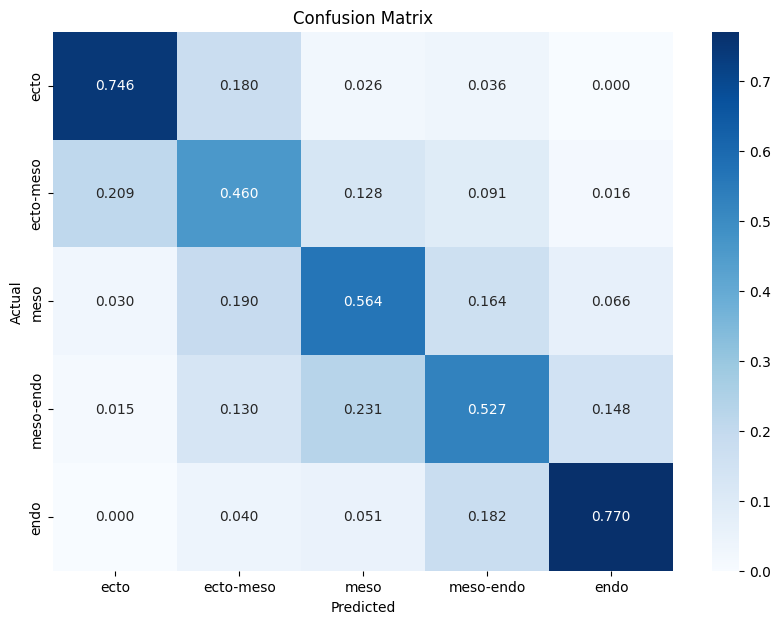

In [134]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '027'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 028

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_028')
Accuracy: 0.542
Mean precision: 0.542
Mean recall: 0.549
---
ecto - precision: 0.651, recall: 0.718
ecto-meso - precision: 0.431, recall: 0.390
meso - precision: 0.512, recall: 0.503
meso-endo - precision: 0.391, recall: 0.397
endo - precision: 0.727, recall: 0.738


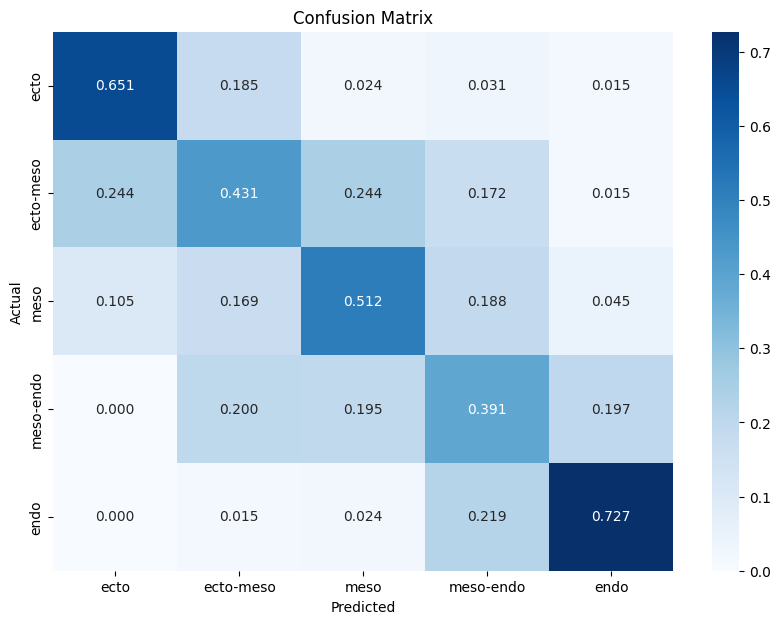

In [135]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '028'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 029

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_029')
Accuracy: 0.576
Mean precision: 0.576
Mean recall: 0.579
---
ecto - precision: 0.654, recall: 0.706
ecto-meso - precision: 0.462, recall: 0.468
meso - precision: 0.512, recall: 0.512
meso-endo - precision: 0.518, recall: 0.480
endo - precision: 0.734, recall: 0.727


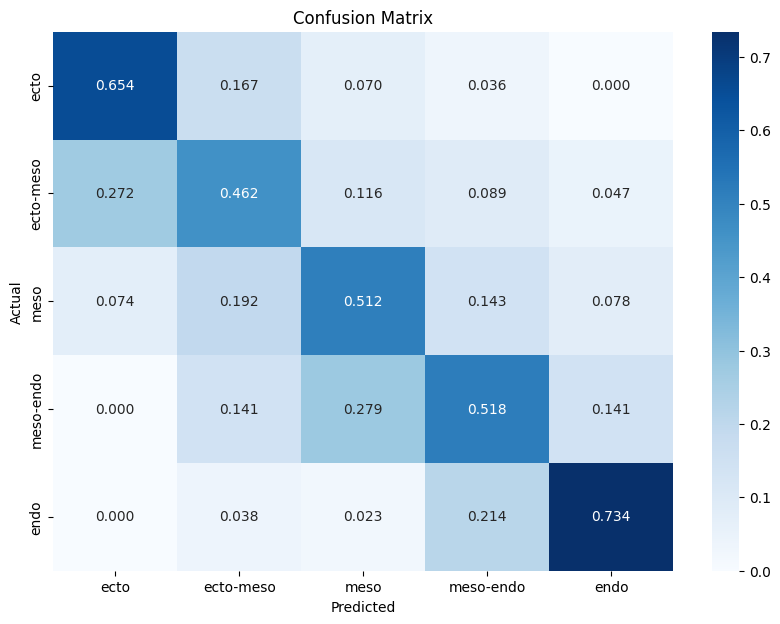

In [136]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '029'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 030

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.0001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0.1, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.0, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_030')
Accuracy: 0.562
Mean precision: 0.562
Mean recall: 0.562
---
ecto - precision: 0.734, recall: 0.701
ecto-meso - precision: 0.419, recall: 0.398
meso - precision: 0.556, recall: 0.532
meso-endo - precision: 0.418, recall: 0.457
endo - precision: 0.681, recall: 0.724


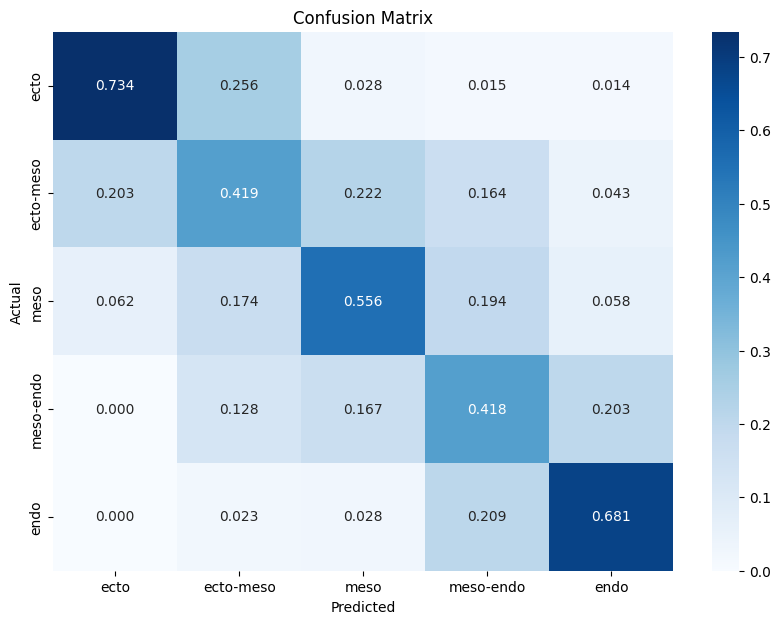

In [137]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '030'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 031

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_031')
Accuracy: 0.524
Mean precision: 0.524
Mean recall: 0.529
---
ecto - precision: 0.662, recall: 0.682
ecto-meso - precision: 0.361, recall: 0.333
meso - precision: 0.423, recall: 0.450
meso-endo - precision: 0.426, recall: 0.415
endo - precision: 0.746, recall: 0.763


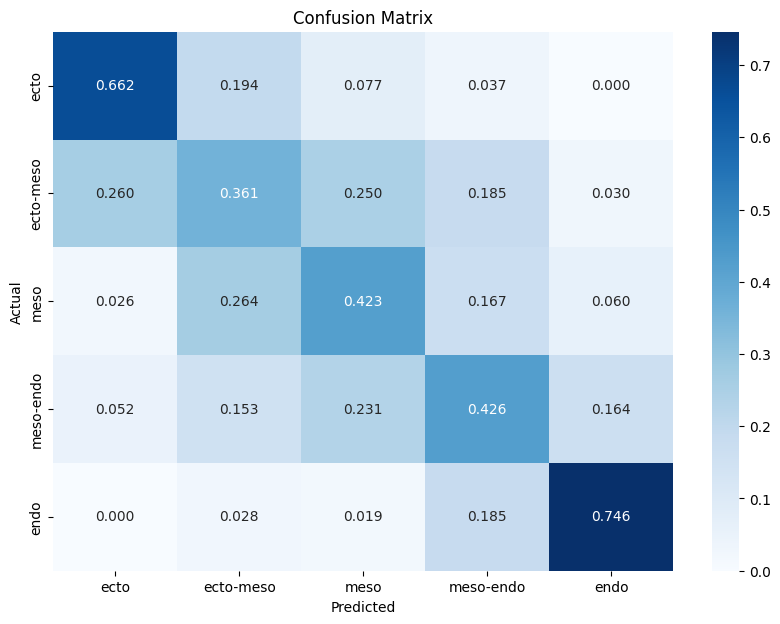

In [138]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '031'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 032

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_032')
Accuracy: 0.521
Mean precision: 0.521
Mean recall: 0.529
---
ecto - precision: 0.705, recall: 0.712
ecto-meso - precision: 0.349, recall: 0.309
meso - precision: 0.480, recall: 0.491
meso-endo - precision: 0.367, recall: 0.379
endo - precision: 0.704, recall: 0.752


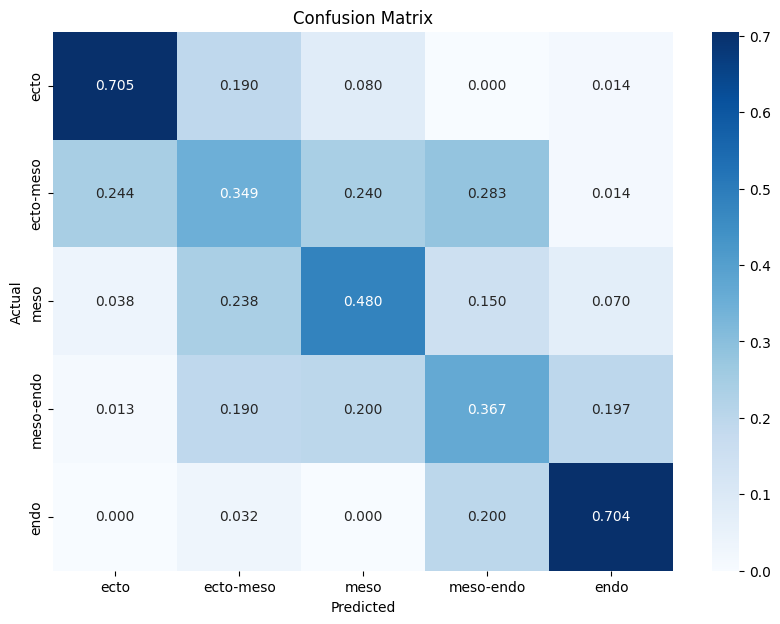

In [139]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '032'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, normalize='pred')

#### 033

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_033')
Accuracy: 0.586
Mean precision: 0.586
Mean recall: 0.590
---
ecto - precision: 0.701, recall: 0.741
ecto-meso - precision: 0.423, recall: 0.415
meso - precision: 0.529, recall: 0.533
meso-endo - precision: 0.542, recall: 0.510
endo - precision: 0.735, recall: 0.752


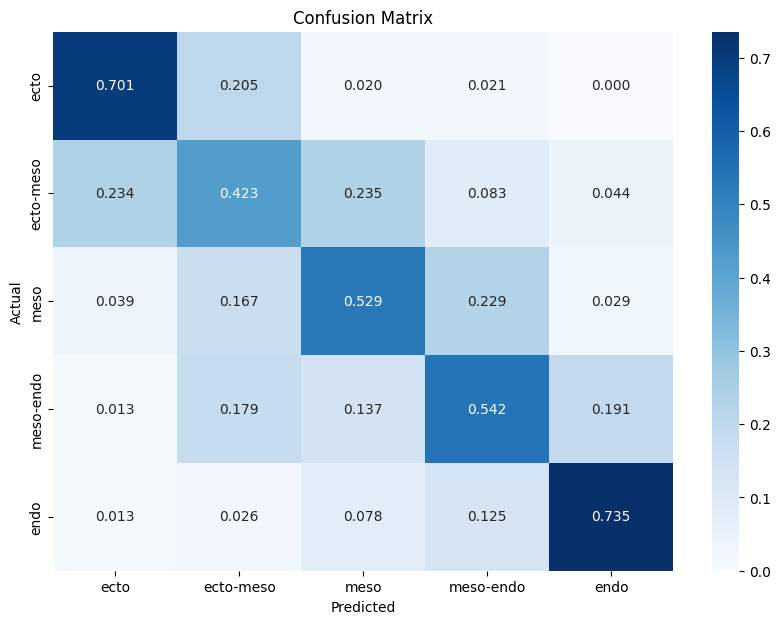

In [140]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '033'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets, normalize='pred')

#### 034

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 5, 6, 7, 8], val_folds=[9], test_folds=[4], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_034')
Accuracy: 0.526
Mean precision: 0.526
Mean recall: 0.532
---
ecto - precision: 0.591, recall: 0.635
ecto-meso - precision: 0.469, recall: 0.433
meso - precision: 0.488, recall: 0.468
meso-endo - precision: 0.460, recall: 0.452
endo - precision: 0.623, recall: 0.675


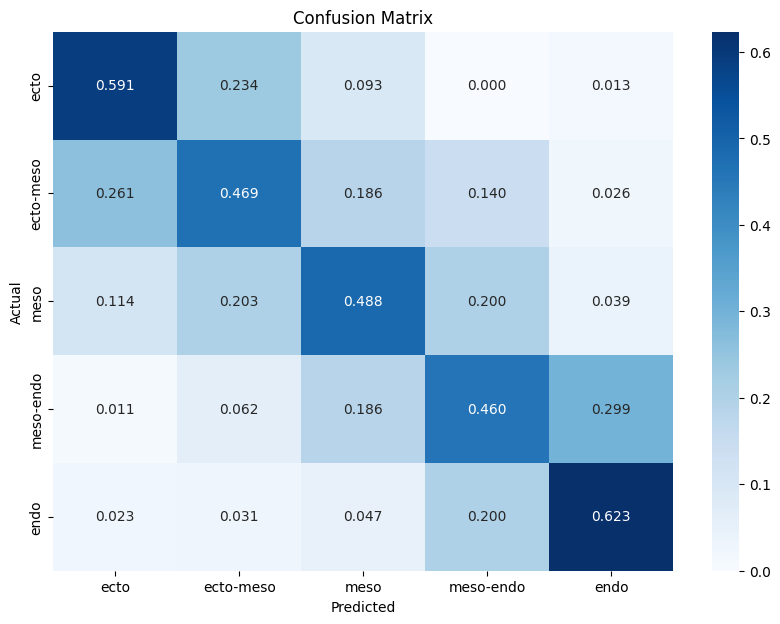

In [141]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '034'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 035

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 3, 4, 5, 6, 7, 9], val_folds=[2], test_folds=[8], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_035')
Accuracy: 0.532
Mean precision: 0.532
Mean recall: 0.541
---
ecto - precision: 0.613, recall: 0.585
ecto-meso - precision: 0.400, recall: 0.370
meso - precision: 0.500, recall: 0.484
meso-endo - precision: 0.531, recall: 0.526
endo - precision: 0.614, recall: 0.741


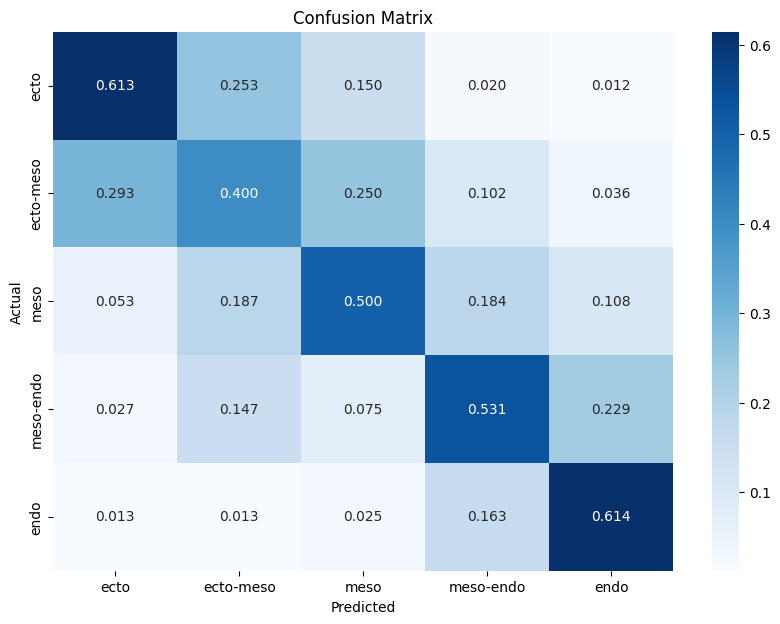

In [142]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '035'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 036

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_036')
Accuracy: 0.560
Mean precision: 0.560
Mean recall: 0.566
---
ecto - precision: 0.576, recall: 0.745
ecto-meso - precision: 0.452, recall: 0.493
meso - precision: 0.423, recall: 0.453
meso-endo - precision: 0.575, recall: 0.476
endo - precision: 0.776, recall: 0.664


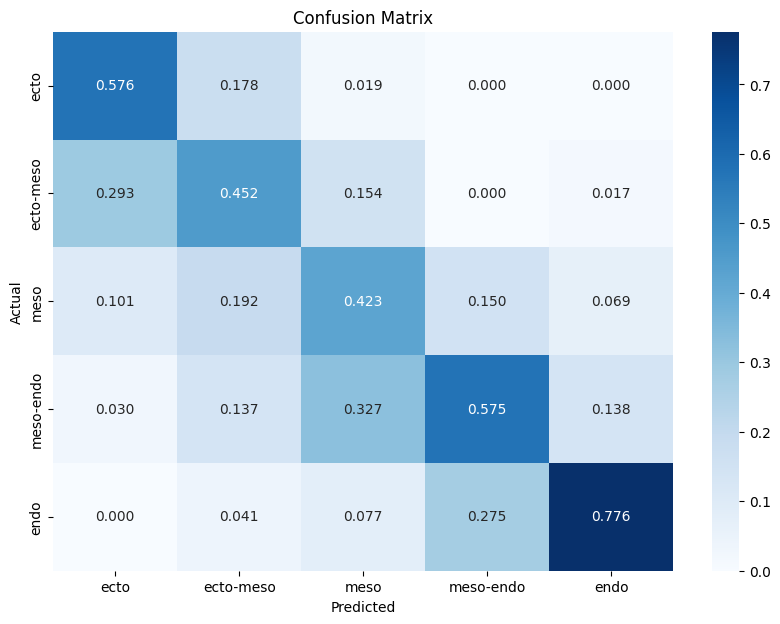

In [143]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '036'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 037

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_037')
Accuracy: 0.529
Mean precision: 0.529
Mean recall: 0.529
---
ecto - precision: 0.694, recall: 0.673
ecto-meso - precision: 0.473, recall: 0.437
meso - precision: 0.420, recall: 0.444
meso-endo - precision: 0.382, recall: 0.392
endo - precision: 0.676, recall: 0.701


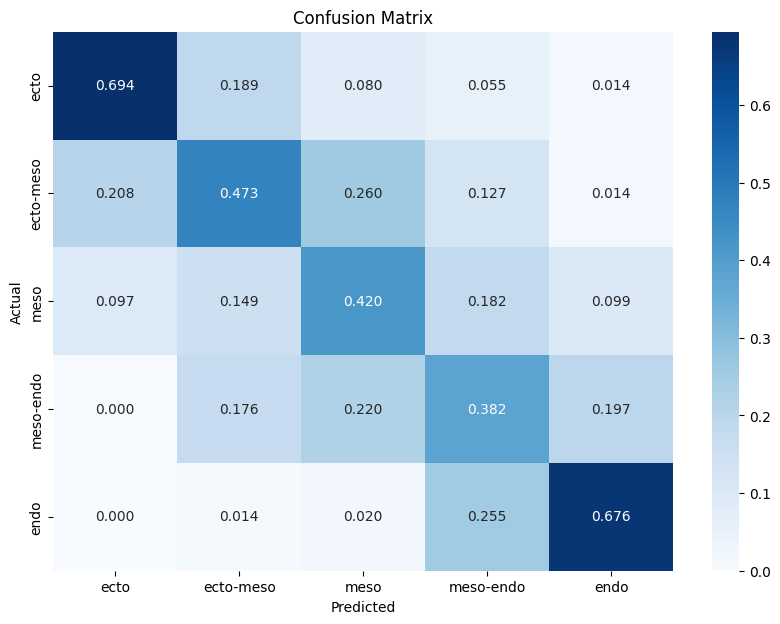

In [144]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '037'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 038

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_038')
Accuracy: 0.570
Mean precision: 0.570
Mean recall: 0.575
---
ecto - precision: 0.688, recall: 0.715
ecto-meso - precision: 0.434, recall: 0.408
meso - precision: 0.500, recall: 0.508
meso-endo - precision: 0.537, recall: 0.513
endo - precision: 0.690, recall: 0.733


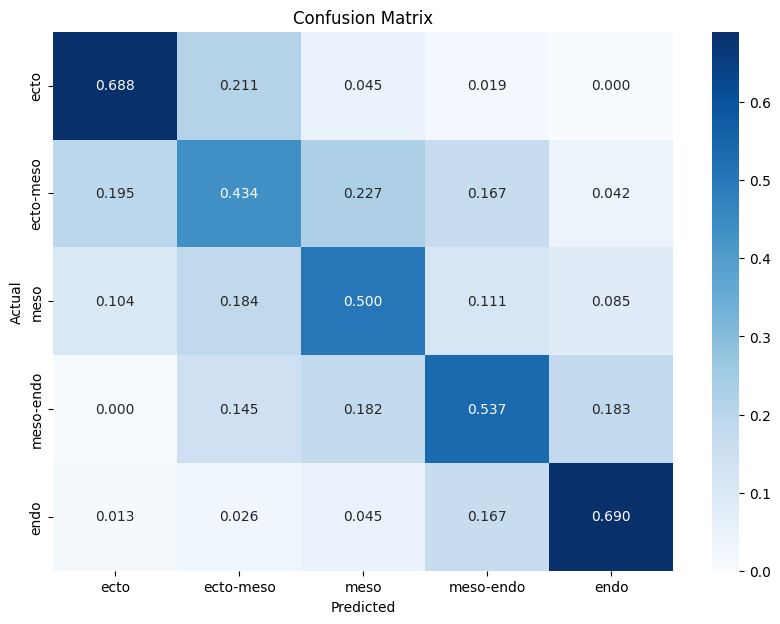

In [145]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '038'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 039

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 5, 6, 7, 8], val_folds=[9], test_folds=[4], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_039')
Accuracy: 0.590
Mean precision: 0.590
Mean recall: 0.603
---
ecto - precision: 0.621, recall: 0.670
ecto-meso - precision: 0.492, recall: 0.441
meso - precision: 0.545, recall: 0.521
meso-endo - precision: 0.562, recall: 0.535
endo - precision: 0.731, recall: 0.850


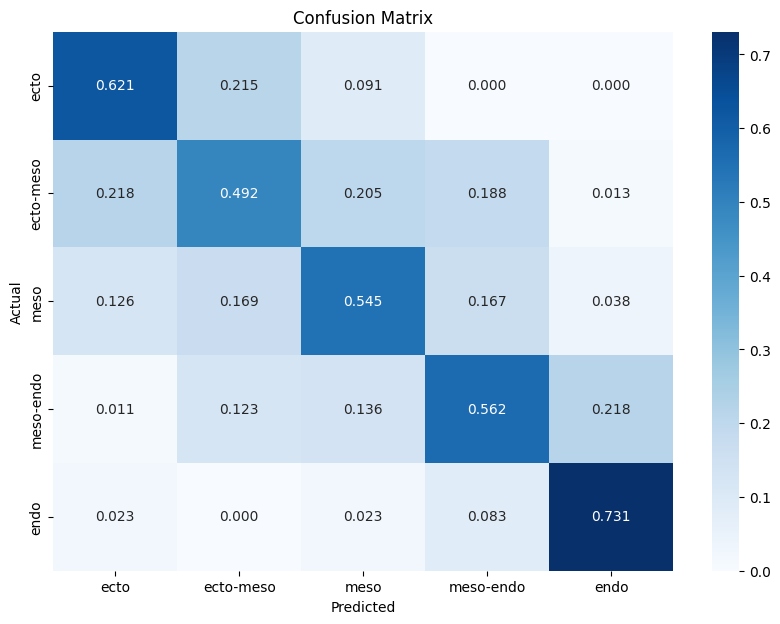

In [146]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '039'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 040

Namespace(model_name='resnet50d', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 3, 4, 5, 6, 7, 9], val_folds=[2], test_folds=[8], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=5, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet50d_040')
Accuracy: 0.498
Mean precision: 0.498
Mean recall: 0.510
---
ecto - precision: 0.635, recall: 0.650
ecto-meso - precision: 0.383, recall: 0.335
meso - precision: 0.327, recall: 0.353
meso-endo - precision: 0.500, recall: 0.457
endo - precision: 0.646, recall: 0.753


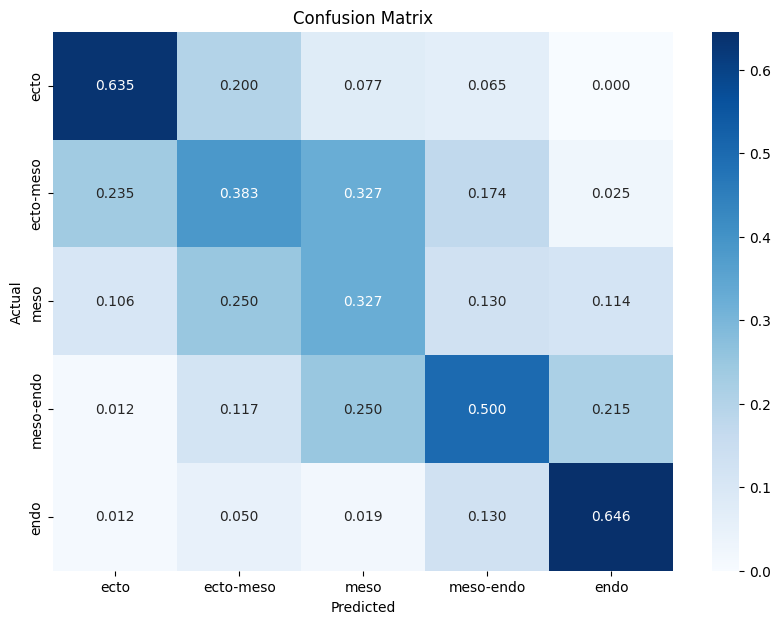

In [147]:
# Variables
model_name = 'resnet50d'
log_name = model_name + '_' + '040'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

### ResNet33ts

#### 001

Namespace(model_name='resnet33ts', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='FrontViewDataset', image_size=[3, 320, 224], num_classes=5, drop_rate=0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=100, earlyStopping_min_delta=0.01, earlyStopping_patience=5, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet33ts_001')
Accuracy: 0.415
Mean precision: 0.415
Mean recall: 0.417
---
ecto - precision: 0.436, recall: 0.466
ecto-meso - precision: 0.312, recall: 0.292
meso - precision: 0.358, recall: 0.389
meso-endo - precision: 0.395, recall: 0.376
endo - precision: 0.573, recall: 0.560


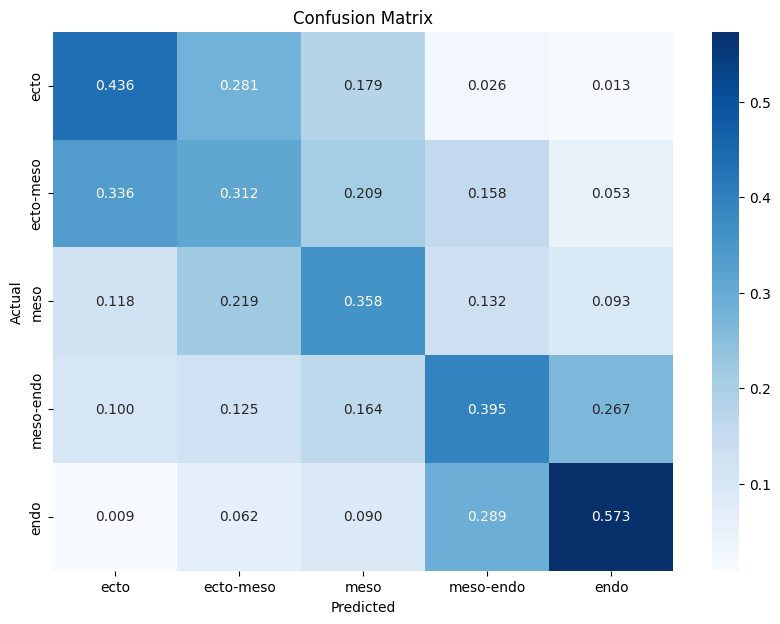

In [148]:
# Variables
model_name = 'resnet33ts'
log_name = model_name + '_' + '001'
weigths = 'model_epoch.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 002

Namespace(model_name='resnet33ts', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 3, 4, 5, 6, 7, 9], val_folds=[8], test_folds=[1], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet33ts_002')
Accuracy: 0.586
Mean precision: 0.586
Mean recall: 0.591
---
ecto - precision: 0.700, recall: 0.750
ecto-meso - precision: 0.520, recall: 0.514
meso - precision: 0.528, recall: 0.559
meso-endo - precision: 0.478, recall: 0.440
endo - precision: 0.706, recall: 0.690


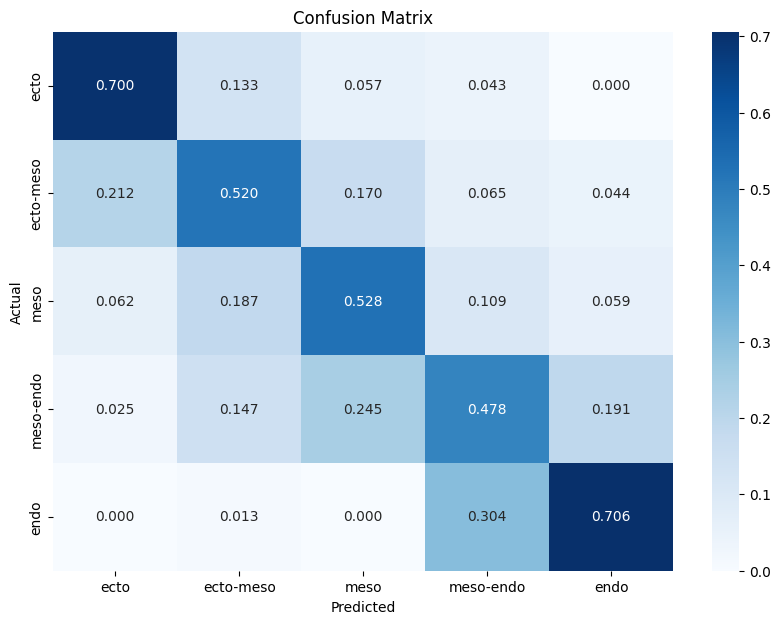

In [149]:
# Variables
model_name = 'resnet33ts'
log_name = model_name + '_' + '002'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 003

Namespace(model_name='resnet33ts', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 2, 4, 5, 6, 7, 8, 9], val_folds=[1], test_folds=[3], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet33ts_003')
Accuracy: 0.562
Mean precision: 0.562
Mean recall: 0.574
---
ecto - precision: 0.815, recall: 0.642
ecto-meso - precision: 0.435, recall: 0.371
meso - precision: 0.480, recall: 0.510
meso-endo - precision: 0.423, recall: 0.507
endo - precision: 0.659, recall: 0.841


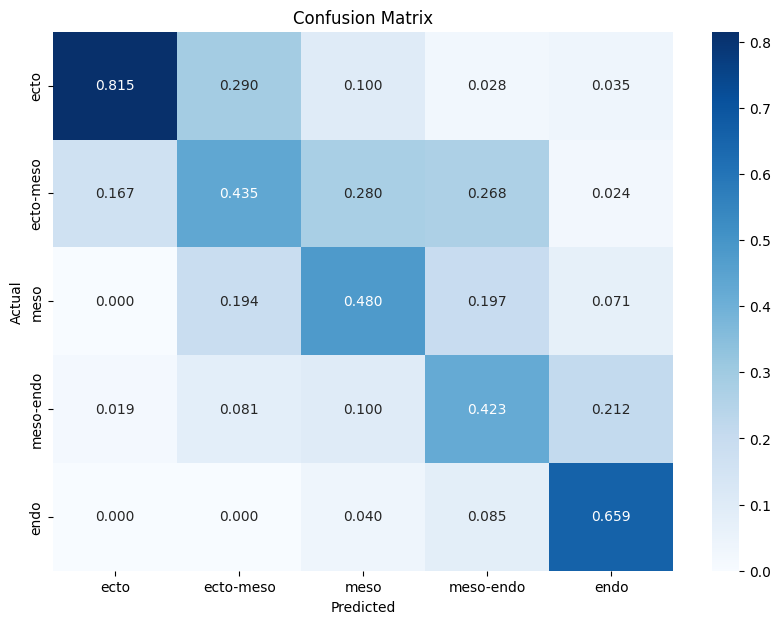

In [111]:
# Variables
model_name = 'resnet33ts'
log_name = model_name + '_' + '003'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 004

Namespace(model_name='resnet33ts', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[1, 2, 3, 4, 6, 7, 8, 9], val_folds=[5], test_folds=[0], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet33ts_004')
Accuracy: 0.583
Mean precision: 0.583
Mean recall: 0.583
---
ecto - precision: 0.742, recall: 0.715
ecto-meso - precision: 0.414, recall: 0.400
meso - precision: 0.511, recall: 0.530
meso-endo - precision: 0.509, recall: 0.521
endo - precision: 0.738, recall: 0.747


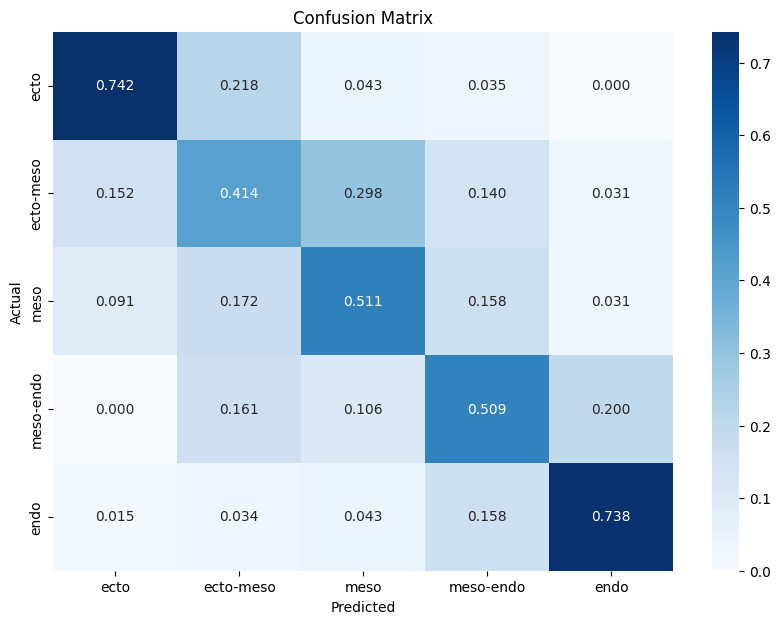

In [112]:
# Variables
model_name = 'resnet33ts'
log_name = model_name + '_' + '004'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)

#### 005

Namespace(model_name='resnet33ts', batch_size=32, learning_rate=0.001, num_epochs=100, train_folds=[0, 1, 2, 3, 5, 6, 7, 8], val_folds=[9], test_folds=[4], split='full_balanced', dataset='ThreeViewsDataset', image_size=[3, 224, 320], num_classes=5, drop_rate=0.0, scheduler_step_size=10, scheduler_gamma=0.1, num_epoch_unfreeze=10, earlyStopping_min_delta=0.01, earlyStopping_patience=10, data_path='/home/ubuntu/data/MORPHO_Batch1', split_path='./splits', log_path='./runs', log_name='resnet33ts_005')
Accuracy: 0.570
Mean precision: 0.570
Mean recall: 0.576
---
ecto - precision: 0.640, recall: 0.714
ecto-meso - precision: 0.469, recall: 0.438
meso - precision: 0.533, recall: 0.512
meso-endo - precision: 0.500, recall: 0.496
endo - precision: 0.706, recall: 0.718


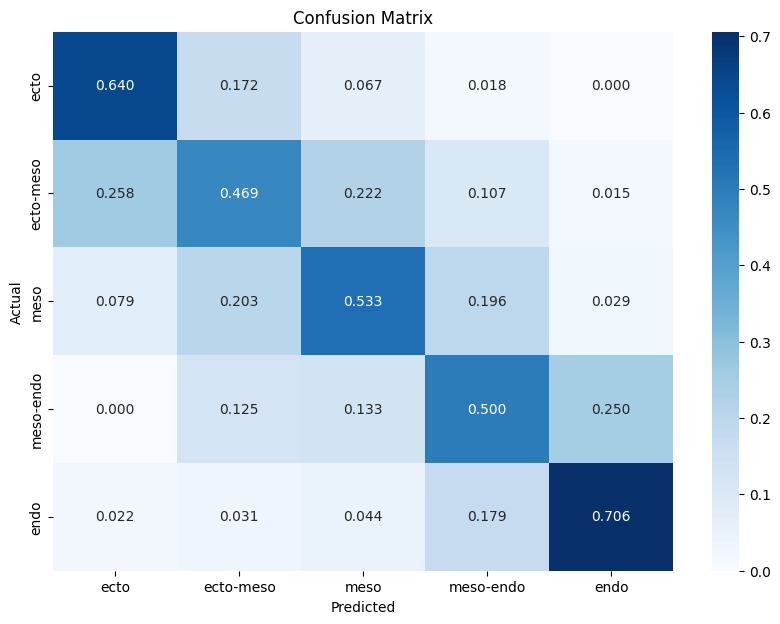

In [113]:
# Variables
model_name = 'resnet33ts'
log_name = model_name + '_' + '005'
weigths = 'model_best_acc.pth'

opt = options.load_options(os.path.join(run_dir, log_name, 'options.json'))
print(opt)
MyDataset = list_datasets[opt.dataset]
model_path = os.path.join(run_dir, log_name, weigths)


in_channels,h,w = opt.image_size                           
transform = create_transform((in_channels, h, w))

# Load Dataset
dataloader = load_dataset(split_dir, opt.split, opt.test_folds, image_dir_batch1, transform)

# Load model
model = load_model(model_name, in_channels, opt.num_classes, model_path)

# Evaluate model
accuracy, predictions, targets = evaluate_model(model, dataloader)

# Trace matrice de confusion
plot_confusion_matrix(predictions, targets)